In [2]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '..')

from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from util.plot_utils import plot_all_model_auc, perc_neg_npv_precision, collect_results_based_on_topbottom_for_all_models_perc_neg, npv_precision, plot_sr_distributions, plot_tnr_based_on_distance_for_our_model, collect_results_based_on_topbottom_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap, plot_tnr_recall_for_all_models, plot_correlation_nreads_prob_intsize
from util.model_names_map import map_model_names

# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '200_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
model_name = 'arch2_PARISfinetuned_PARIStest0033' 
PARIS_FINETUNED_MODEL = True
SPLASH_TRAINED_MODEL = False
energy_columns = ['IntaRNA', 'priblast', 'RNAplex', 'rnacofold', 'assa', 'RNAhybrid', 'RNAup', 'risearch2']
list_of_HQ_datasets = ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ']
list_of_datasets = list_of_HQ_datasets + ['psoralen', 'paris', 'paris_mouse', 'ricseq', 'mario', 'splash']

In [4]:
nt_models = [model_name]
list_of_models_to_test = ['nt'] + energy_columns + [f'nt{_}' for _ in range(1, len(nt_models))]

# TODO:

Controlla la classe, poi quando tutto funziona, modifica def _load_dataframes(self) usando il try except che c e dentro.

In [5]:
modelRM = ModelResultsManager(model_name = model_name, 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = energy_columns, 
                            other_tools_dir = external_dataset_dir)

### Do the model correlate in their scores?

Sembra esserci una correlazione piu forte con la termodinamica su MOUSE e piu debole su HUMAN

DATASET: psoralen


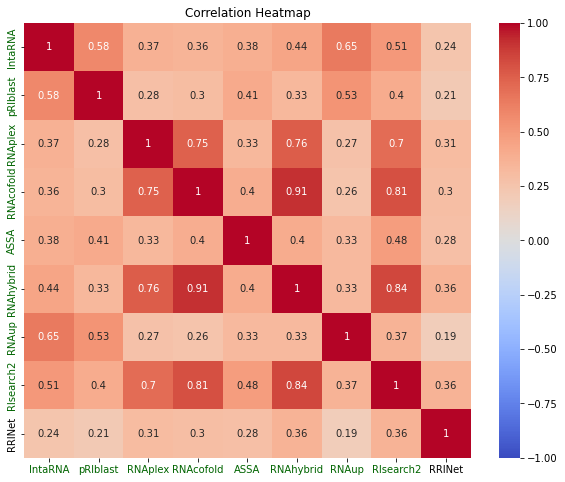

DATASET: paris


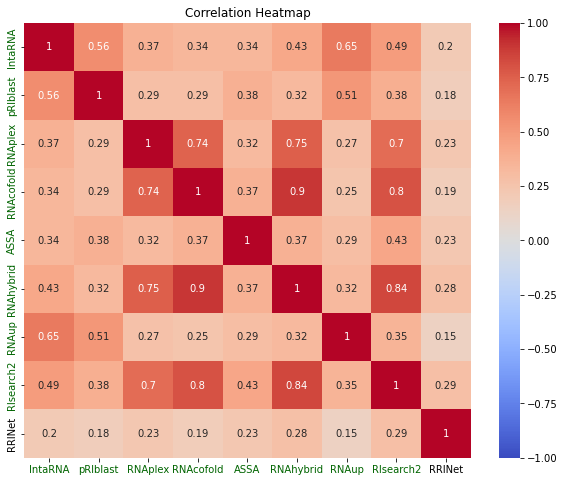

DATASET: splash


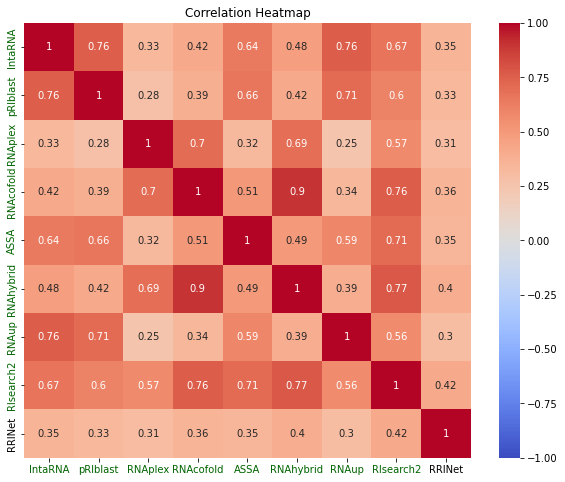

DATASET: paris_mouse


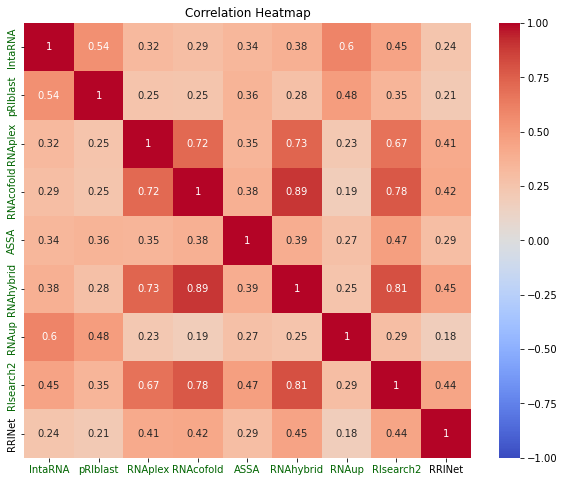

DATASET: ricseq


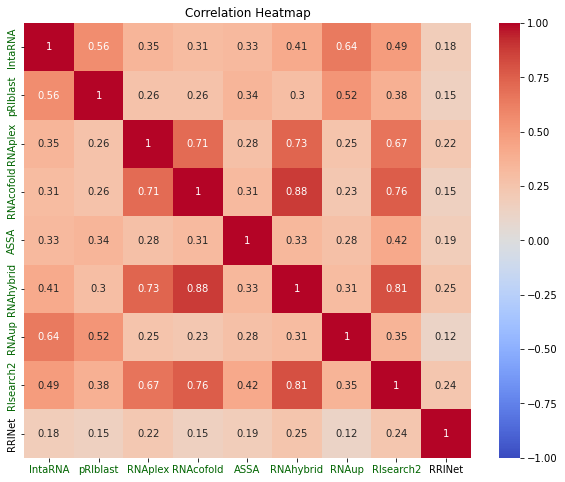

DATASET: mario


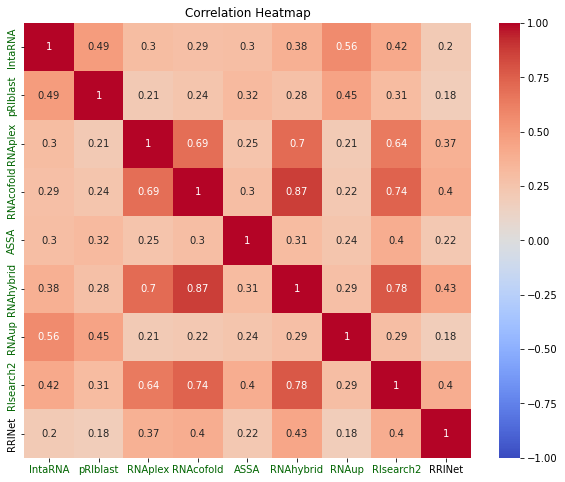

In [5]:
method='spearman' # 'pearson', 'spearman', 'kendall', 'mutual_info'
plot_each_correlation = False

for dataset in ['psoralen', 'paris', 'splash', 'paris_mouse', 'ricseq', 'mario']: #psoralen
        
    experiment, specie_paris, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        logistic_regression_models = {},
    )

    for model_column in energy_columns:
        res[model_column] = -res[model_column] # make energy column positives, such that the correlations will be positives as well


    res_for_corr = balancing_only_for_one_task(res, task = 'all')
    
    print(f'DATASET: {dataset}')
    
    #correlations = calculate_correlations([res_for_corr[i] for i in energy_columns + ['probability'] + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    correlations = calculate_correlations([res_for_corr[i] for i in energy_columns + ['probability'] + [f'nt{_}' for _ in range(1, len(nt_models))]], method=method, plot=plot_each_correlation)
    plot_heatmap(correlations, highlight_labels = map_model_names(energy_columns), method = method)

### Checks 

In [6]:
# for exp in ['test_HQ', 'test', 'mario', 'splash', 'ricseq',]:
    
#     if exp == 'test_HQ':
#         experiment = 'paris'
#         paris_hq = True
    
#     elif exp == 'test':
#         experiment = 'paris'
#         paris_hq = False
#     else:
#         experiment = exp
#         paris_hq = False
        
        
#     res = modelRM.get_experiment_data(
#                 experiment = experiment, 
#                 paris_test = True, 
#                 paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#                 specie_paris = 'all',
#                 paris_hq = paris_hq,
#                 paris_hq_threshold = 1,
#                 n_reads_paris = 1,
#                 splash_trained_model = False,
#                 only_test_splash_ricseq_mario = False,
#                 n_reads_ricseq = 1,
#                 logistic_regression_models = {},
#     ) 
        
#     original_res = pd.read_csv( os.path.join(ROOT_DIR, 'checkpoints', model_name, f'{exp}_results200.csv'))
#     test500 = pd.read_csv(os.path.join(metadata_dir, f'{exp}200.csv'))
    
    
#     print(exp)
    
#     with open(os.path.join(rna_rna_files_dir, "gene_pairs_training.txt"), "rb") as fp:
#             couples_paris_training = pickle.load(fp)
#     original_res = original_res[~original_res.couples.isin(couples_paris_training)].reset_index(drop = True)
#     test500 = test500[~(test500.g1 + '_' + test500.g2).isin(couples_paris_training)].reset_index(drop = True)
    
#     assert test500.shape[0] == original_res.shape[0]
#     assert set(test500.couples) == set(original_res.id_sample) == set(res.id_sample)
#     assert set(original_res.merge(res, on = ['probability', 'id_sample']).id_sample) == set(original_res.id_sample)

#     cols_equal = list(set(test500.drop(['policy', 'g1', 'g2', 'couples'], axis = 1).columns).intersection(res.columns))
#     assert set(test500.merge(res.drop('couples', axis = 1), on = cols_equal).couples) == set(original_res.id_sample)

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with psoralen human)

In [98]:
res = modelRM.get_experiment_data(
    experiment = 'paris', 
    paris_test = True, 
    paris_finetuned_model = PARIS_FINETUNED_MODEL, 
    specie_paris = 'all',
    paris_hq = False,
    paris_hq_threshold = 1,
    n_reads_paris = 1,
    splash_trained_model = False,
    only_test_splash_ricseq_mario = False,
    n_reads_ricseq = np.nan,
    logistic_regression_models = {},
)

In [99]:
df_training = balancing_only_for_one_task(res, task = 'all').reset_index(drop = True)

In [100]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column, threshold = 3)
    df_training = balancing_only_for_one_task(df_training, task = 'all').reset_index(drop = True)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}
    
    
#assa
logistic_regression_models['assa']['threshold_value'] = -0.05 # 
logistic_regression_models['assa']['coef'] = np.round(-logistic_regression_models['assa']['intercept'] / logistic_regression_models['assa']['coef'], 2)

#priblast
logistic_regression_models['priblast']['threshold_value'] = -0.05 # 
logistic_regression_models['priblast']['coef'] = np.round(-logistic_regression_models['priblast']['intercept'] / logistic_regression_models['priblast']['coef'], 2)


# # Open the file in binary write mode and serialize the dictionary
# with open(LR_MAPPING_PATH, 'wb') as file:
#     pickle.dump(logistic_regression_models, file)

  0%|          | 0/8 [00:00<?, ?it/s]

# Model comparison

In [6]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

### AUC

In [7]:
df_auc = obtain_df_auc(modelRM, PARIS_FINETUNED_MODEL, energy_columns, SPLASH_TRAINED_MODEL, list_of_datasets = list_of_datasets, logistic_regression_models = {} )

HQ_COLS = [
    'model_name', 
    'auc_interactors_parisHQ', 'auc_patches_parisHQ', 
    'auc_interactors_paris_mouse_HQ', 'auc_patches_paris_mouse_HQ',
    'auc_interactors_ricseqHQ', 'auc_patches_ricseqHQ'
]
OTHER = [
    'model_name', 
    'auc_interactors_psoralen', 'auc_patches_psoralen', 
    'auc_interactors_paris', 'auc_patches_paris', 
    'auc_interactors_paris_mouse', 'auc_patches_paris_mouse', 
    'auc_interactors_ricseq', 'auc_patches_ricseq', 'auc_interactors_mario', 
    'auc_patches_mario', 'auc_interactors_splash', 'auc_patches_splash'
]

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
df_auc.filter(HQ_COLS, axis = 1)

model_name  auc_interactors_parisHQ  auc_patches_parisHQ  \
0     RRINet                     0.69                 0.79   
1    IntaRNA                     0.53                 0.60   
2   pRIblast                     0.53                 0.57   
3    RNAplex                     0.53                 0.58   
4  RNAcofold                     0.50                 0.55   
5       ASSA                     0.50                 0.55   
6  RNAhybrid                     0.53                 0.60   
7      RNAup                     0.53                 0.57   
8  RIsearch2                     0.54                 0.64   

   auc_interactors_paris_mouse_HQ  auc_patches_paris_mouse_HQ  \
0                            0.56                        0.72   
1                            0.55                        0.63   
2                            0.55                        0.57   
3                            0.54                        0.66   
4                            0.50                        0.62   
5                            0.52                        0.56   
6                            0.50                        0.67   
7                            0.55                        0.63   
8                            0.54                        0.68   

   auc_interactors_ricseqHQ  auc_patches_ricseqHQ  
0                      0.73                  0.80  
1                      0.54                  0.57  
2                      0.51                  0.54  
3                      0.57                  0.61  
4                      0.58                  0.61  
5                      0.56                  0.57  
6                      0.64                  0.67  
7                      0.50                  0.53  
8                      0.61                  0.65

In [9]:
df_auc.filter(OTHER, axis = 1)

model_name  auc_interactors_psoralen  auc_patches_psoralen  \
0     RRINet                      0.57                  0.68   
1    IntaRNA                      0.55                  0.59   
2   pRIblast                      0.54                  0.57   
3    RNAplex                      0.53                  0.57   
4  RNAcofold                      0.52                  0.57   
5       ASSA                      0.53                  0.55   
6  RNAhybrid                      0.53                  0.59   
7      RNAup                      0.54                  0.57   
8  RIsearch2                      0.55                  0.60   

   auc_interactors_paris  auc_patches_paris  auc_interactors_paris_mouse  \
0                   0.58               0.67                         0.54   
1                   0.53               0.56                         0.55   
2                   0.52               0.54                         0.53   
3                   0.52               0.55                         0.53   
4                   0.51               0.55                         0.52   
5                   0.51               0.53                         0.52   
6                   0.52               0.56                         0.53   
7                   0.52               0.54                         0.54   
8                   0.53               0.58                         0.54   

   auc_patches_paris_mouse  auc_interactors_ricseq  auc_patches_ricseq  \
0                     0.69                    0.54                0.63   
1                     0.59                    0.58                0.61   
2                     0.56                    0.55                0.58   
3                     0.60                    0.51                0.56   
4                     0.61                    0.50                0.54   
5                     0.55                    0.54                0.55   
6                     0.61                    0.52                0.57   
7                     0.56                    0.56                0.60   
8                     0.62                    0.55                0.60   

   auc_interactors_mario  auc_patches_mario  auc_interactors_splash  \
0                   0.51               0.70                    0.57   
1                   0.47               0.54                    0.80   
2                   0.49               0.52                    0.76   
3                   0.50               0.64                    0.52   
4                   0.49               0.68                    0.57   
5                   0.50               0.52                    0.74   
6                   0.50               0.67                    0.59   
7                   0.48               0.53                    0.77   
8                   0.49               0.64                    0.72   

   auc_patches_splash  
0                0.77  
1                0.87  
2                0.82  
3                0.60  
4                0.63  
5                0.78  
6                0.67  
7                0.82  
8                0.79

dataset: parisHQ


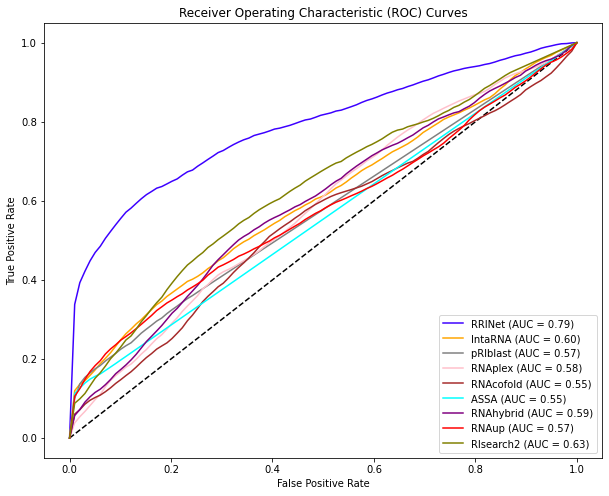

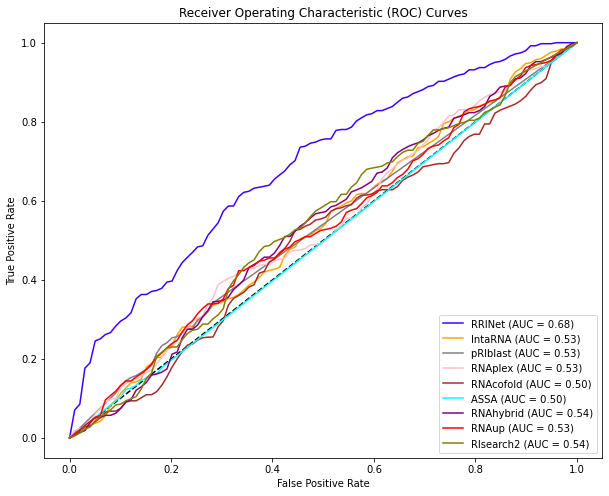

dataset: paris_mouse_HQ


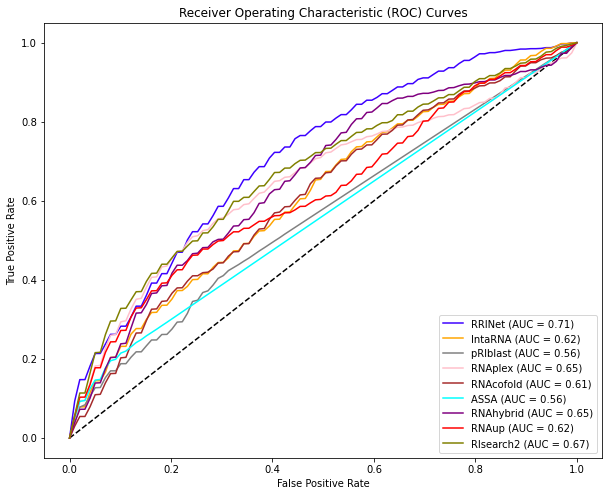

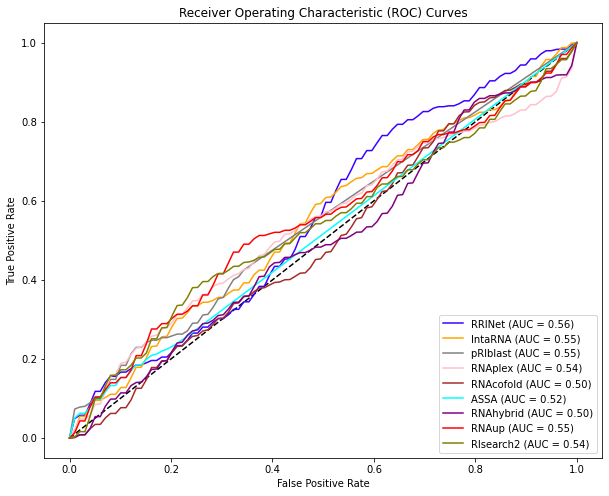

dataset: ricseqHQ


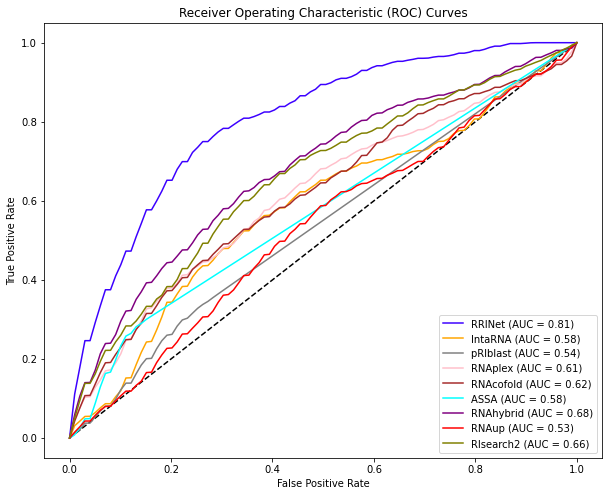

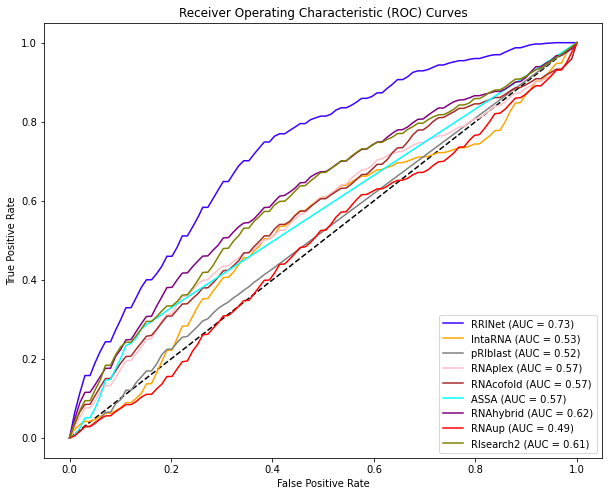

In [26]:
for dataset in list_of_HQ_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq = map_dataset_to_hp(dataset)
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = 1,
        splash_trained_model = SPLASH_TRAINED_MODEL,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
     
    print(f'dataset: {dataset}')
    plot_all_model_auc(res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True), energy_columns)
    plot_all_model_auc(res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True), energy_columns)

In [10]:
# TO CHECK THAT IT'S WORKING THE MAPPING
# df_auc2 = obtain_df_auc(modelRM, energy_columns, list_of_datasets = list_of_datasets, logistic_regression_models = logistic_regression_models )
# errors = df_auc.filter(OTHER, axis = 1).drop('model_name', axis =1 ) - df_auc2.filter(OTHER, axis = 1).drop('model_name', axis =1 )
# errors['model_name'] = df_auc['model_name']
# errors

### Repeats enrichment

In [11]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [12]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 2
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models
tasks_treshold = ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']

##############   ##############   ##############   ##############   ##############
---------- DATASET: psoralen ----------
Simple_repeat are the 1.0940281598964234  % of the total couples
No Simple_repeat are the 84.07185628742515  % of the total couples


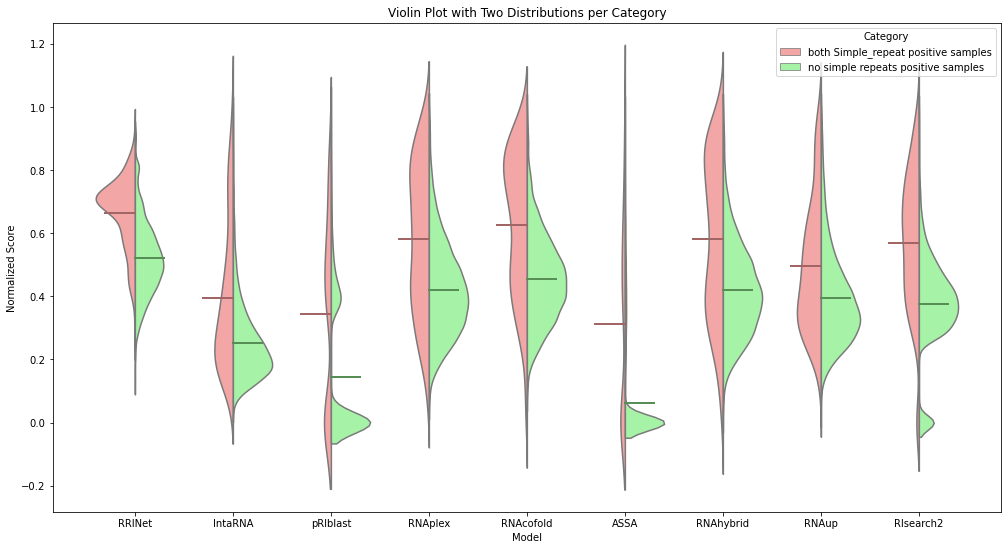

0.665481596895792
0.5202351047985159



##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
Simple_repeat are the 0.5005889281507656  % of the total couples
No Simple_repeat are the 87.88574793875146  % of the total couples


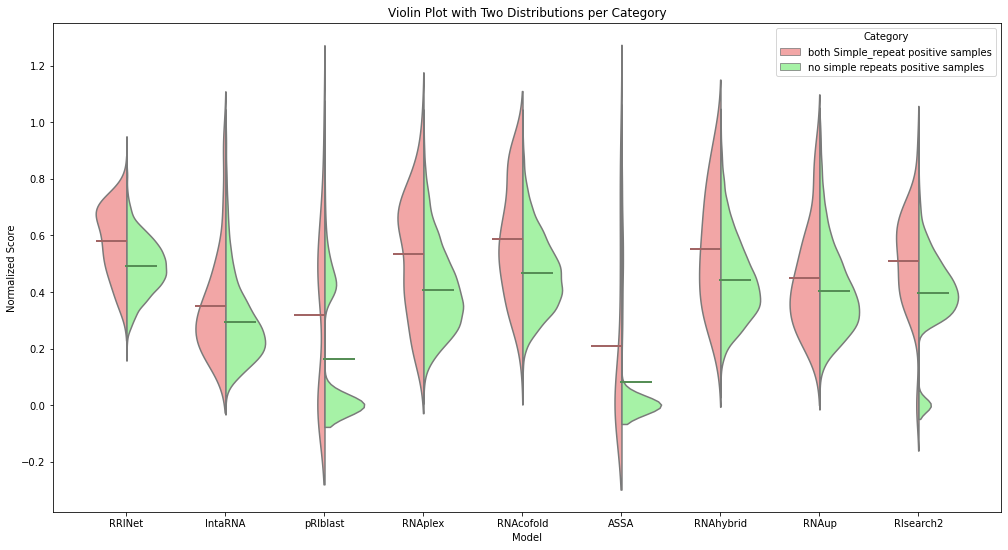

0.5803944729268551
0.49001181223313295



##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
Simple_repeat are the 0.353045013239188  % of the total couples
No Simple_repeat are the 87.90820829655782  % of the total couples


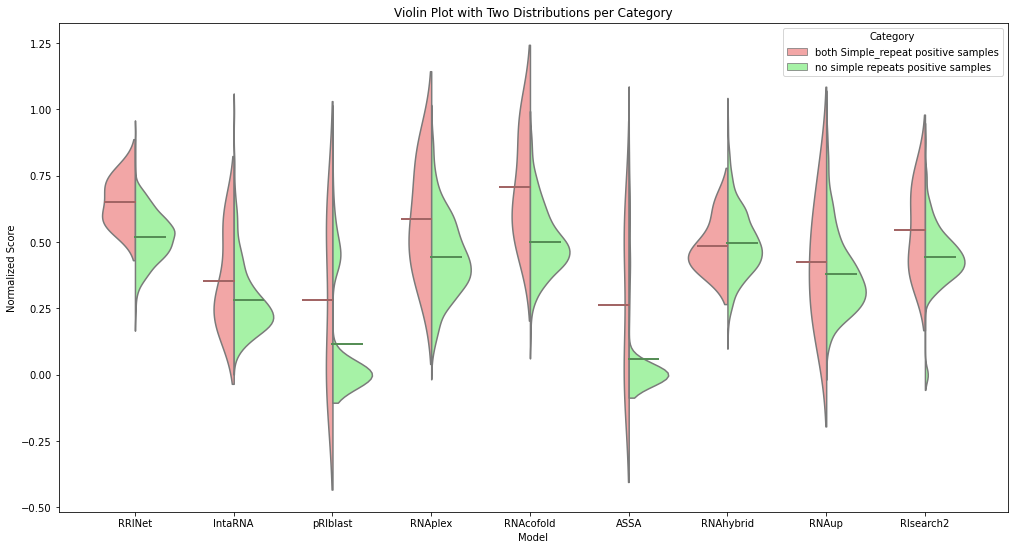

0.6517555117607117
0.520330345616975





In [13]:
for dataset in ['psoralen', 'ricseq', 'mario']: #'paris_mouse',
    print(f'##############   ##############   ##############   ##############   ##############')
    print(f'---------- DATASET: {dataset} ----------')
    
    
    experiment, specie_paris, _, _ = map_dataset_to_hp(dataset)
        
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        logistic_regression_models = {},
    )
    
    res = replace_outliers_with_nan_and_make_positive(res, energy_columns)
    
    #normalize after we removed outliers
    for model_column in energy_columns:
        res[model_column] = (res[model_column]-res[model_column].min())/(res[model_column].max()-res[model_column].min())
    
    res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
    res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
    res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
    res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
    
    filtered_policies = ['easypos', 'smartneg']
    sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')


    sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
    sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

    no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
    no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)

    
    df_sr = []
    for column in (['probability'] + energy_columns):

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'

        x, y = sr_ep[column], no_sr_ep[column]
        
        df_model = pd.DataFrame({
                'Model': [column] * (len(x) + len(y)),
                'Category': pd.concat([
                    pd.Series([label_x] * len(x)), 
                    pd.Series(['no simple repeats positive samples'] * len(y))
                ]),
                'Normalized Score': pd.concat([x, y])
            })
        
        df_sr.append(df_model)
        
    df_sr = pd.concat(df_sr)
    
    plot_sr_distributions(df_sr, label_x, figsize = figsize_treshold)
    
    print(df_sr[(df_sr['Model'] == MODEL_NAME)&(df_sr['Category'] =='both Simple_repeat positive samples')]['Normalized Score'].mean())
    print(df_sr[(df_sr['Model'] == MODEL_NAME)&(df_sr['Category'] =='no simple repeats positive samples')]['Normalized Score'].mean())

    print('\n\n')

### To see how it works in predicting Simple Repeat cases, but also whats the percentage of SR at high confidence

In [109]:
# for dataset in list_of_datasets:
#     print(f'##############   ##############   ##############   ##############   ##############')
#     print(f'---------- DATASET: {dataset} ----------')

#     experiment, specie_paris, paris_hq_threshold, n_reads_ricseq = map_dataset_to_hp(dataset)
        
#     res = modelRM.get_experiment_data(
#         experiment = experiment, 
#         paris_test = True, 
#         paris_finetuned_model = PARIS_FINETUNED_MODEL, 
#         specie_paris = specie_paris,
#         paris_hq = paris_hq_threshold,
#         paris_hq_threshold = 1,
#         n_reads_paris = 1,
#         splash_trained_model = False,
#         only_test_splash_ricseq_mario = False,
#         n_reads_ricseq = n_reads_ricseq,
#         logistic_regression_models = logistic_regression_models,
#     )

#     res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
#     res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
#     res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
#     res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)

#     filtered_policies = ['easypos', 'smartneg']
#     sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
#     N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
#     print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
#     print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')

#     sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
#     sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

#     no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
#     no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)

#     ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
#     for metric in list_of_metrics:
    
#         for task in tasks_treshold:
#             print(f'           -- -- -- {task} -- -- -- ')
#             print(f'           -  -  -  {metric}  -  -  - ')

#             if task == 'simple_repeat_EPSN':
#                 assert len(sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = sr.reset_index(drop = True)
#             elif task == 'no_simple_repeat_EPSN':
#                 assert len(no_sr.ground_truth.value_counts().index) == 2
#                 subset_to_plot = no_sr.reset_index(drop = True)

#             plt.figure(figsize=figsize_treshold)
#             plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
#                           list_of_models_to_test = ['probability'] + energy_columns, 
#                           n_values = n_values, n_run_undersampling = n_run_undersampling, 
#                           metric = metric, task_name = task, 
#                           size_multiplier = size_multiplier#, balance_predictions_at_each_step = True
#                          )
#             plt.show()
            
#     print('\n\n')
    
#     ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
#     #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
#     print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             )
#     print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
#     plt.figure(figsize=figsize_treshold)
#     plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
#                                                              MIN_PERC, ['probability'] + energy_columns, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
#                                                             ) #these are errors
    
    
#     print('\n\n')

### Patches task depend on the distance from the interaction site, and on the presence of interacting regions inside the embedding

A notable feature of our method is its growing confidence in predicting negatives as the distance to interaction regions in the embeddings increases. Essentially, the model's confidence and its ability to accurately identify HNW and ENW improve when interaction regions are more distant within the embeddings.

---------- DATASET: parisHQ ----------


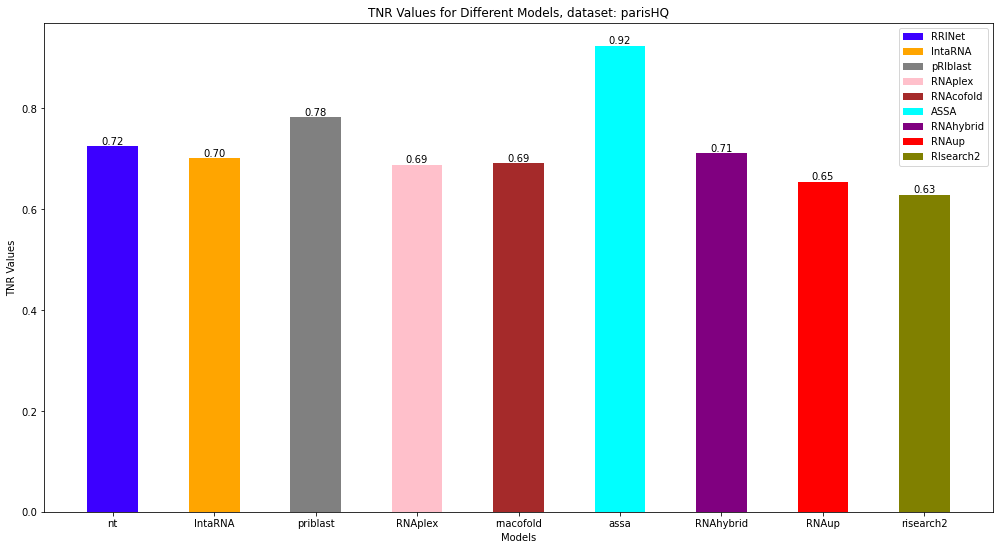

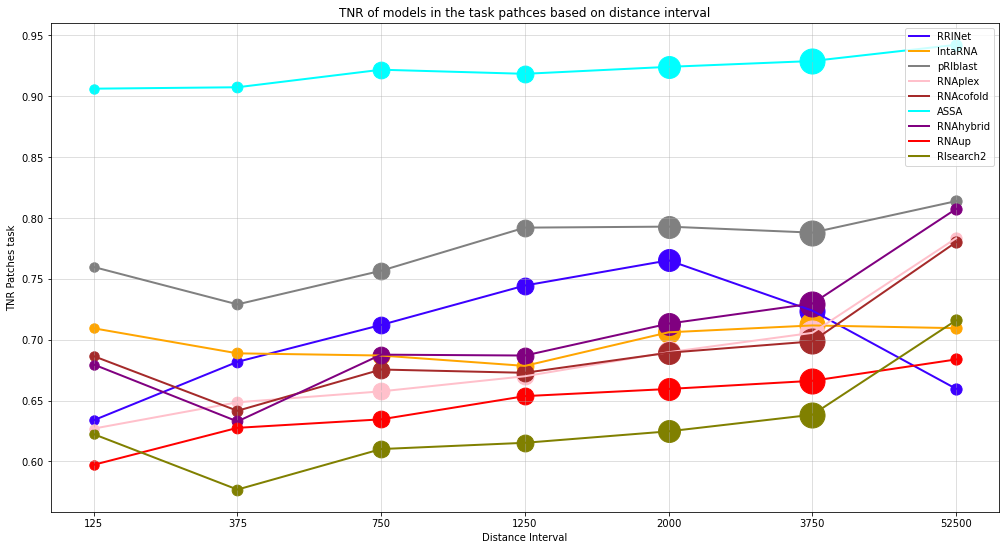

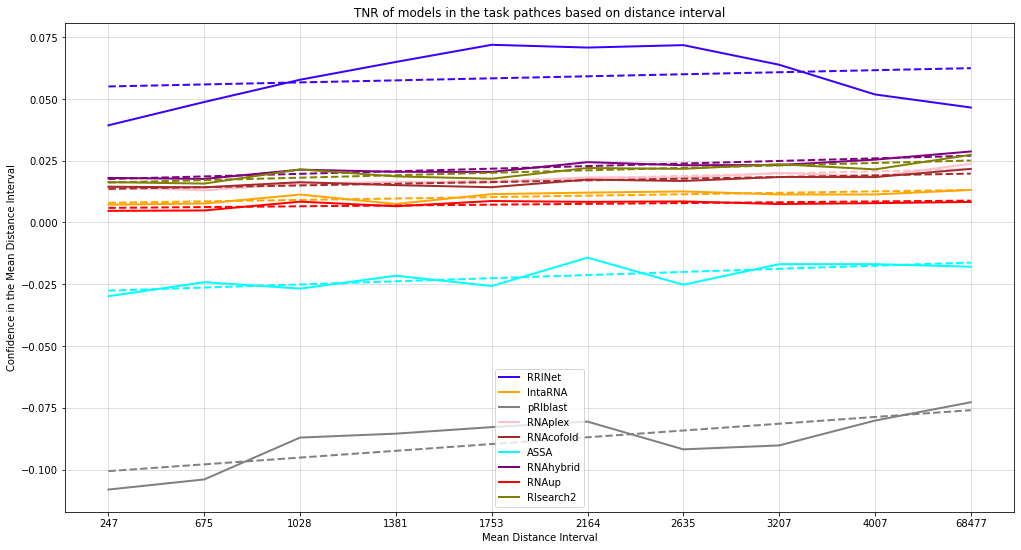

---------- DATASET: paris_mouse_HQ ----------


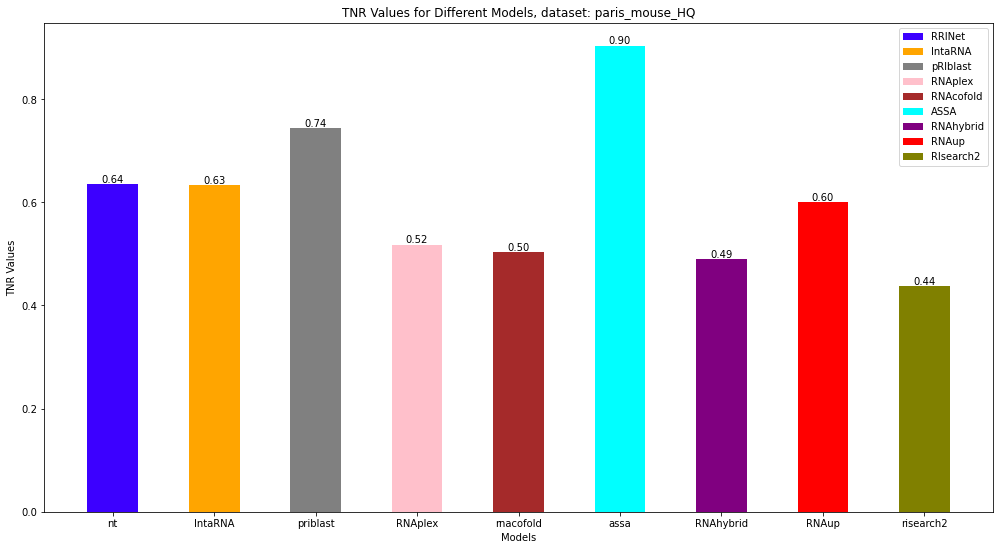

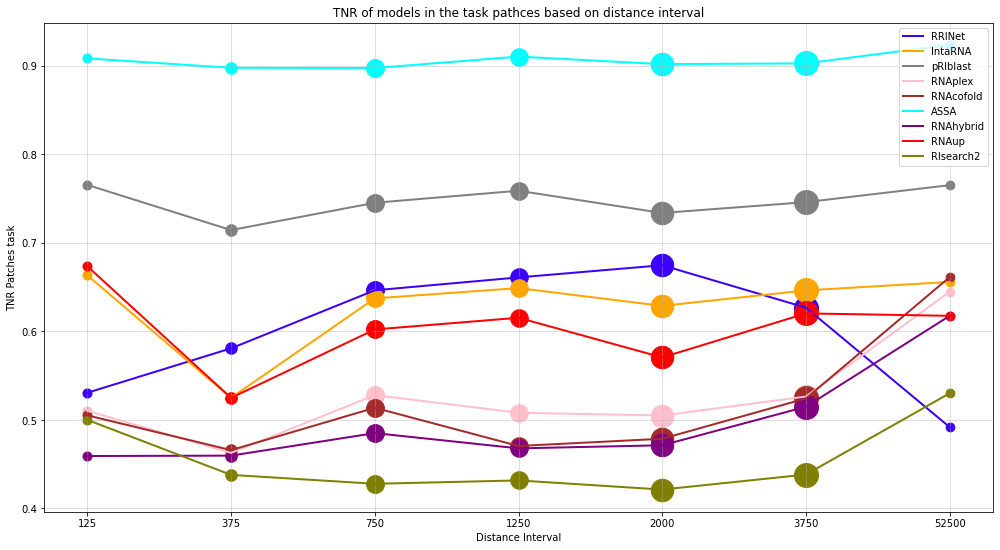

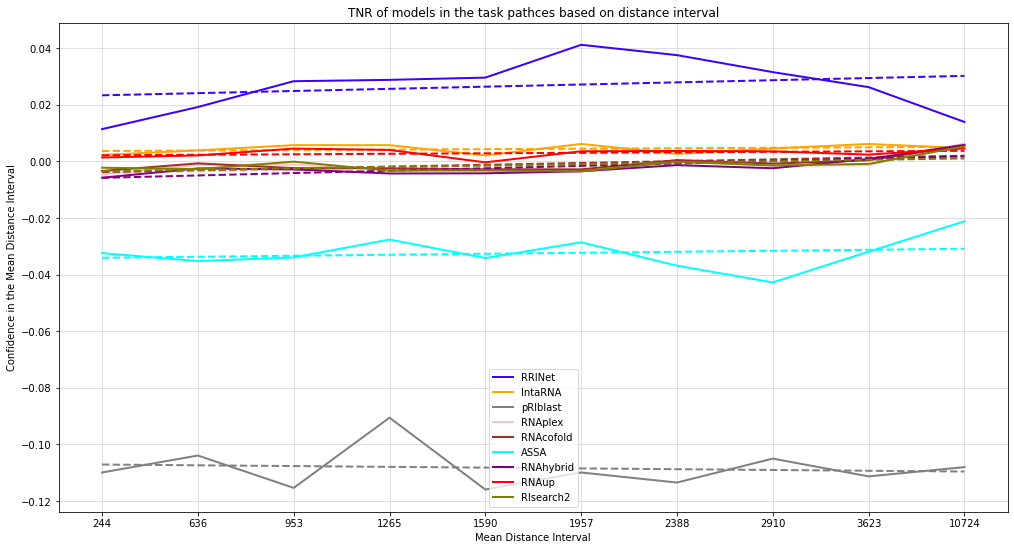

---------- DATASET: ricseqHQ ----------


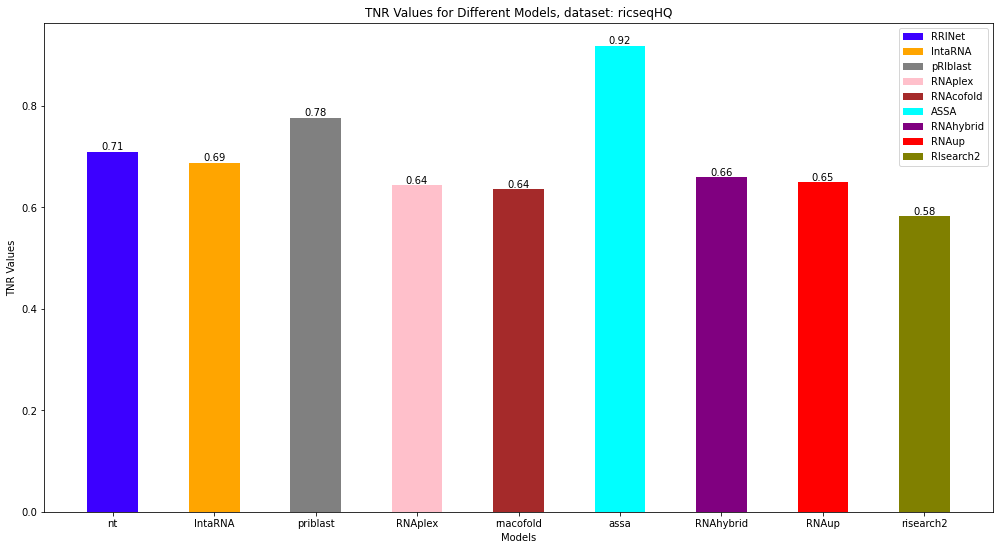

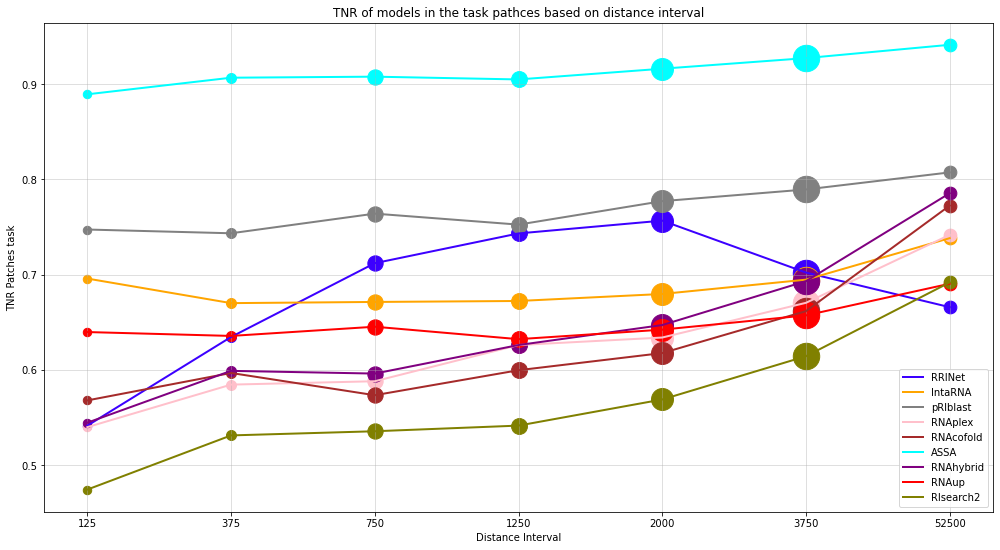

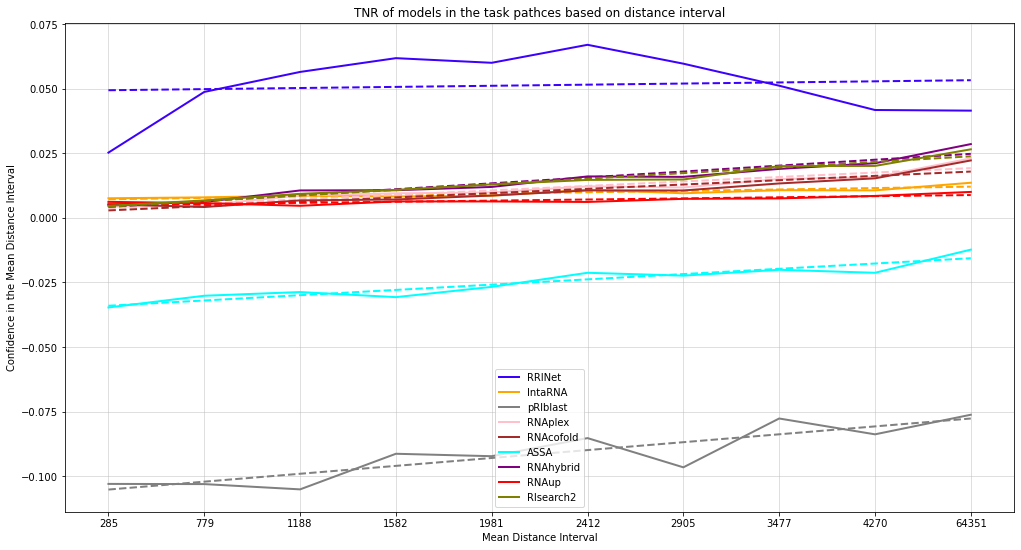

---------- DATASET: psoralen ----------


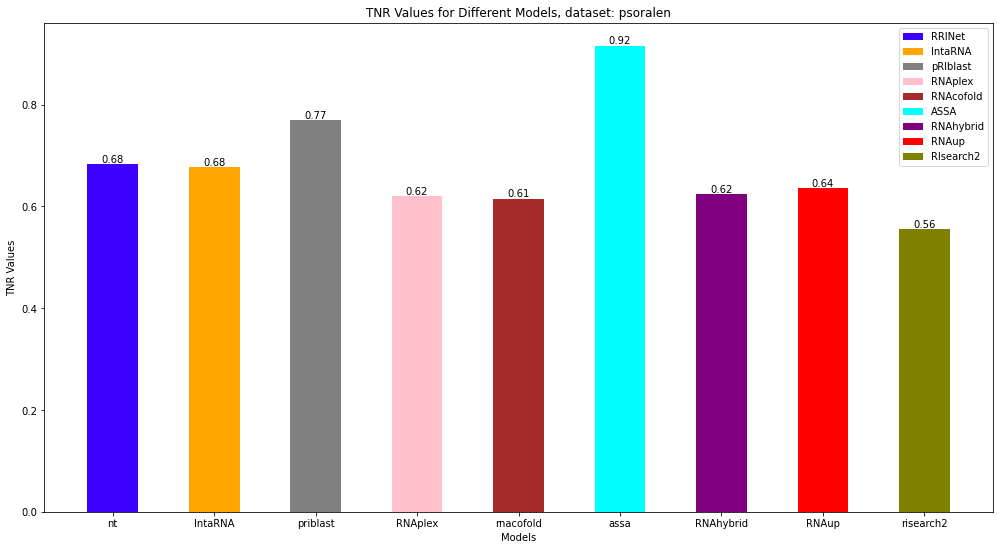

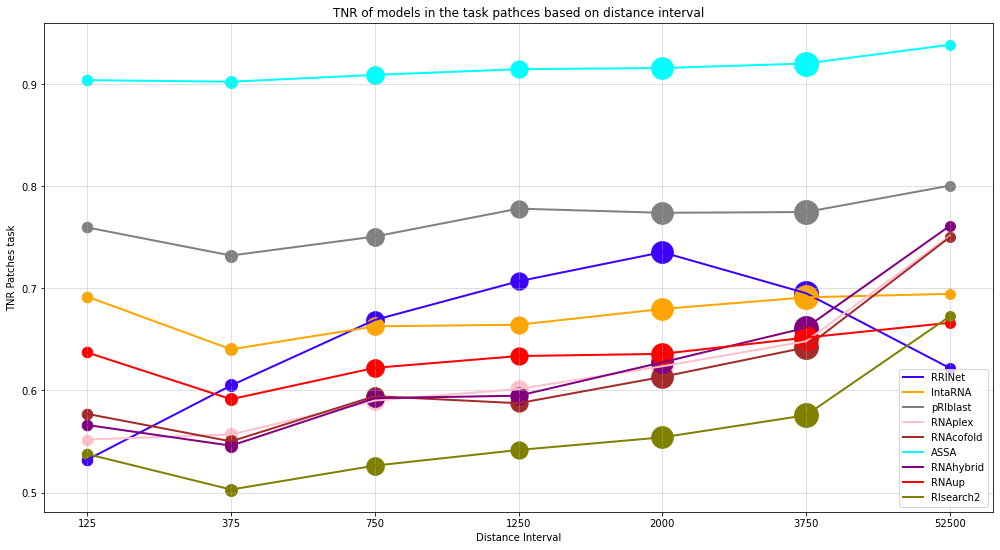

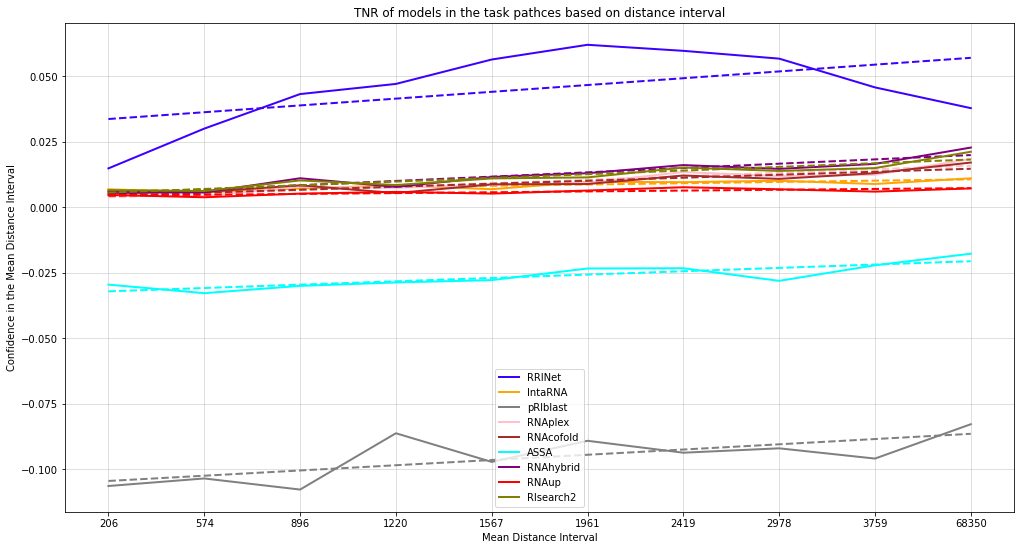

---------- DATASET: paris ----------


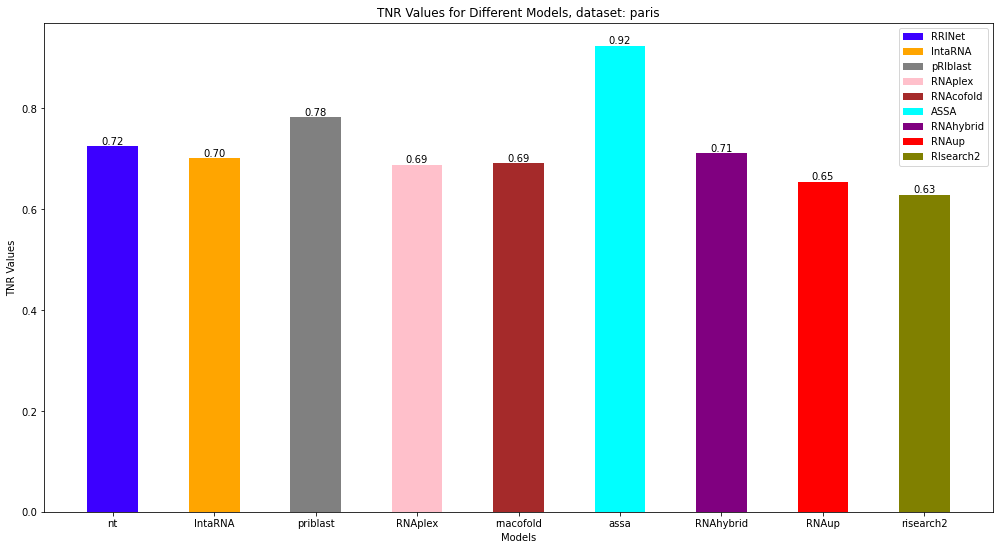

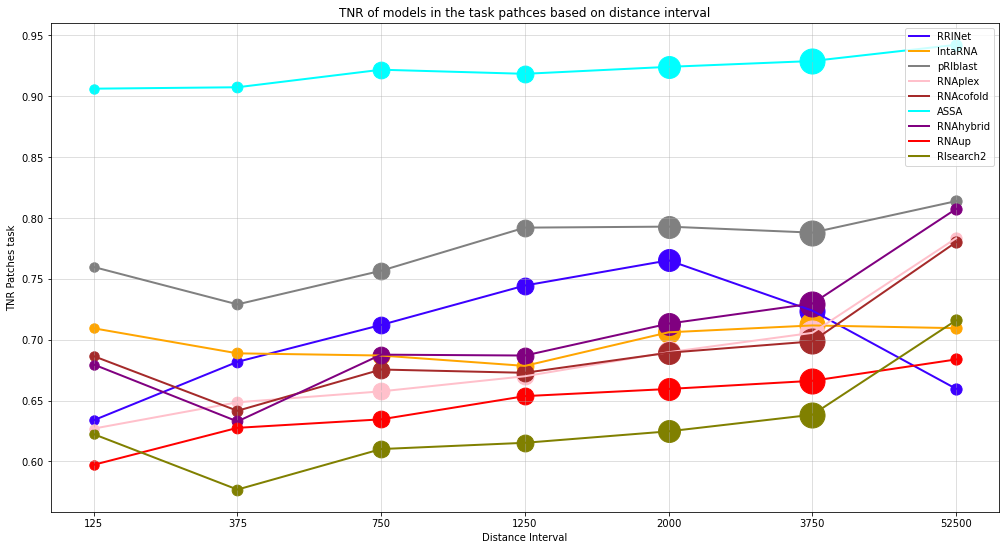

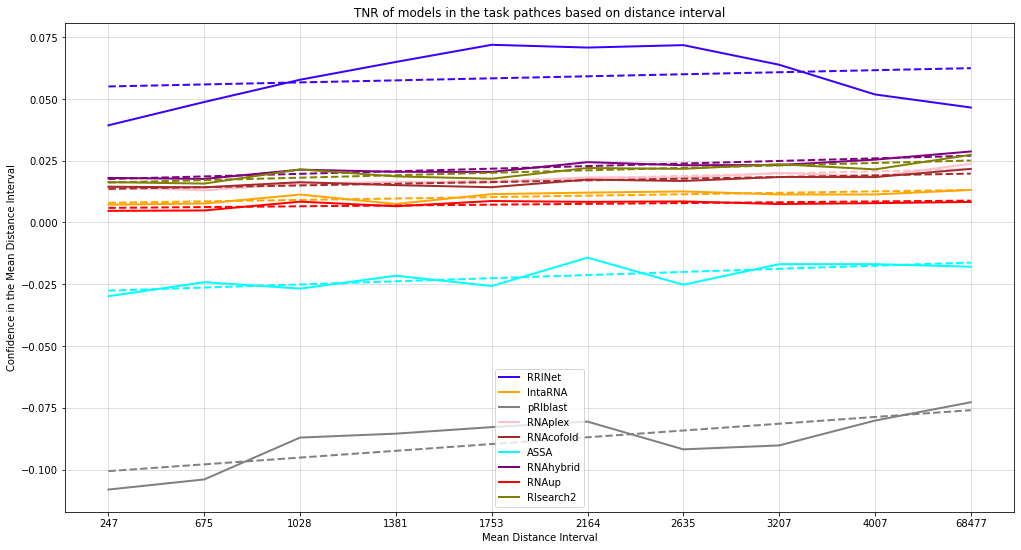

---------- DATASET: paris_mouse ----------


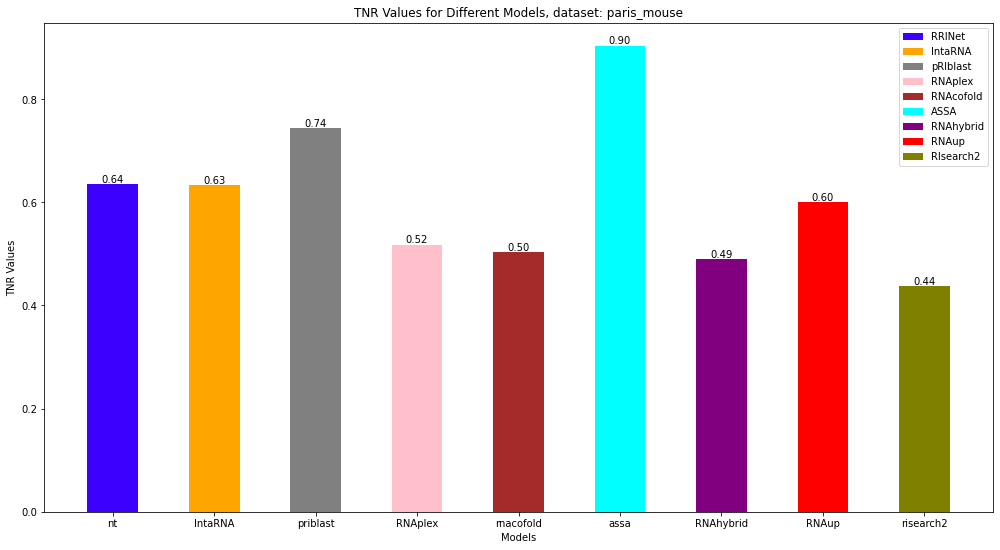

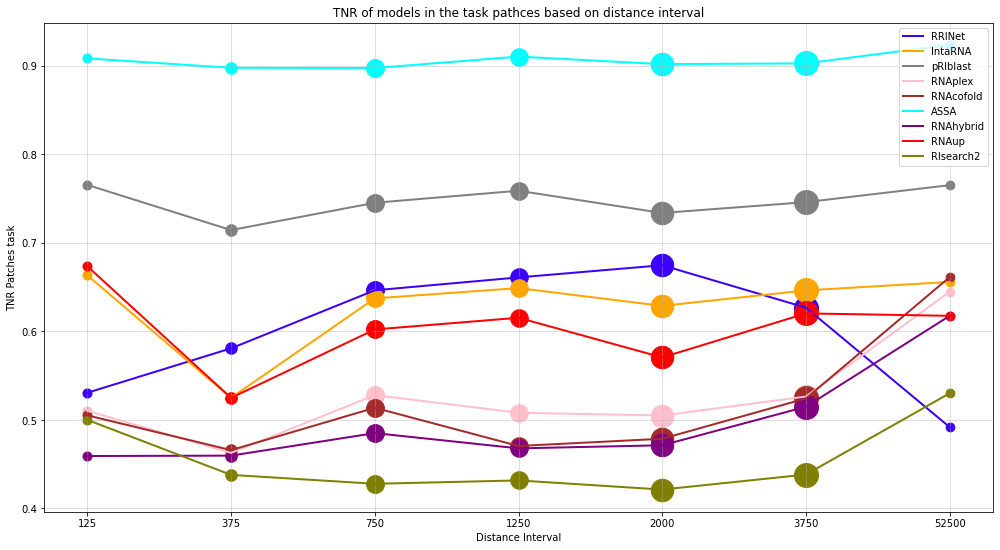

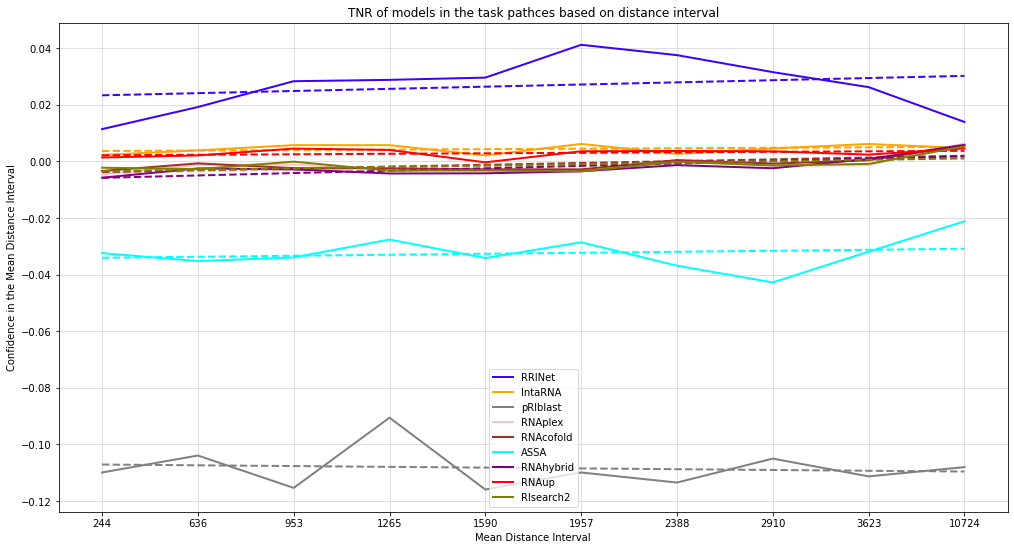

---------- DATASET: ricseq ----------


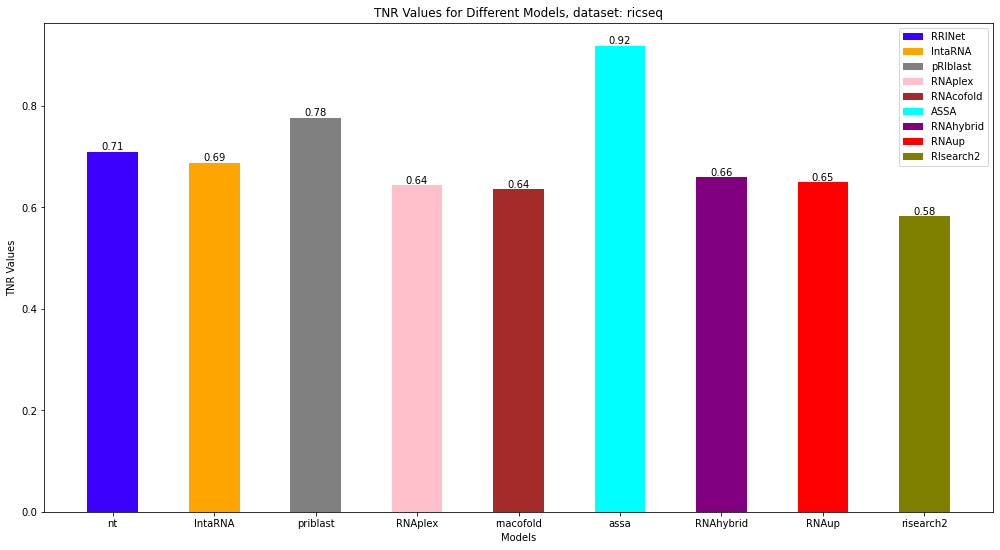

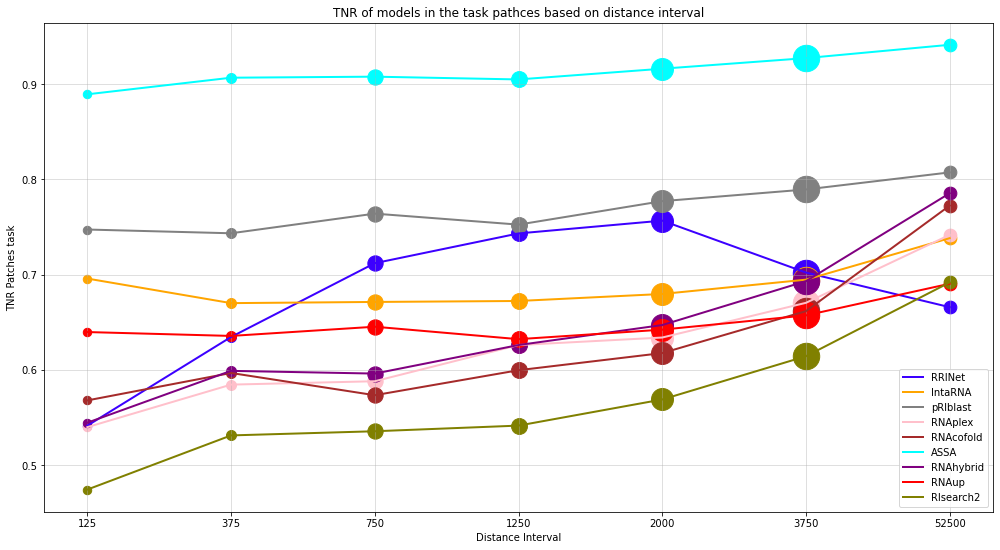

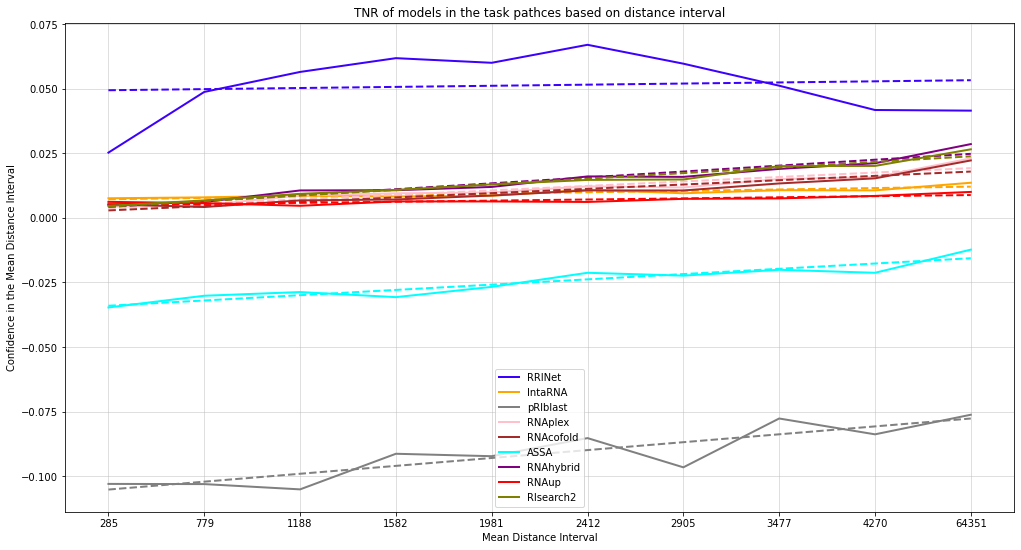

---------- DATASET: mario ----------


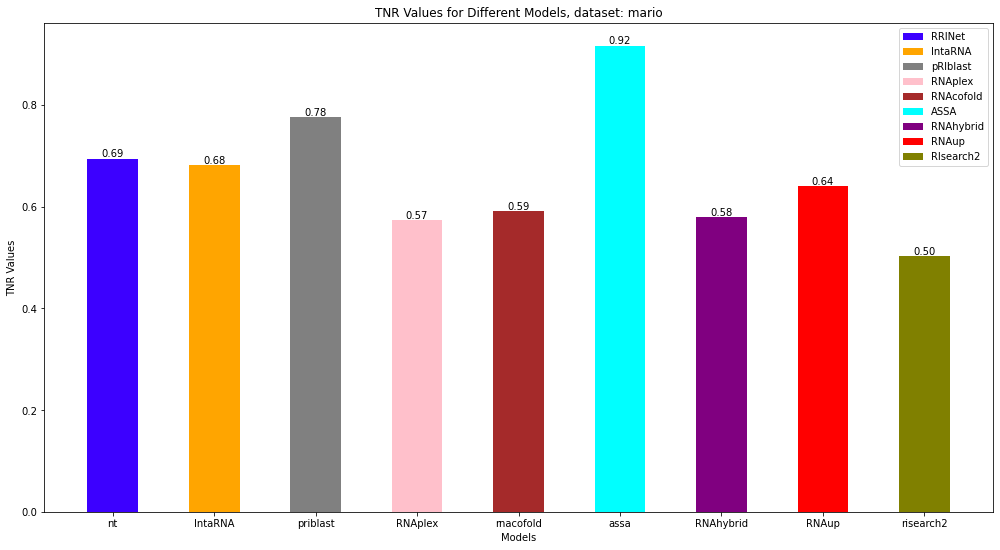

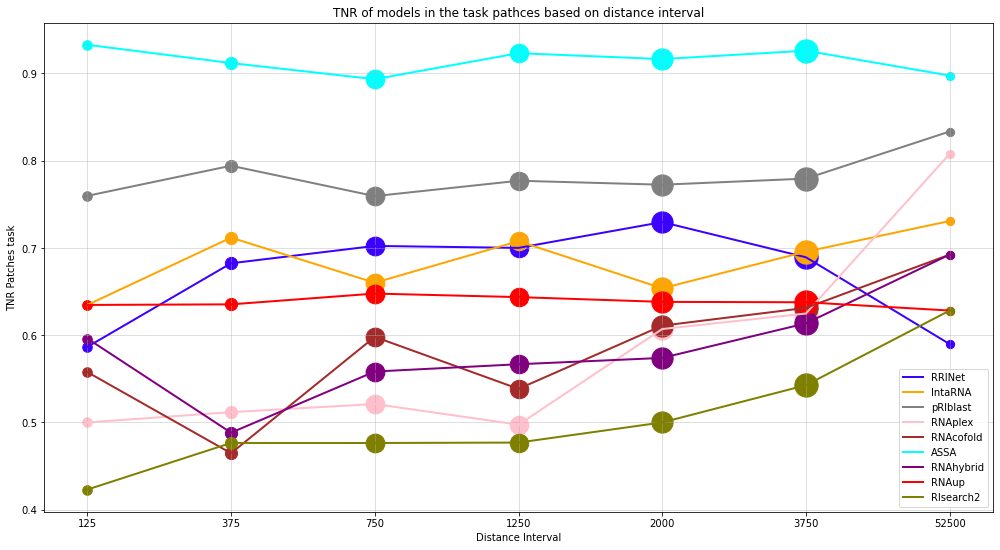

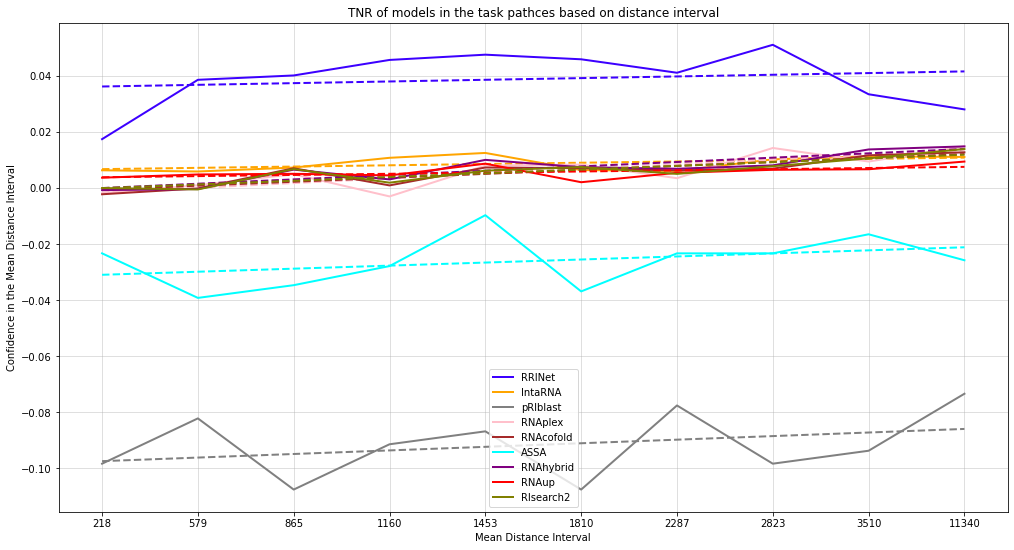

---------- DATASET: splash ----------


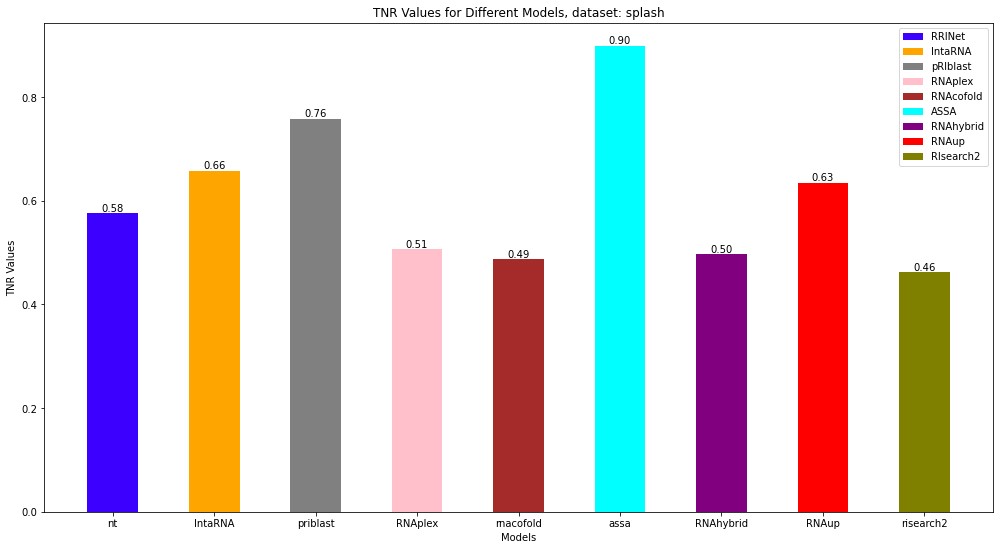

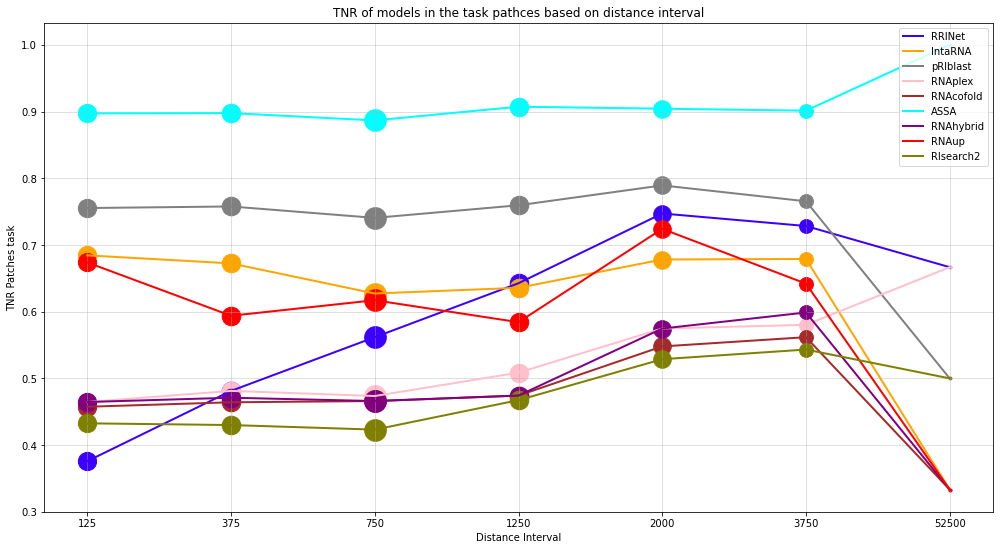

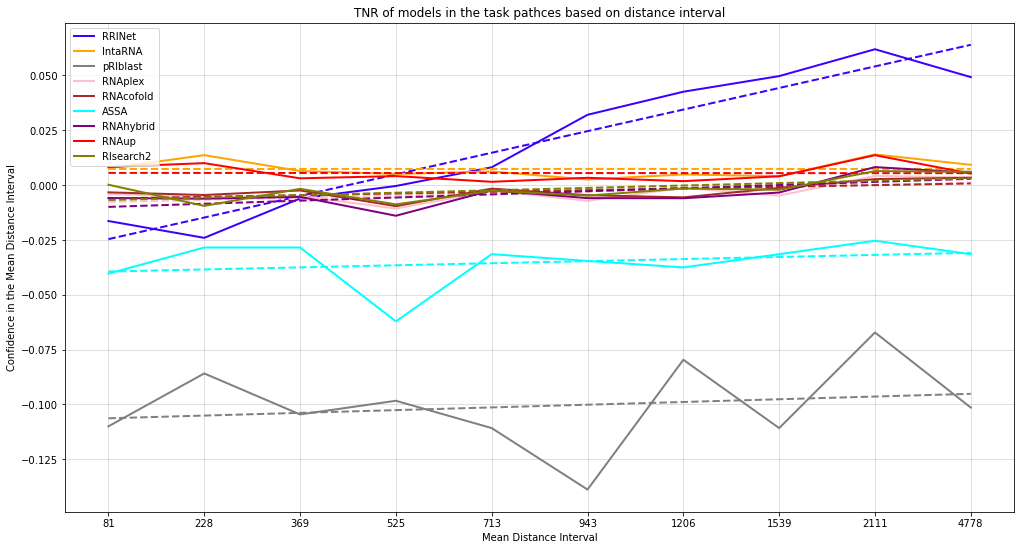

In [14]:
figsize = (17, 9)
size_multiplier = 20
bins_distance = [[1, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]

for dataset in list_of_datasets:
    
    print(f'---------- DATASET: {dataset} ----------')
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq = map_dataset_to_hp(dataset)
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = paris_hq_threshold,
        paris_hq_threshold = paris_hq_threshold,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
        
    subset_to_plot = res[res.policy.isin(['easyneg', 'hardneg'])].reset_index(drop = True)
    
    
    plot_tnr_for_all_models(list_of_models_to_test, #['nt']
                            subset_to_plot, 
                            figsize = figsize, 
                            title_suffix = f'dataset: {dataset}', 
                            bar_width = 0.5
                           )

    plot_tnr_based_on_distance_for_all_models(subset_to_plot,
                                              bins_distance,
                                              list_of_models_to_test, #['nt']
                                              figsize=figsize, 
                                              size_multiplier = size_multiplier
                                             )

    bins_distance_quantile = quantile_bins(subset_to_plot.distance_from_site, 10)
    plot_confidence_based_on_distance_for_all_models(subset_to_plot, 
                                                     bins_distance_quantile, 
                                                     list_of_models_to_test, #['nt']
                                                     figsize)

### Plots based on top-bottom

In [15]:
#plot parameters
n_values = 5
figsize = (17,9)
size_multiplier = 10

MIN_PERC = 5
list_of_metrics = ['precision', 'npv'] #['f1','precision', 'npv'] #[['f1','precision', 'npv', 'recall', 'specificity', 'precision_recall_curve']
balance_predictions_at_each_step=False

#### Patches / Intectors

parisHQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


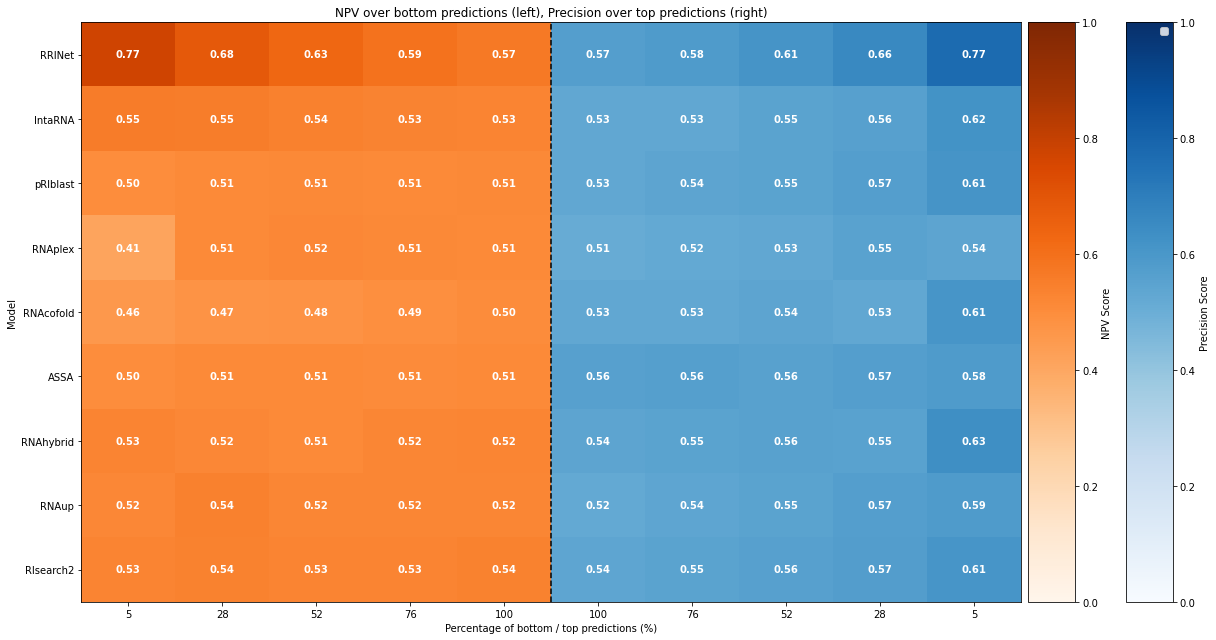

parisHQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


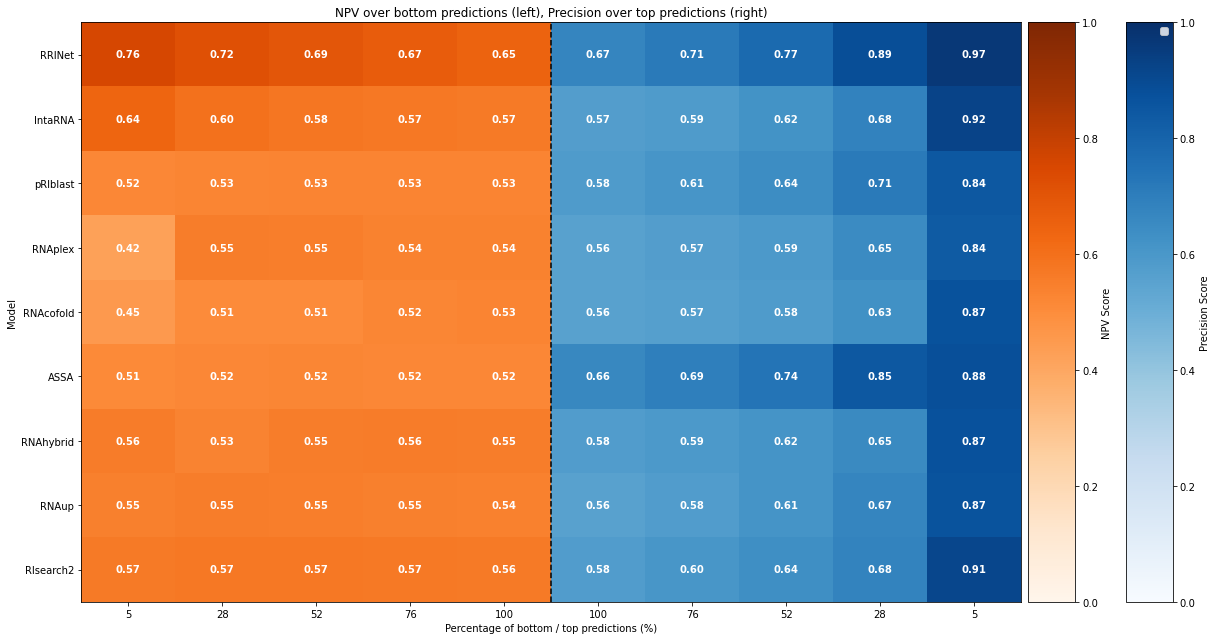

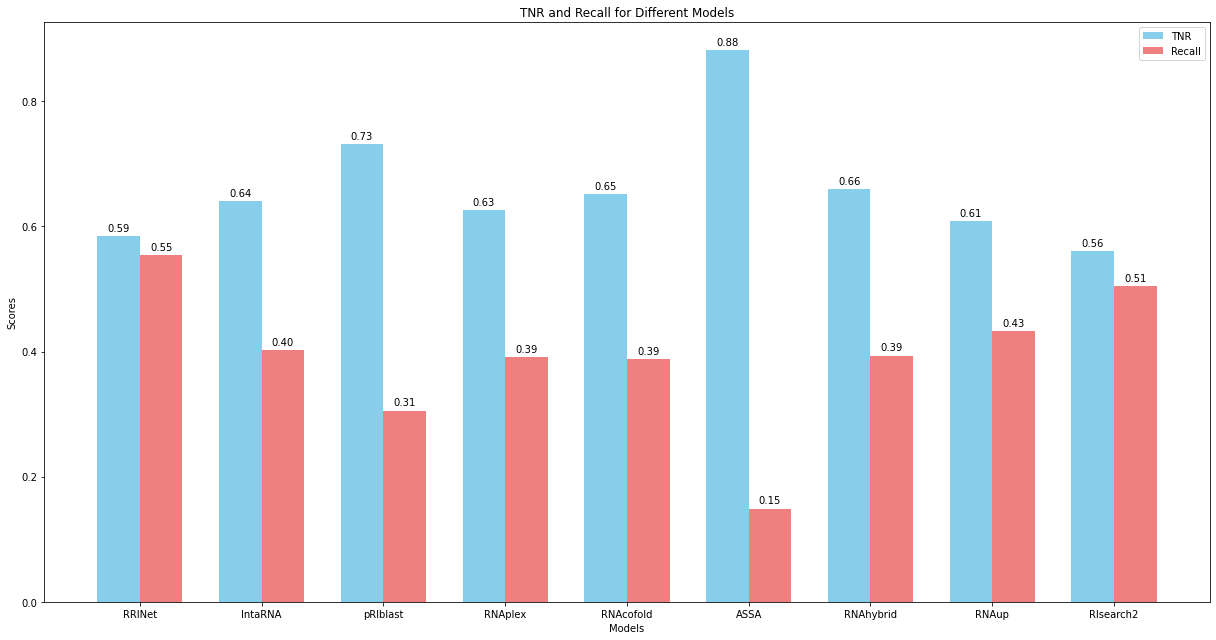

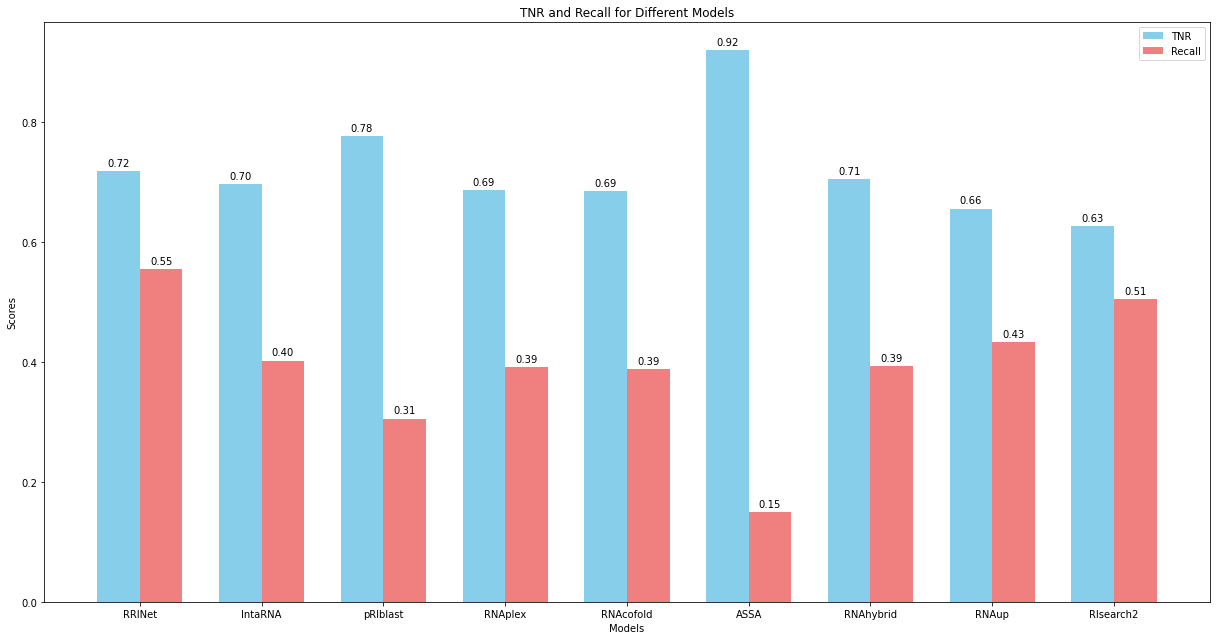

paris_mouse_HQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


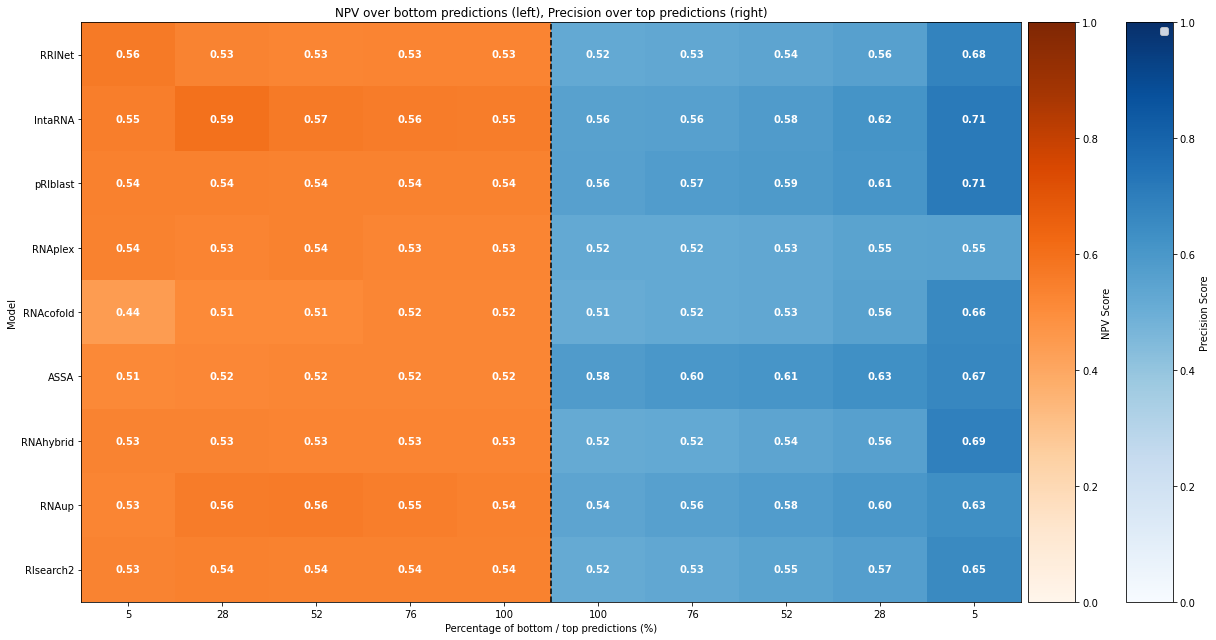

paris_mouse_HQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


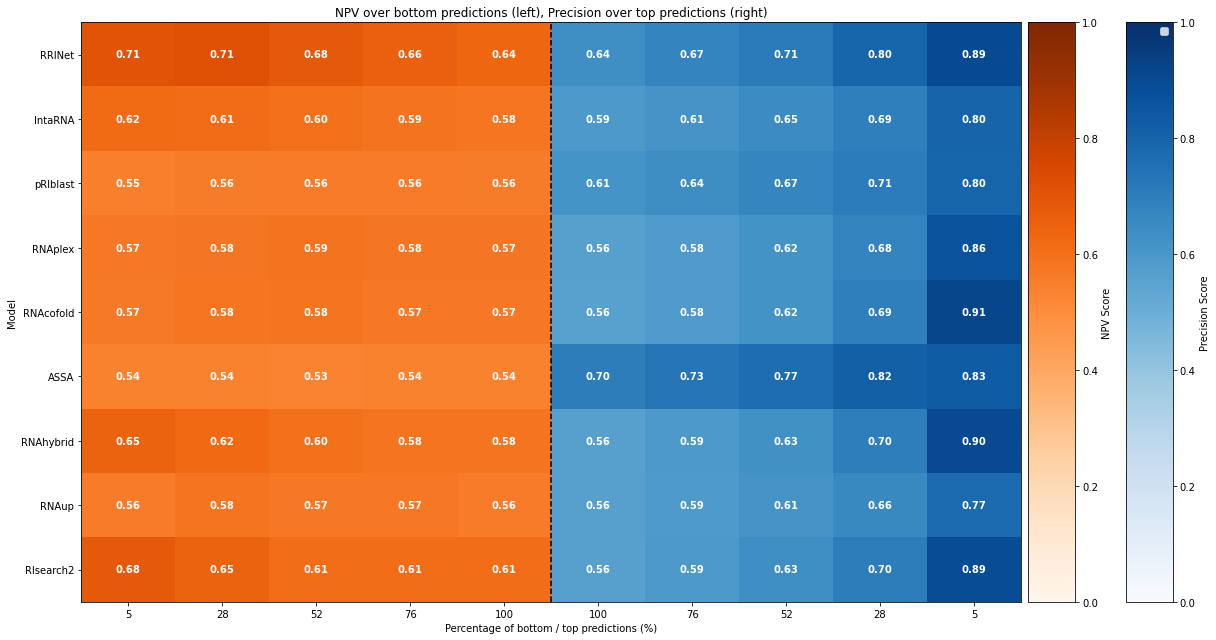

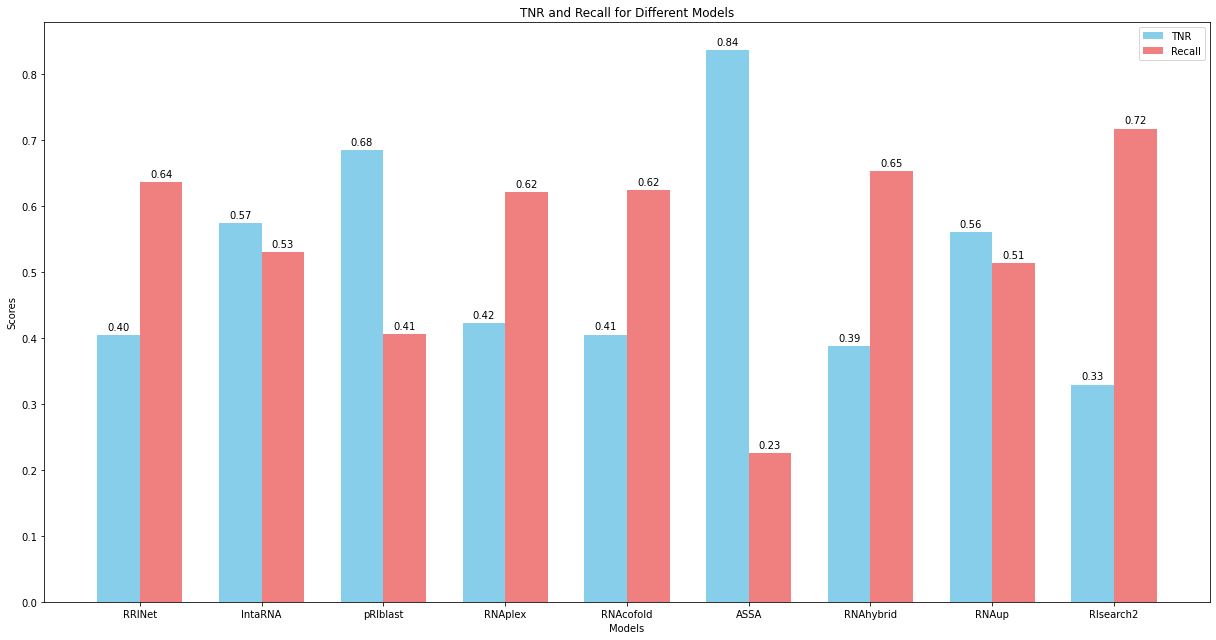

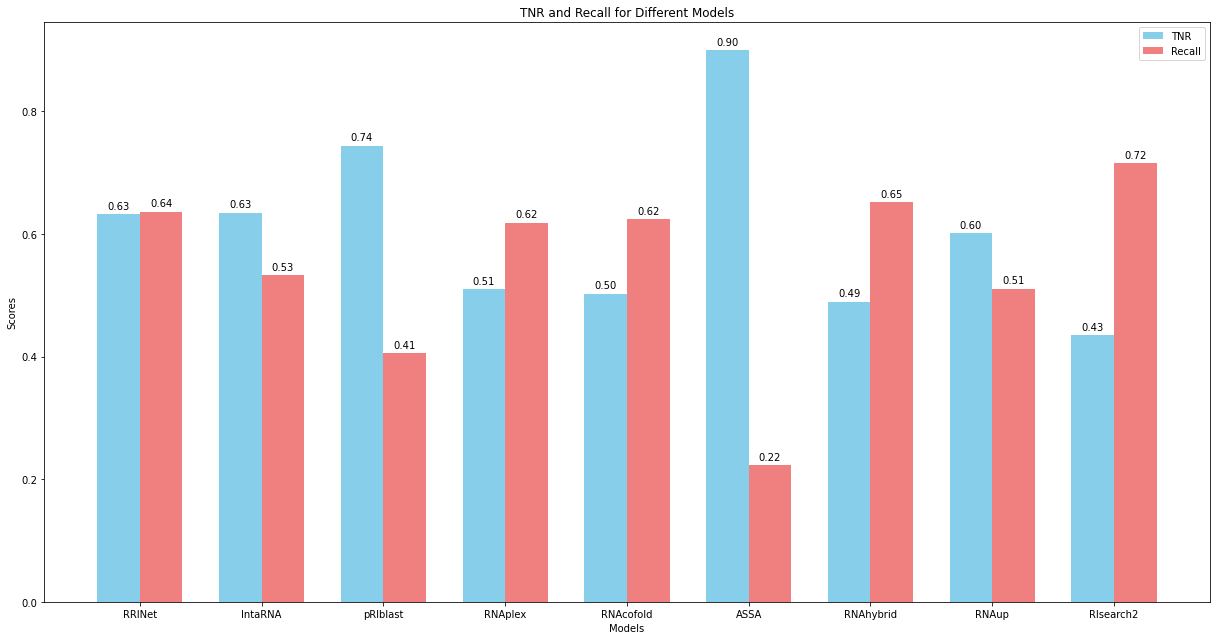

ricseqHQ interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


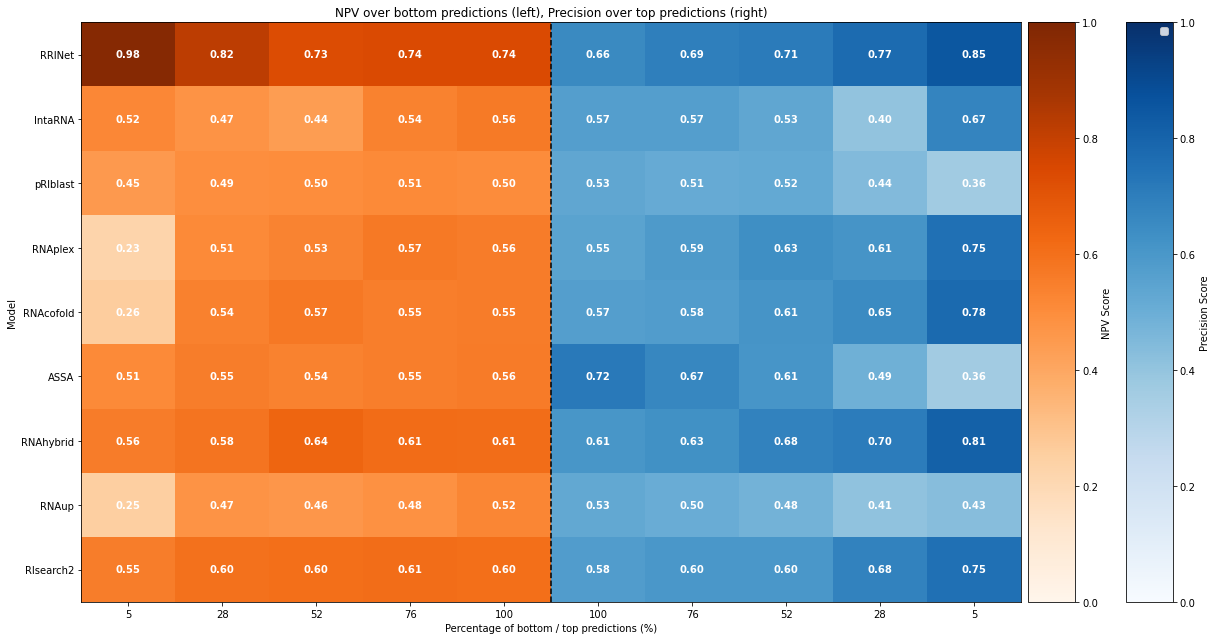

ricseqHQ patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


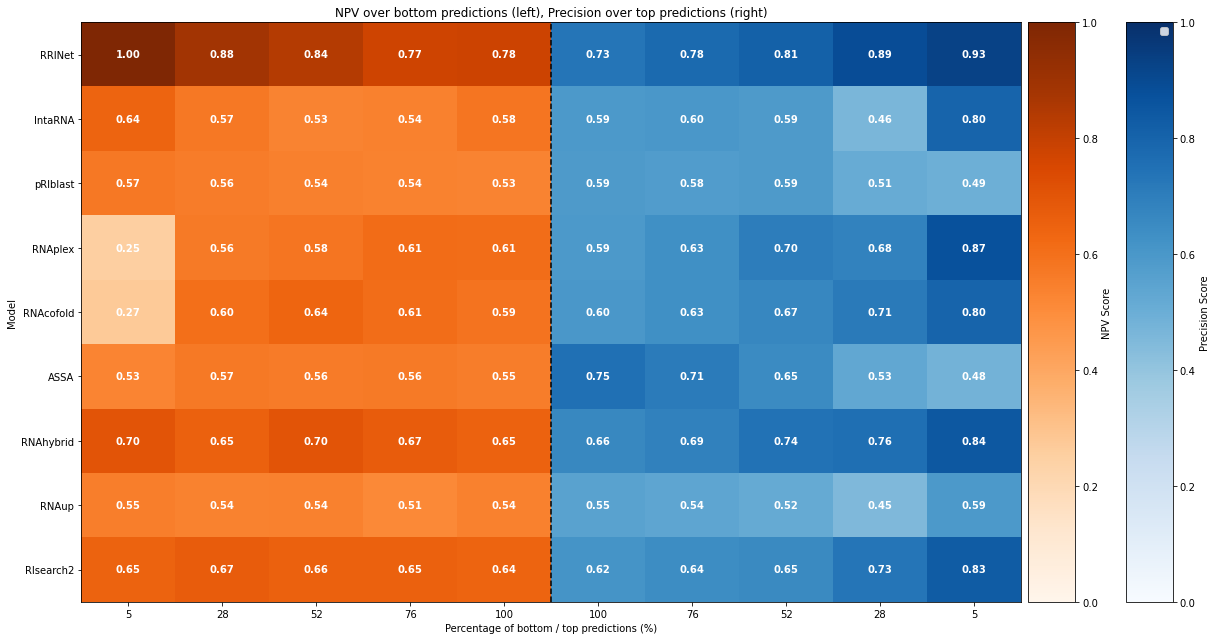

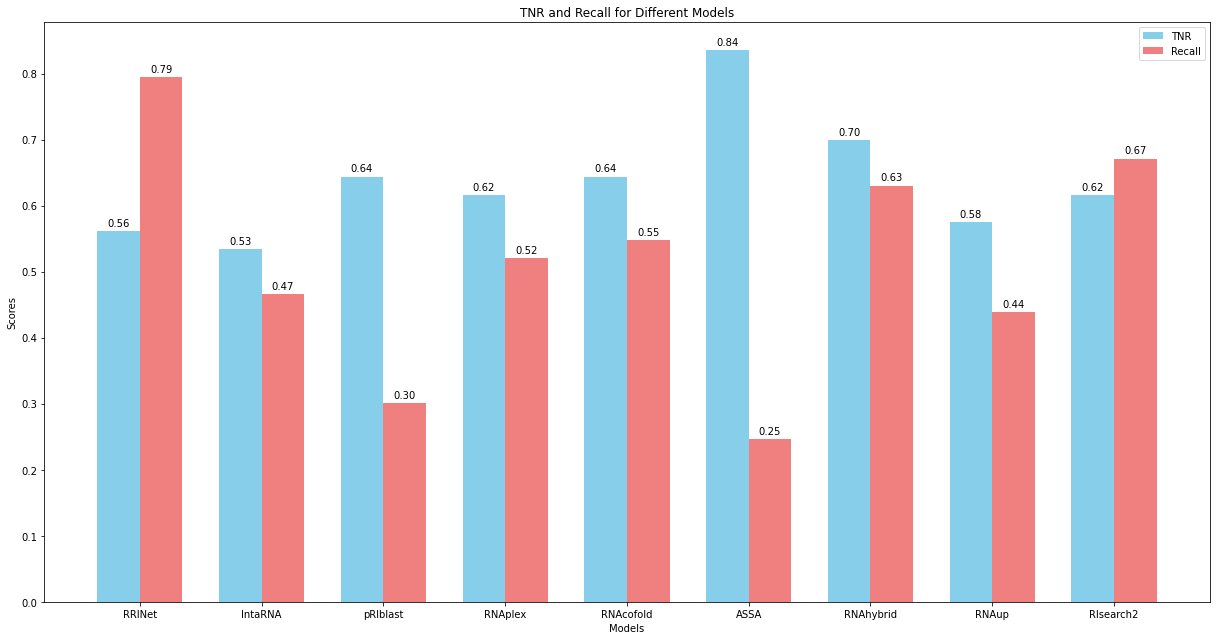

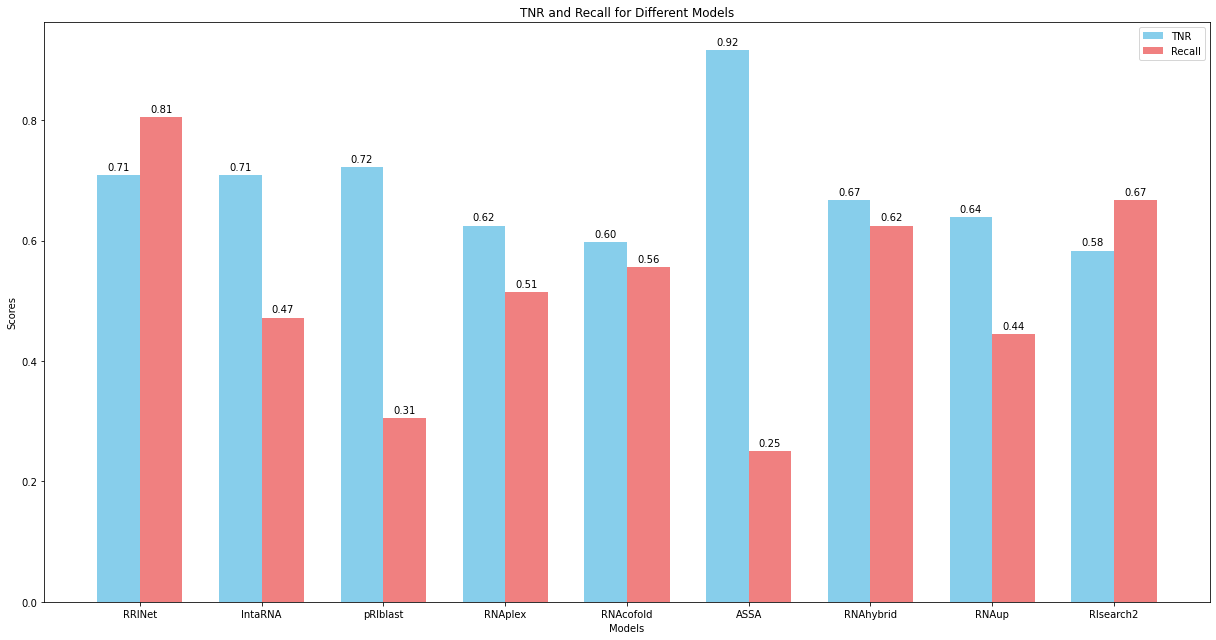

psoralen interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


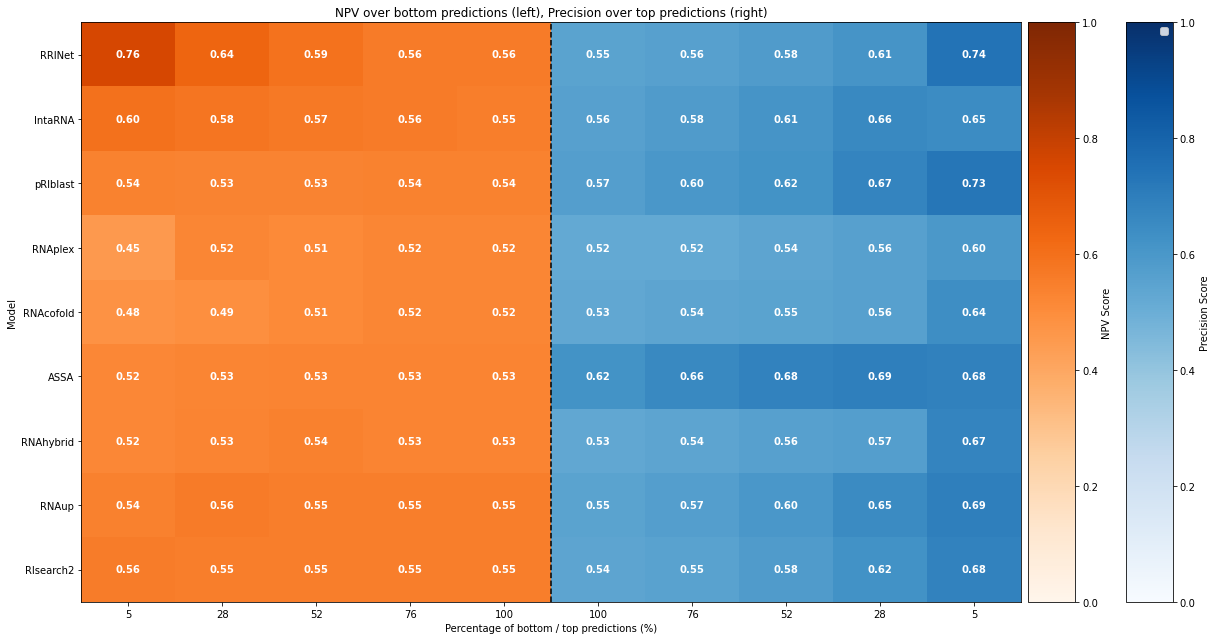

psoralen patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


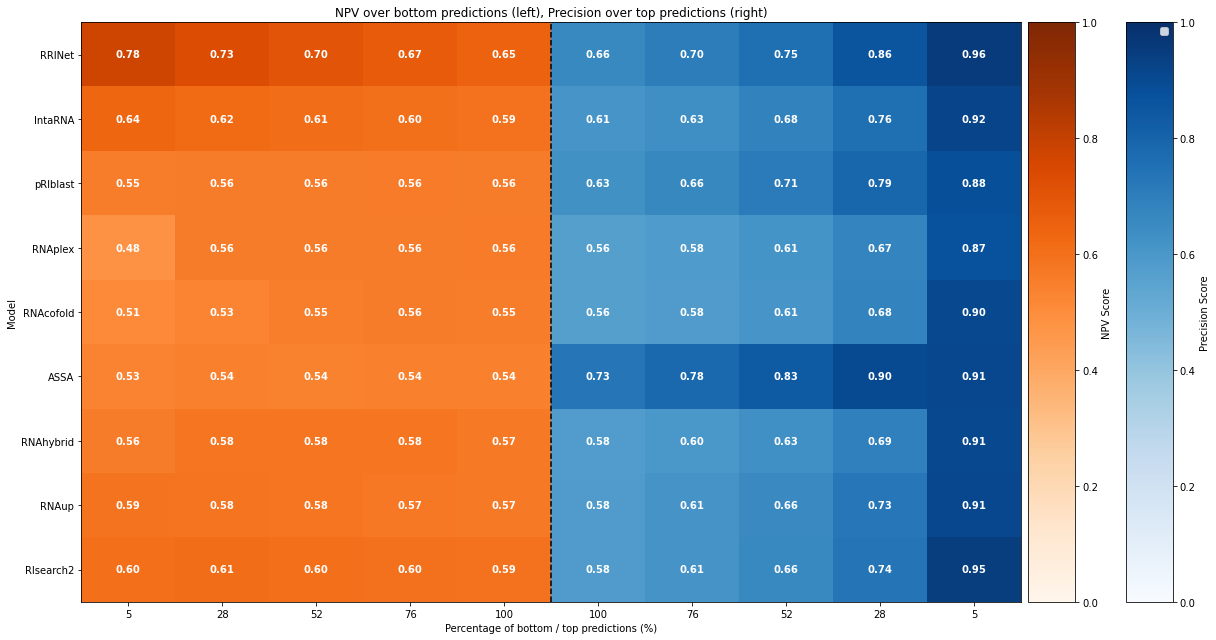

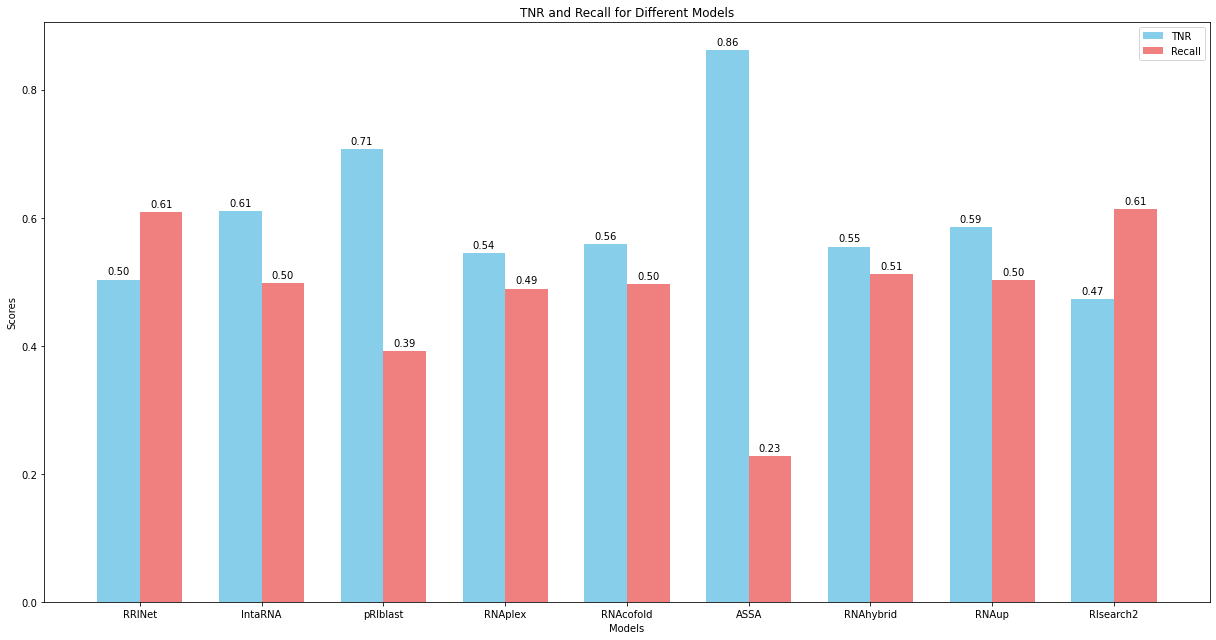

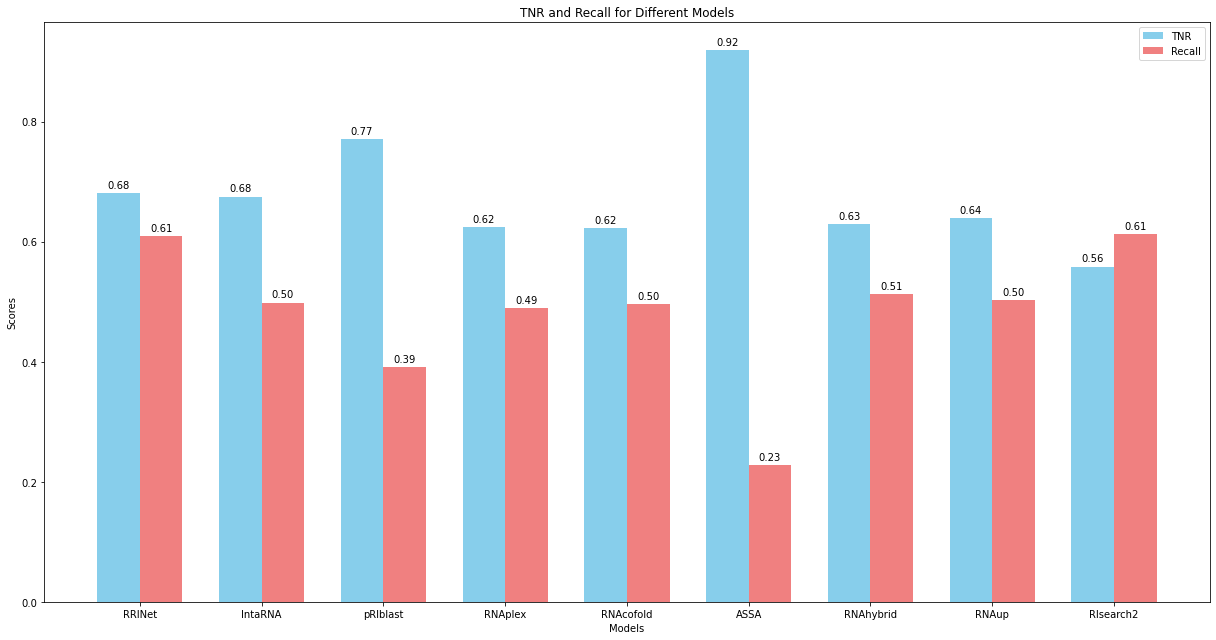

paris interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


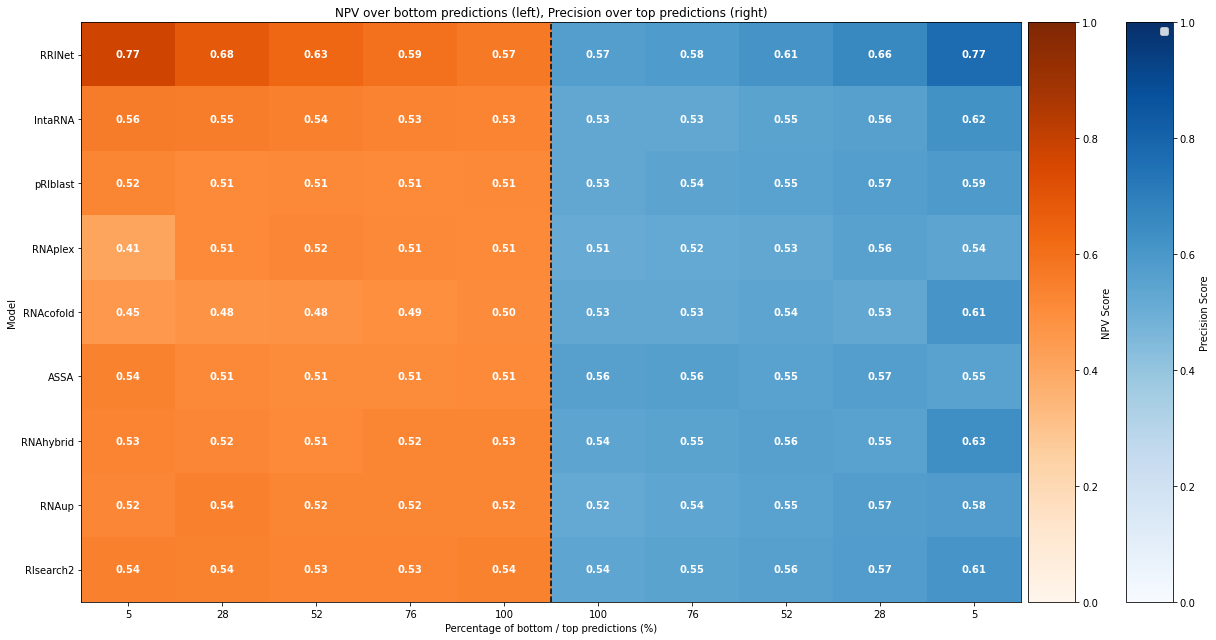

paris patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


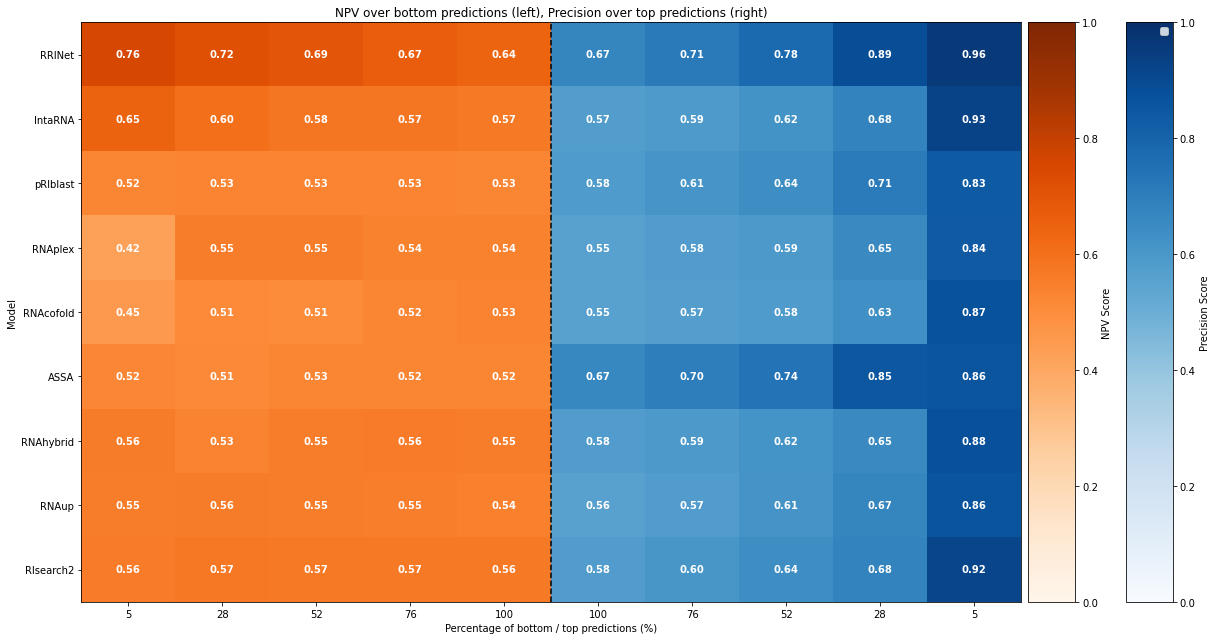

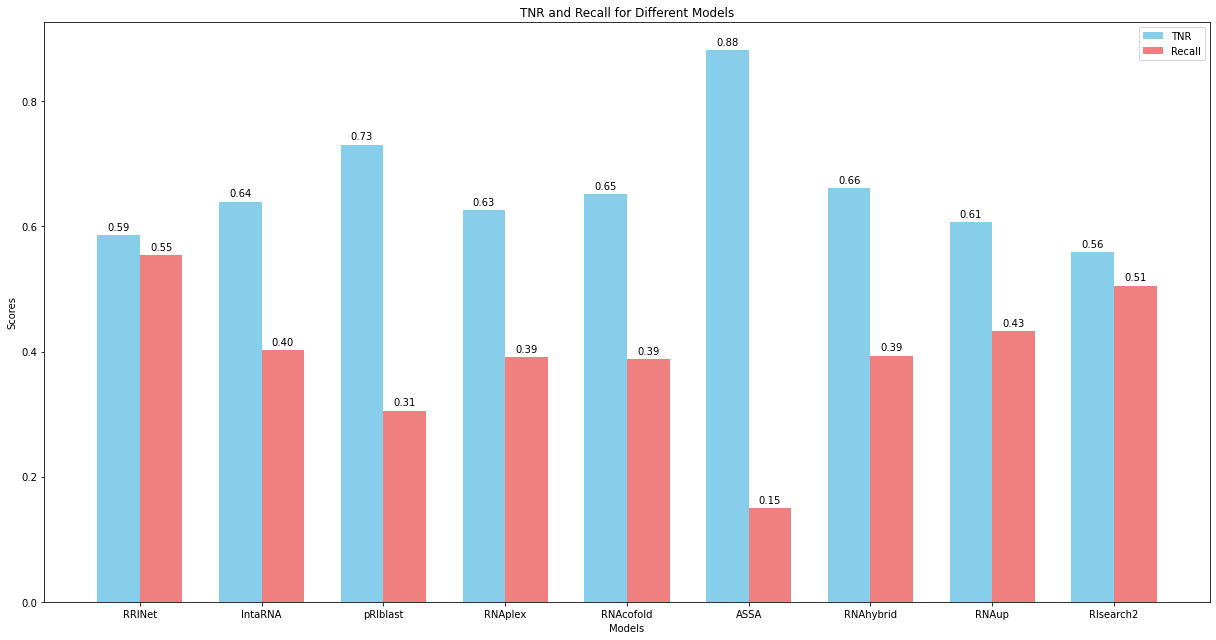

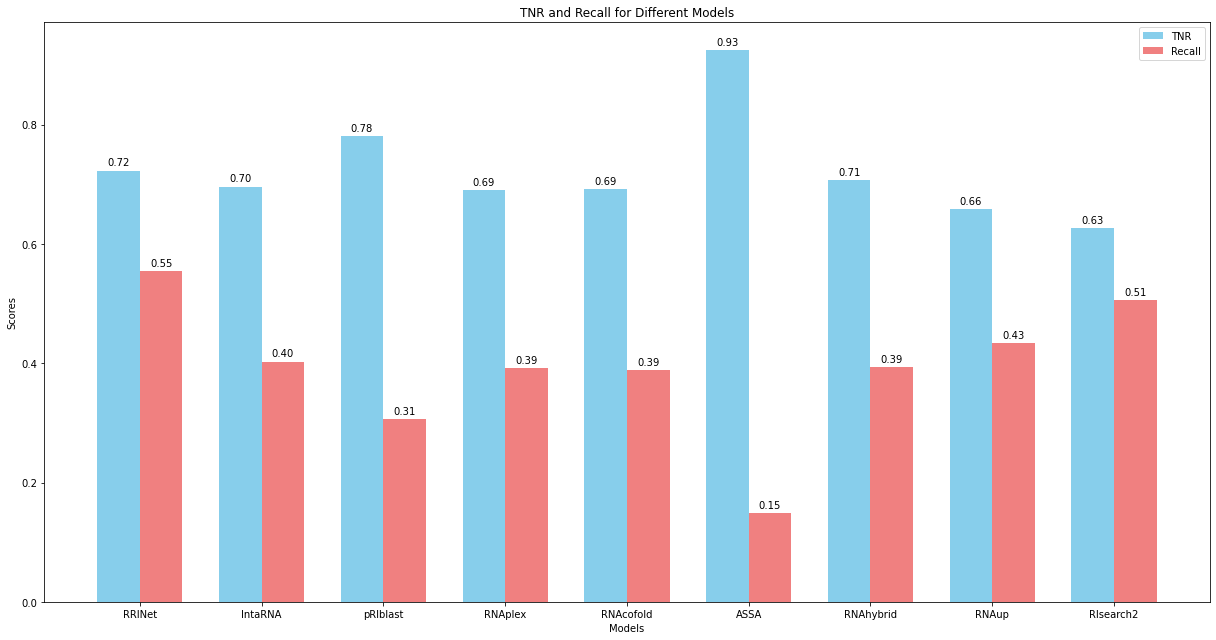

paris_mouse interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


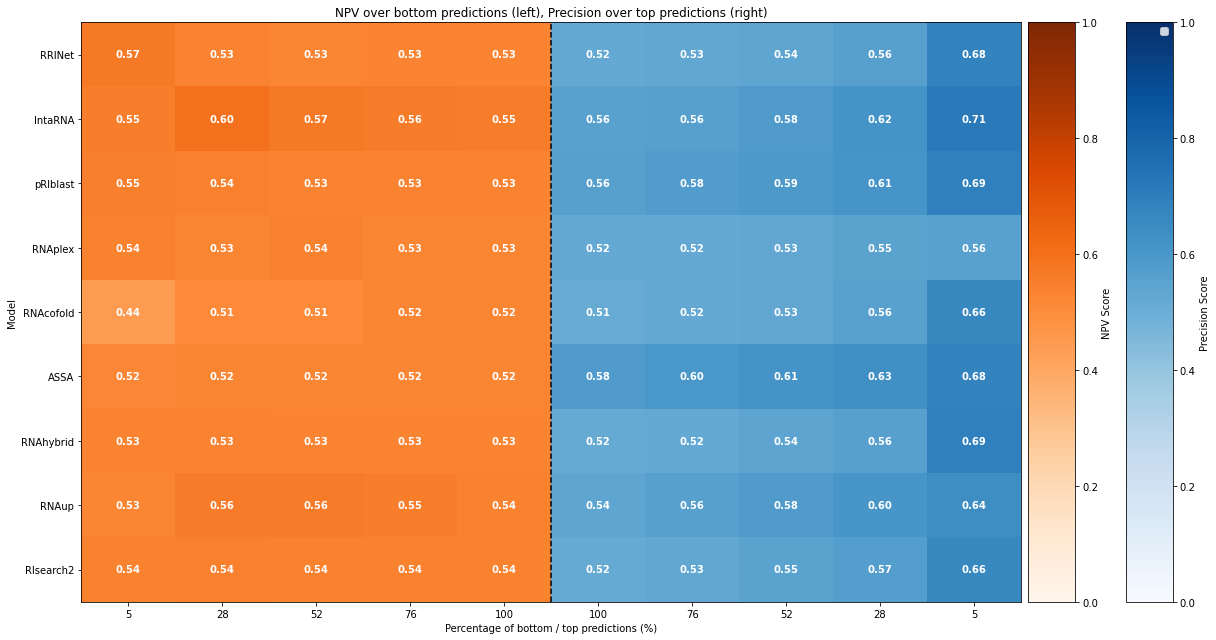

paris_mouse patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


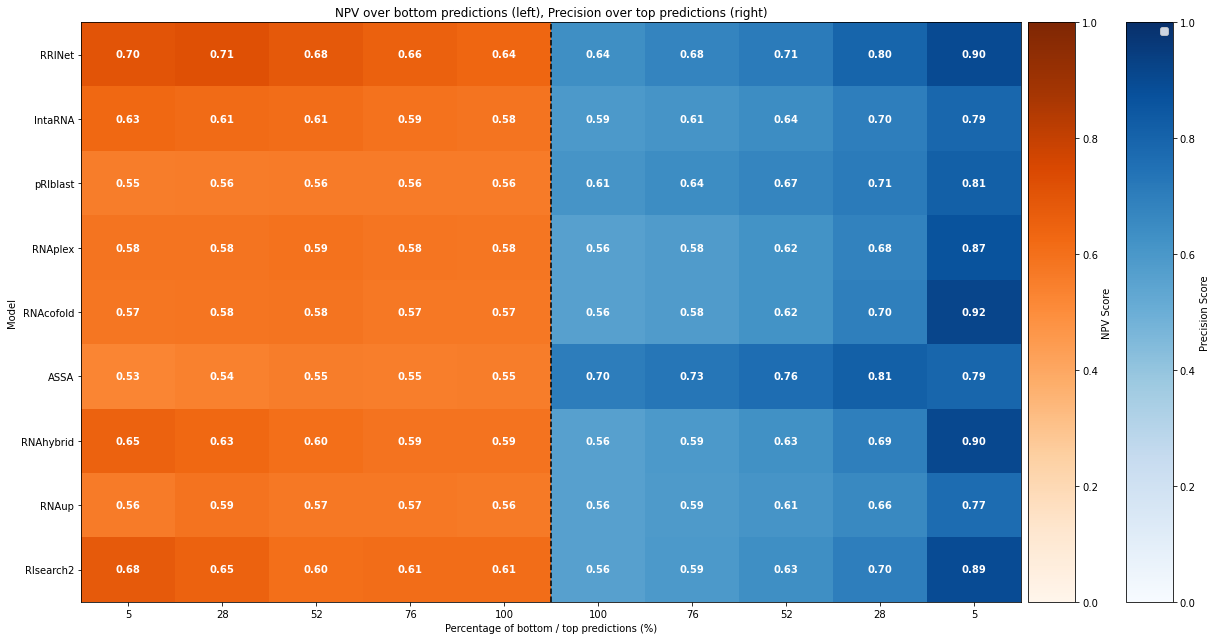

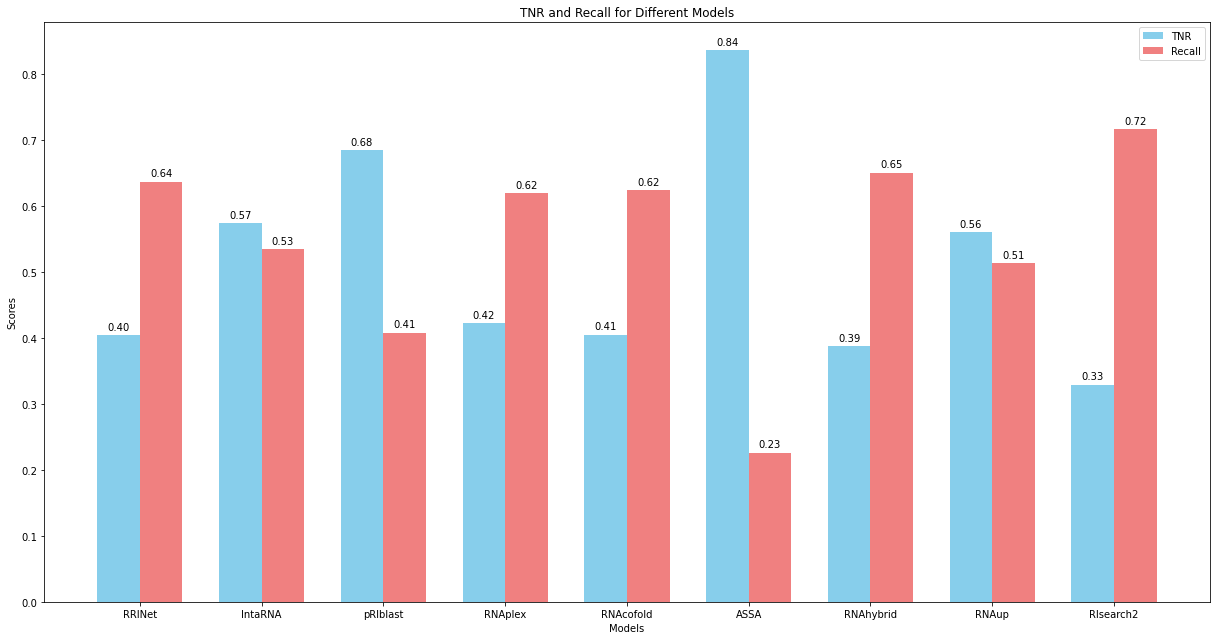

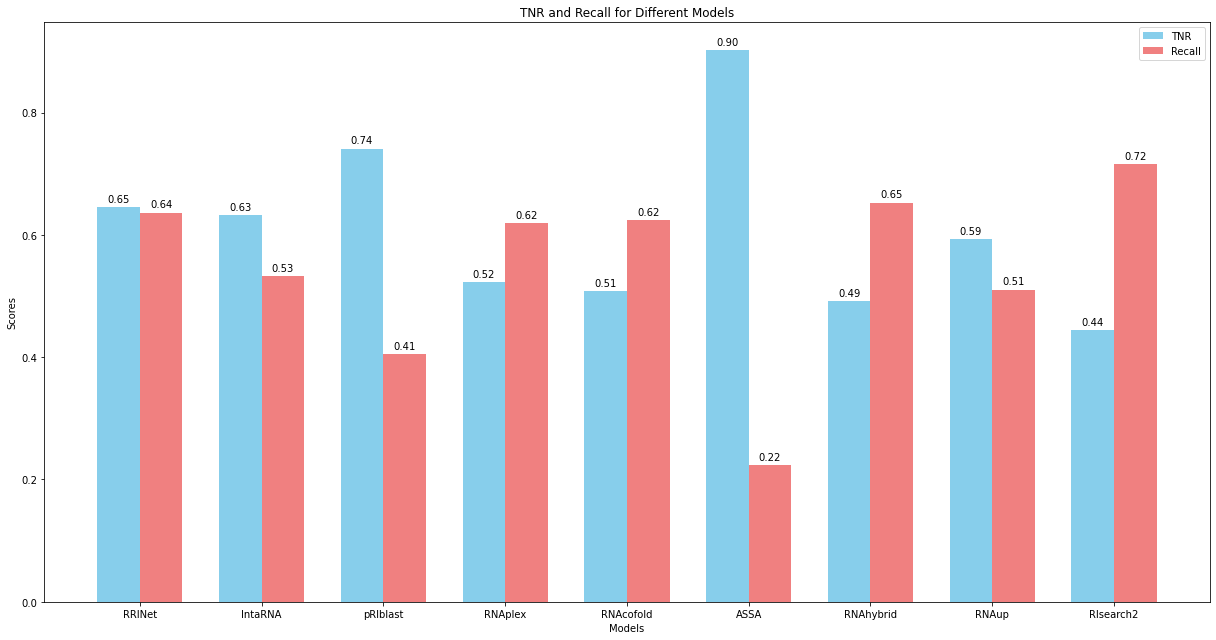

ricseq interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


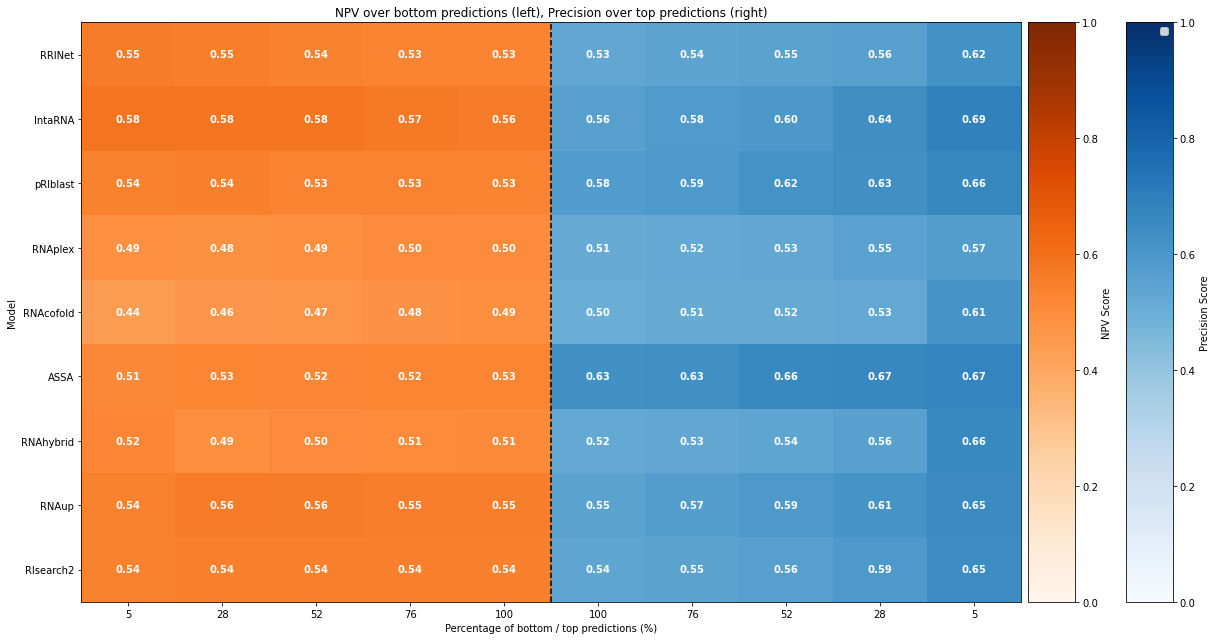

ricseq patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


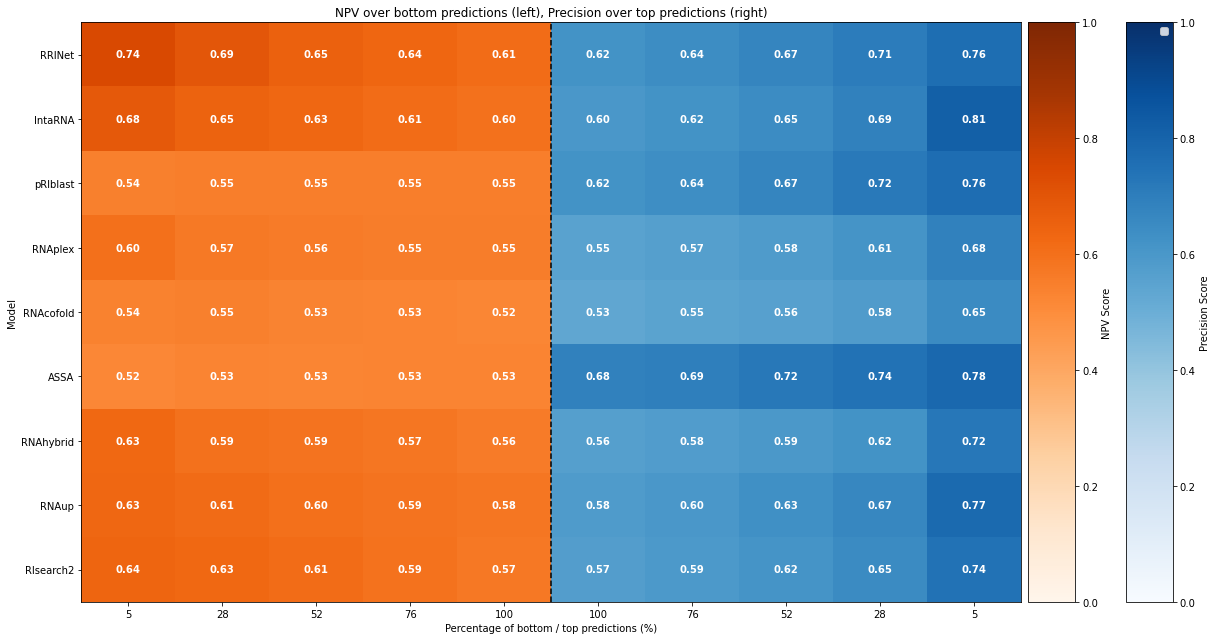

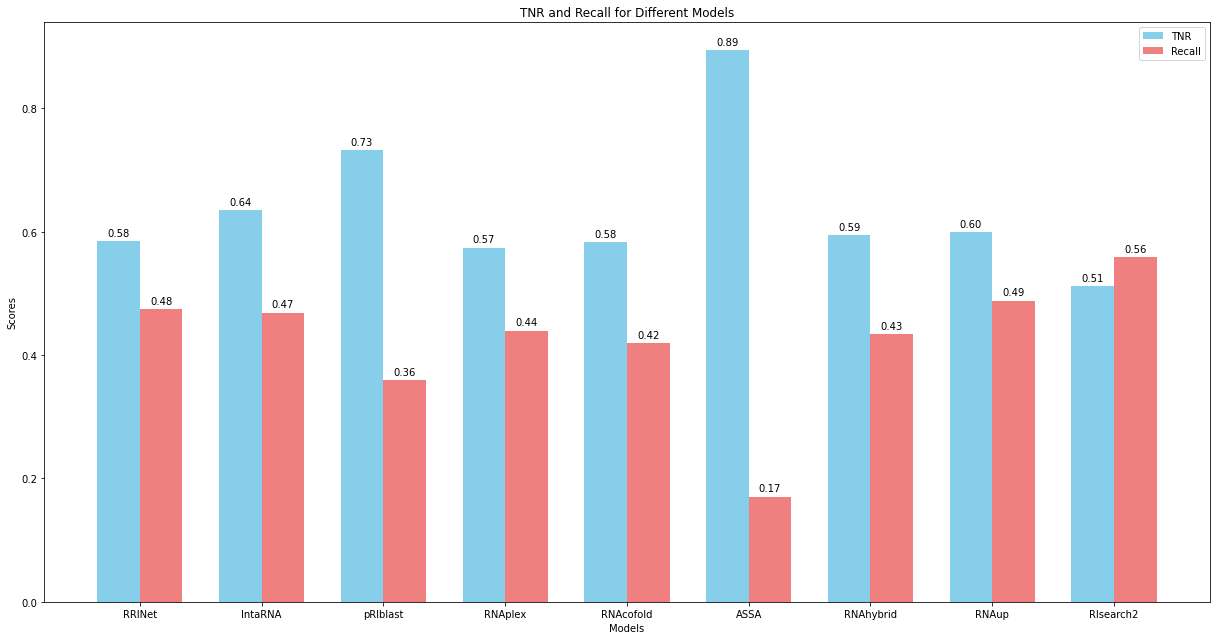

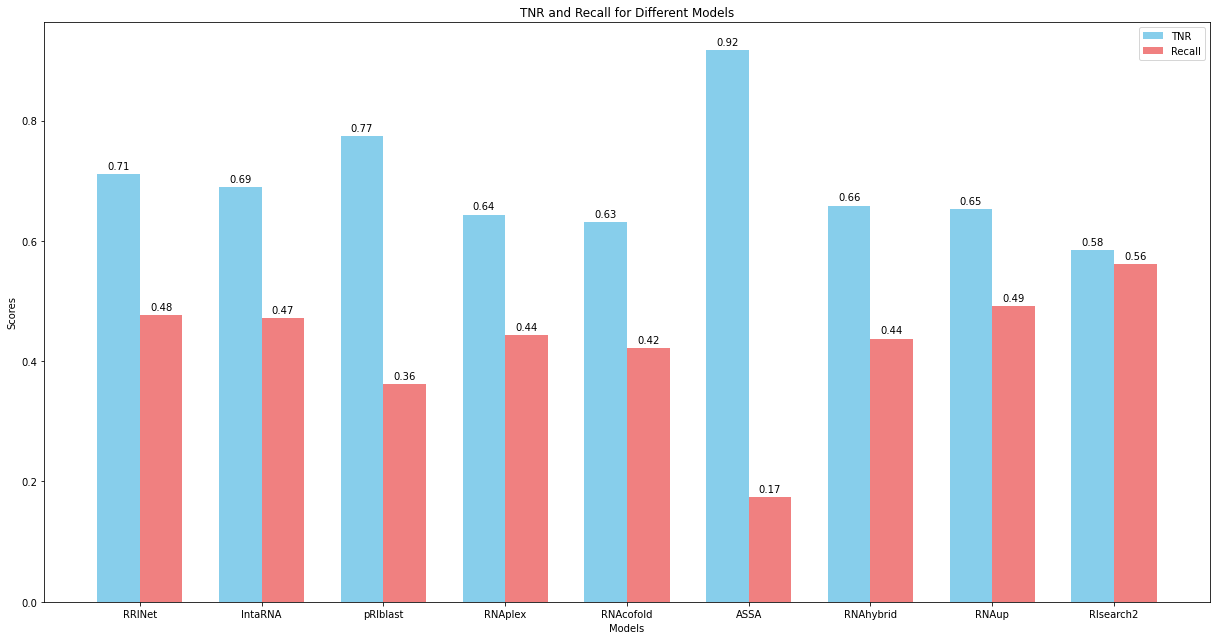

mario interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


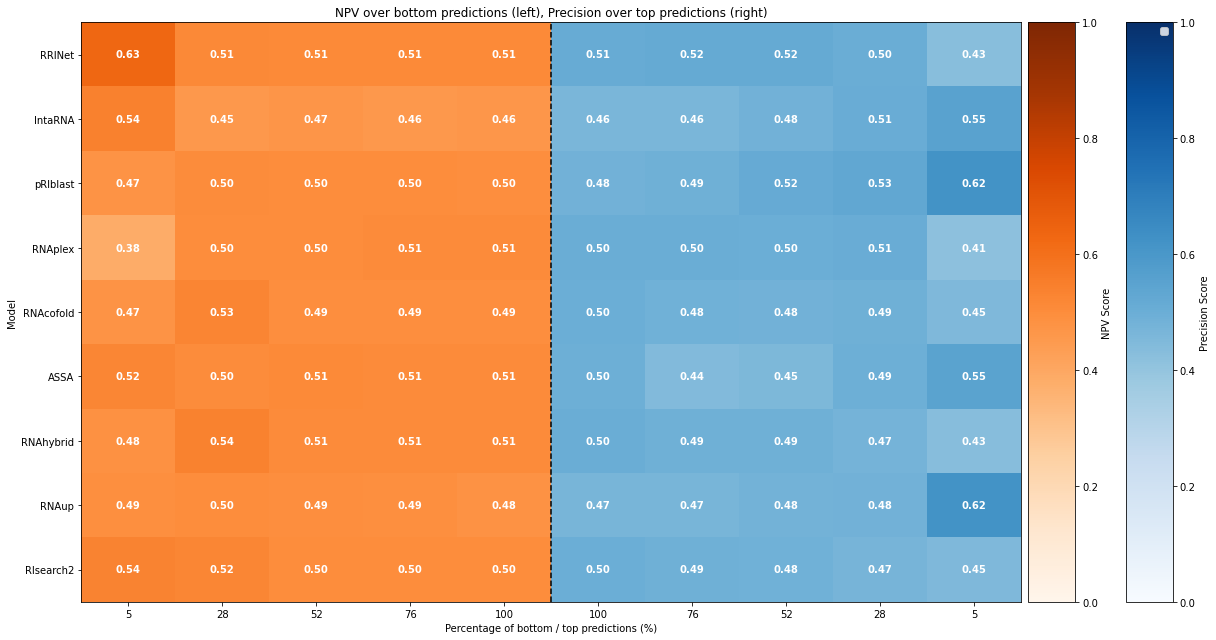

mario patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


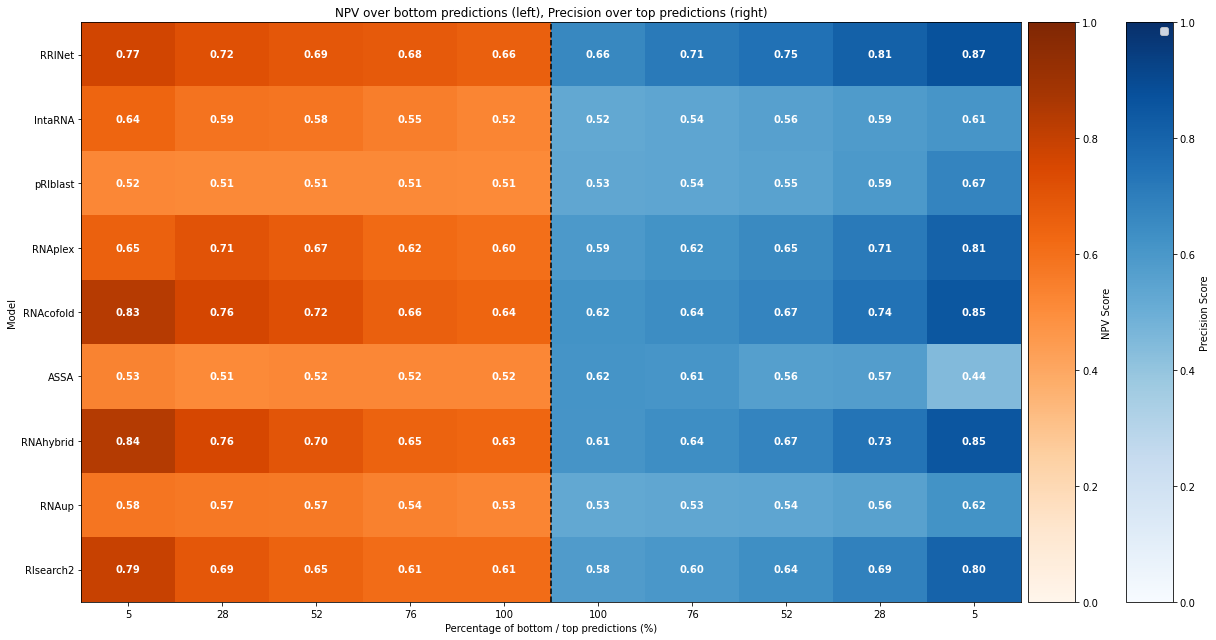

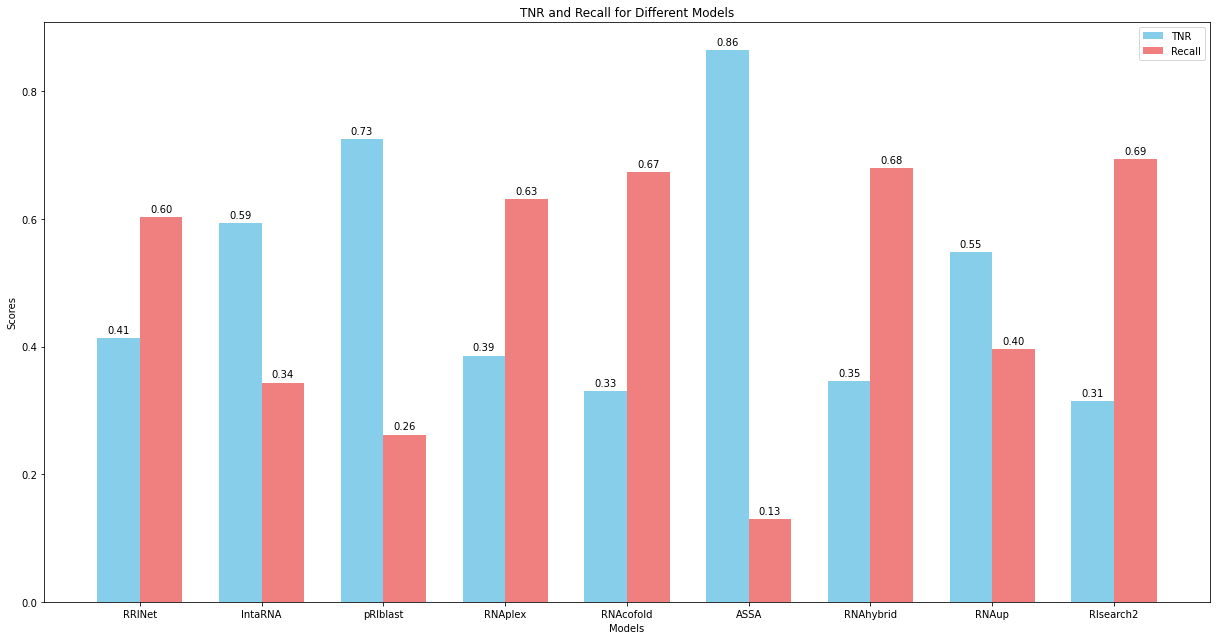

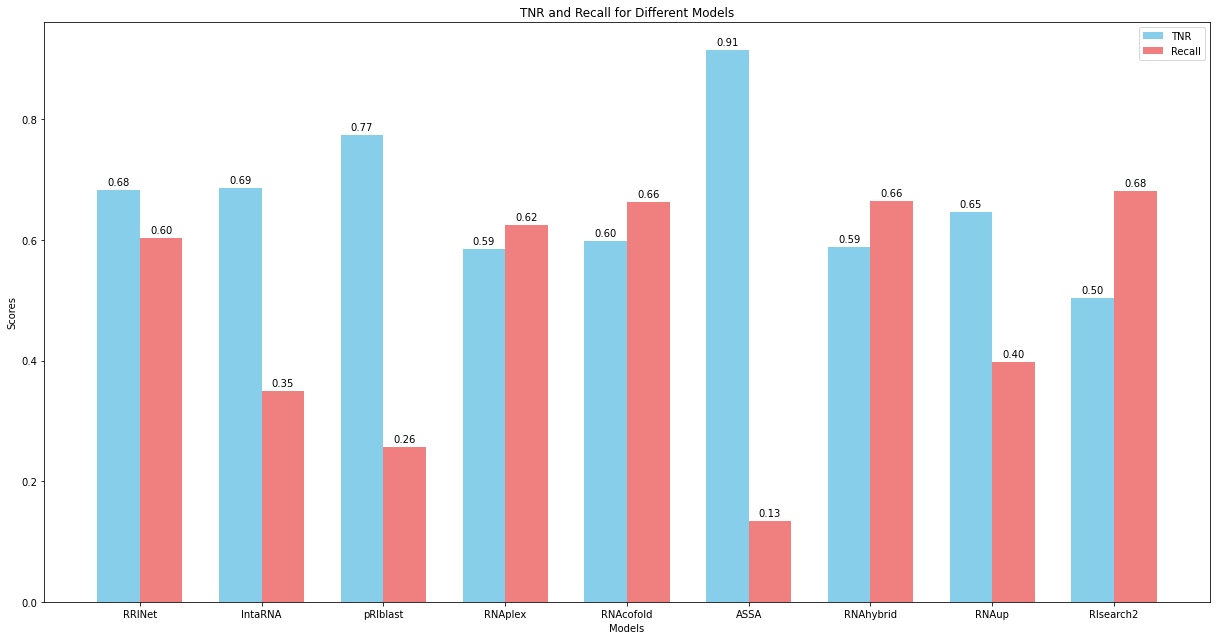

splash interactors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


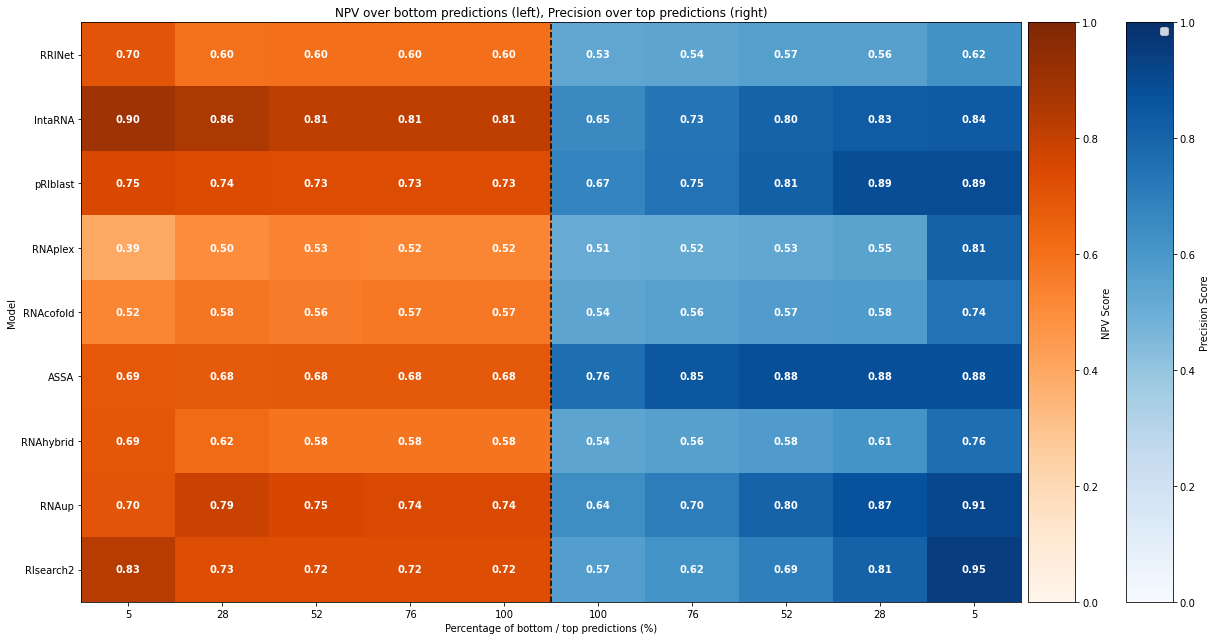

splash patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


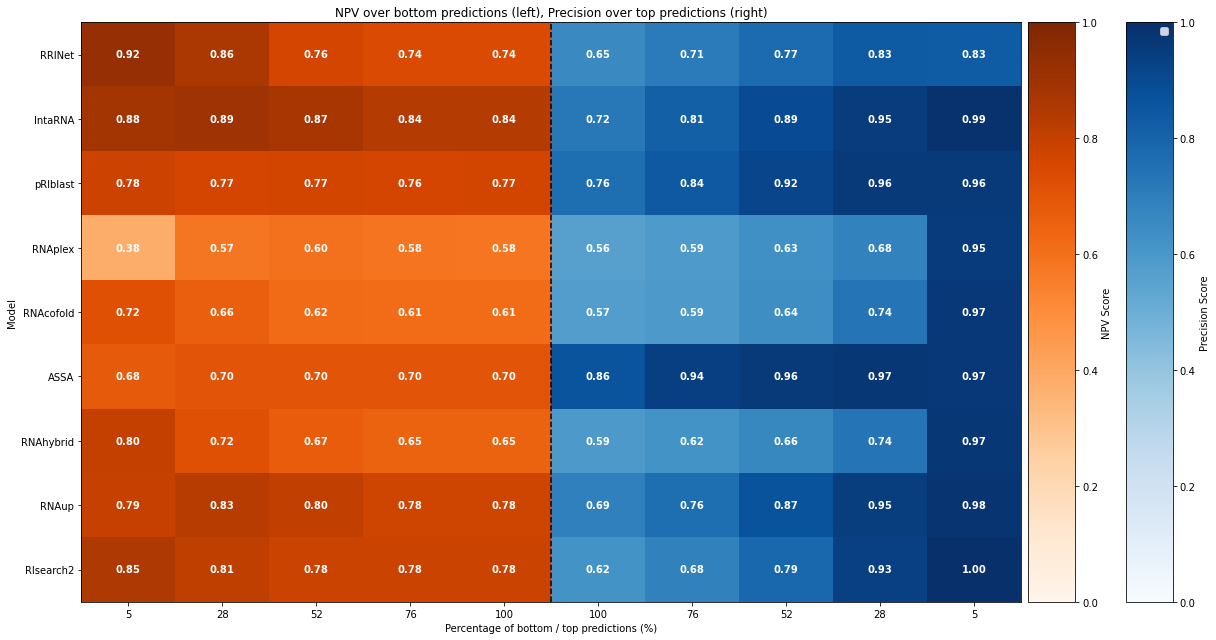

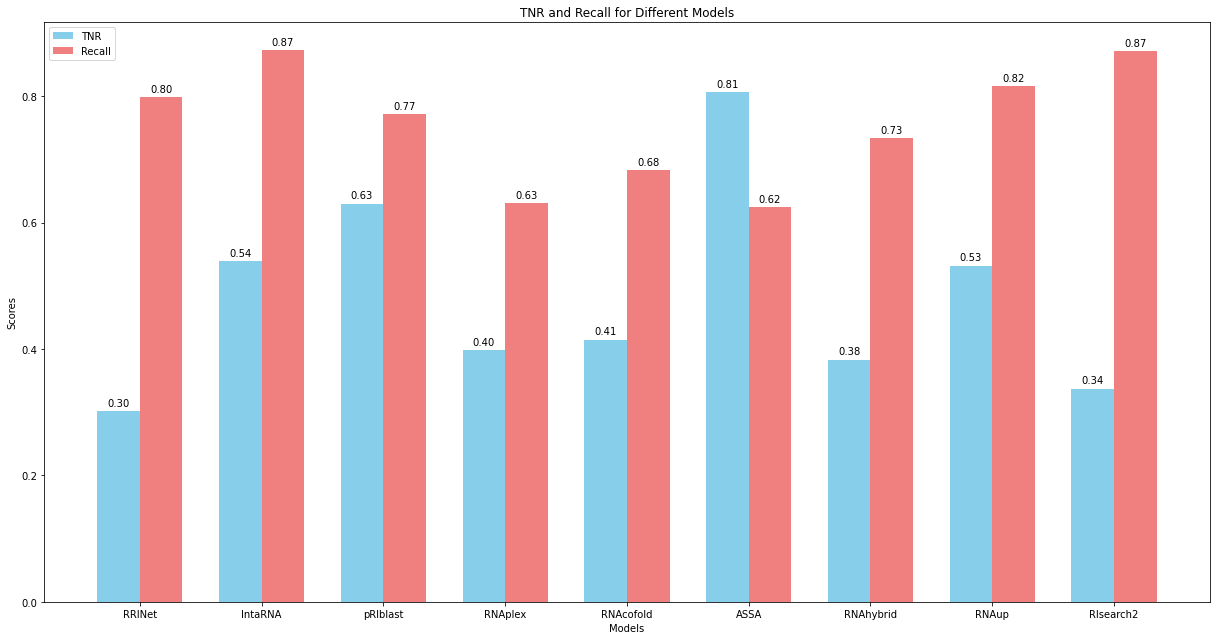

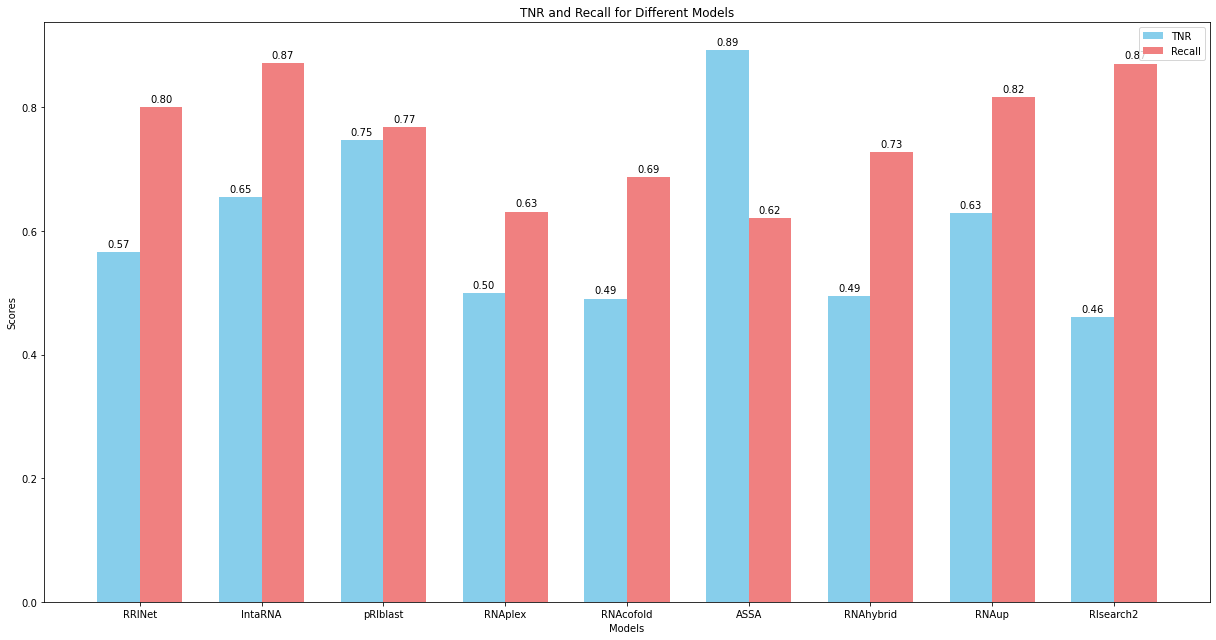

In [16]:
for dataset in list_of_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq = map_dataset_to_hp(dataset)
    
    if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
        n_run_undersampling = 50 
    else:
        n_run_undersampling = 10
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = paris_hq_threshold,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
    
    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    ephnen = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    #interactors
    print(dataset, 'interactors')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(easypos_smartneg, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    npv_data = np.array([npv [::-1] for npv in npv_models])
    npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC)        
    #patches
    print(dataset, 'patches')
    precision_data, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names = collect_results_based_on_topbottom_for_all_models(ephnen, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    npv_data = np.array([npv [::-1] for npv in npv_models])
    npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC)
    
    plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'interactors'), figsize, bar_width=0.35)
    plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'patches'), figsize, bar_width=0.35)

#### Unique Plot

dataset: parisHQ


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


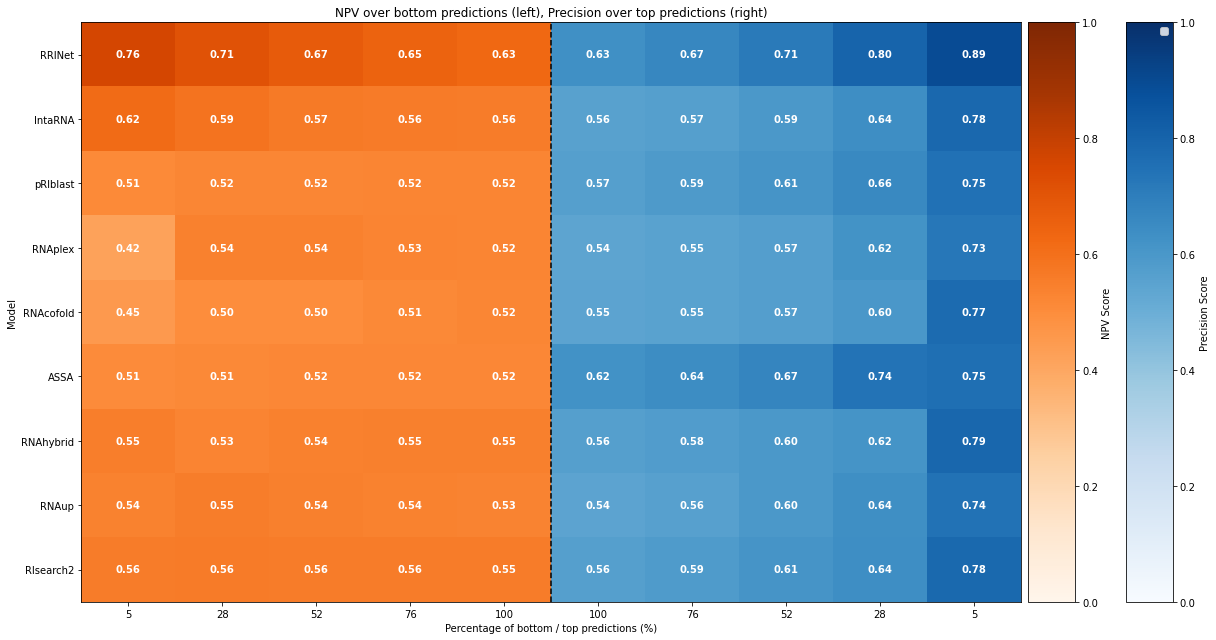

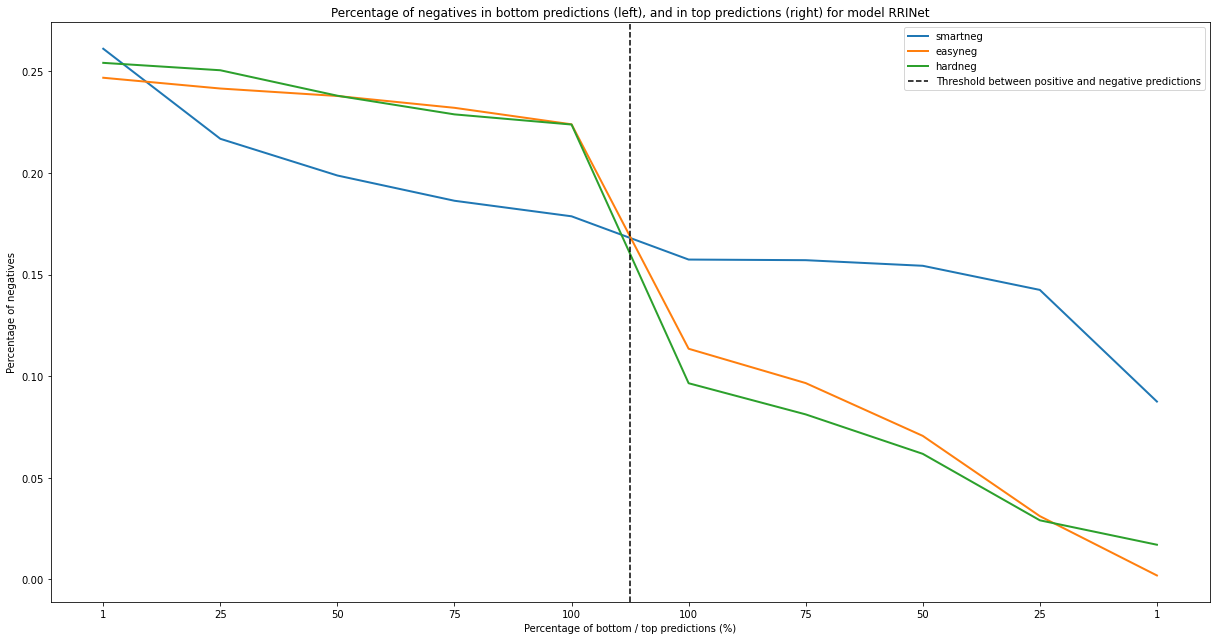

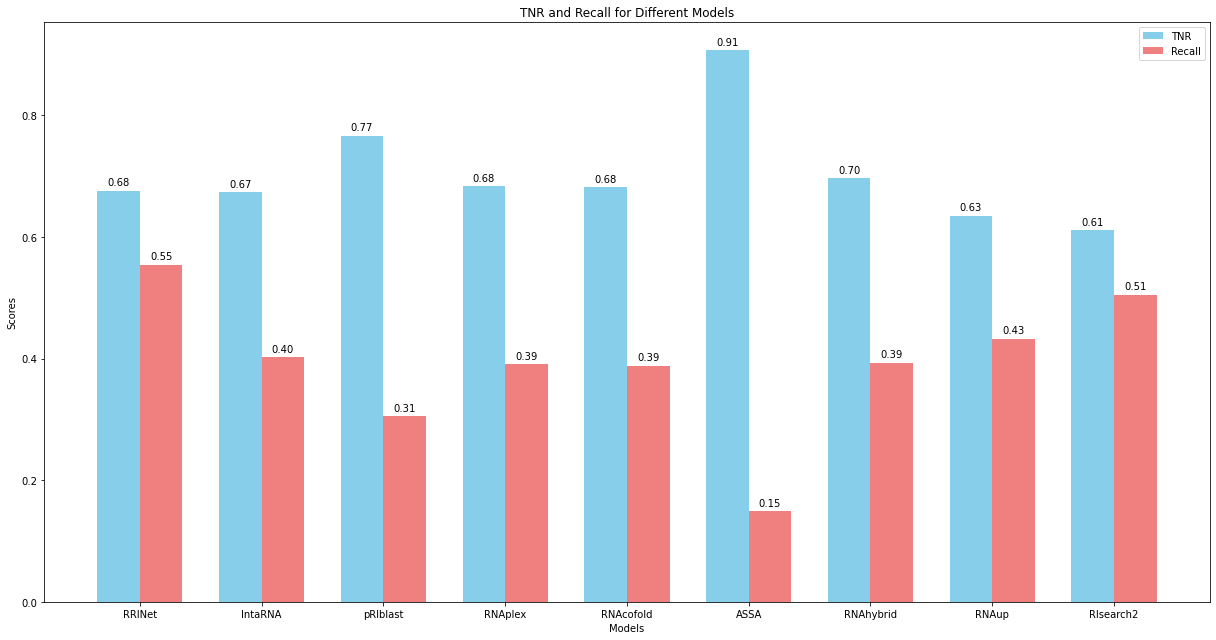

dataset: paris_mouse_HQ


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


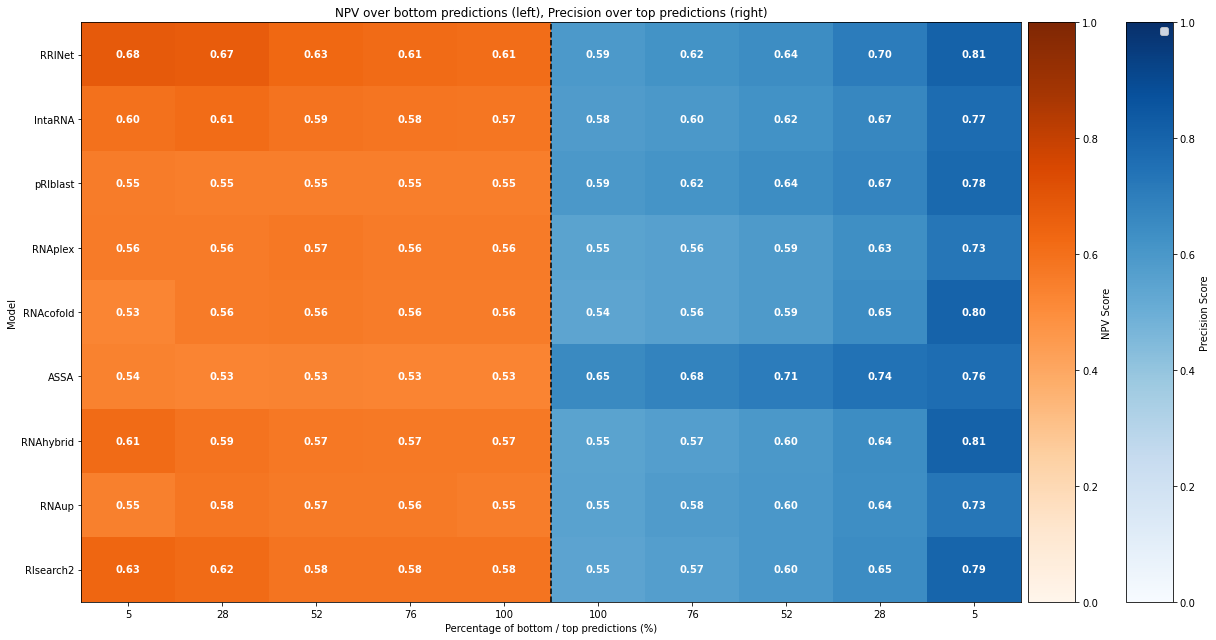

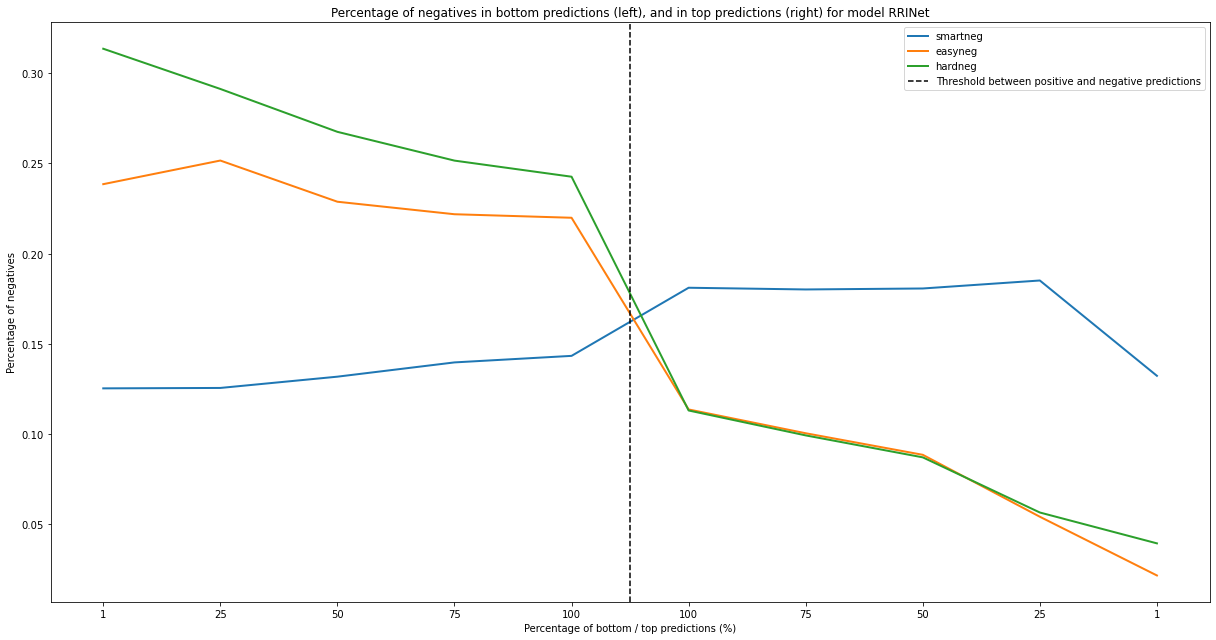

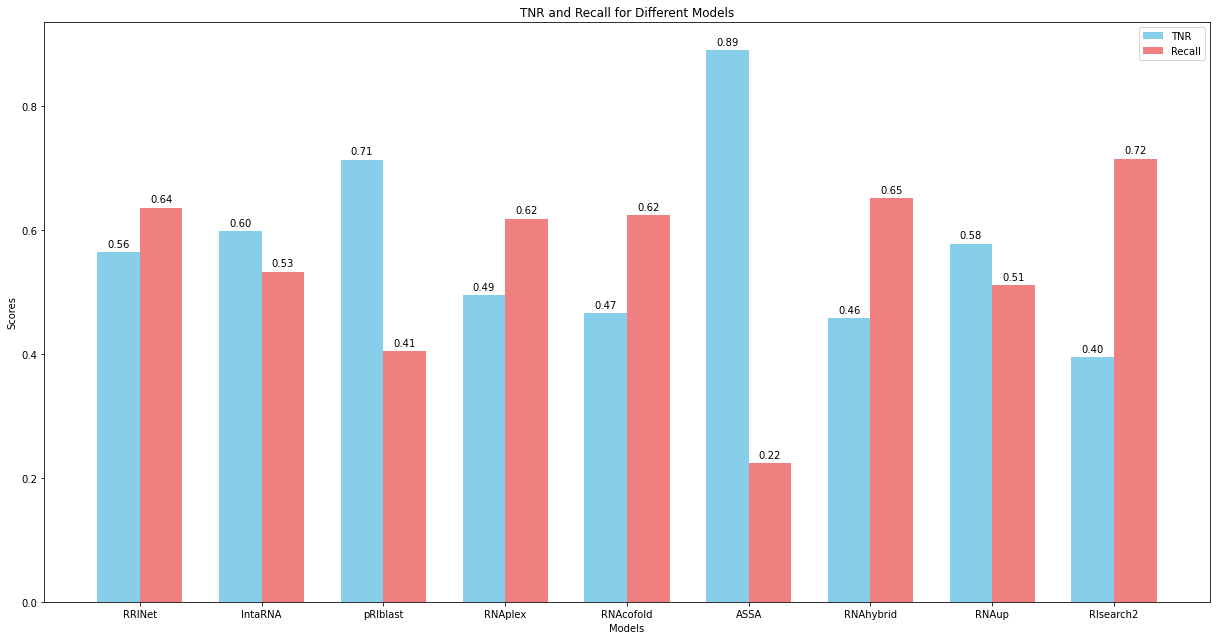

dataset: ricseqHQ


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


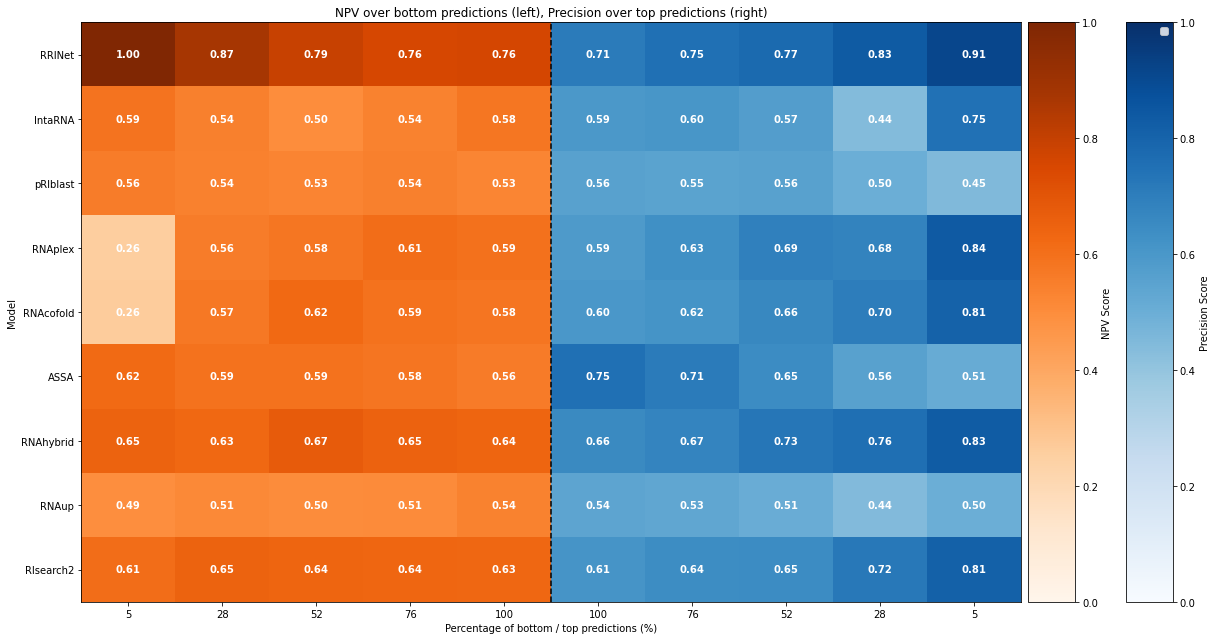

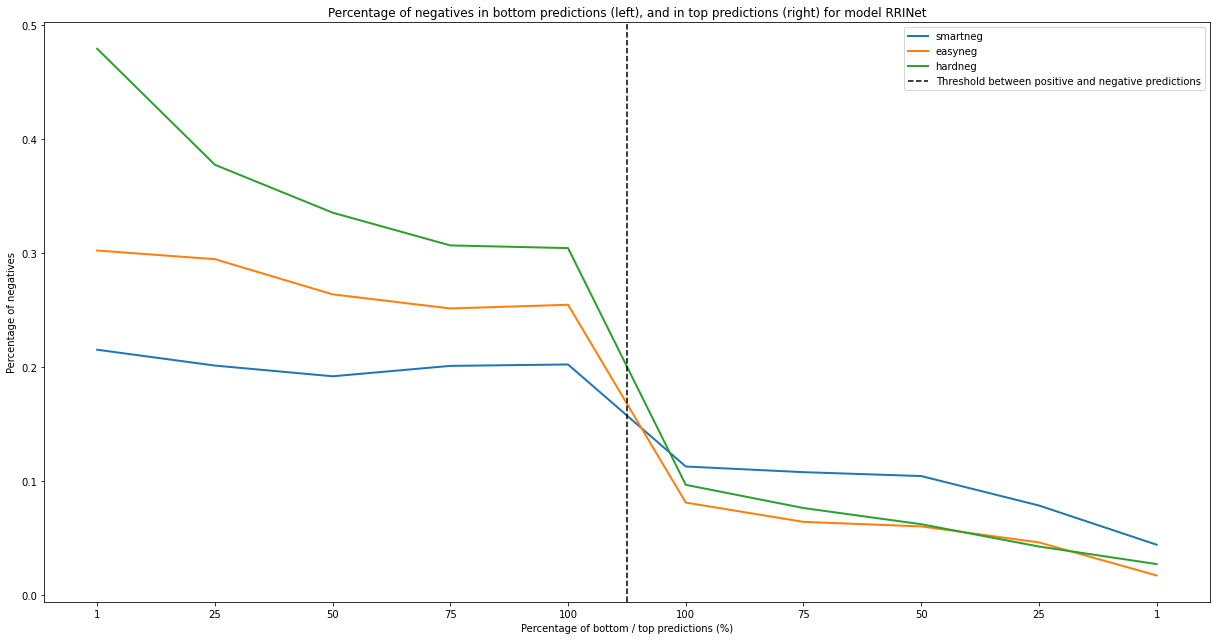

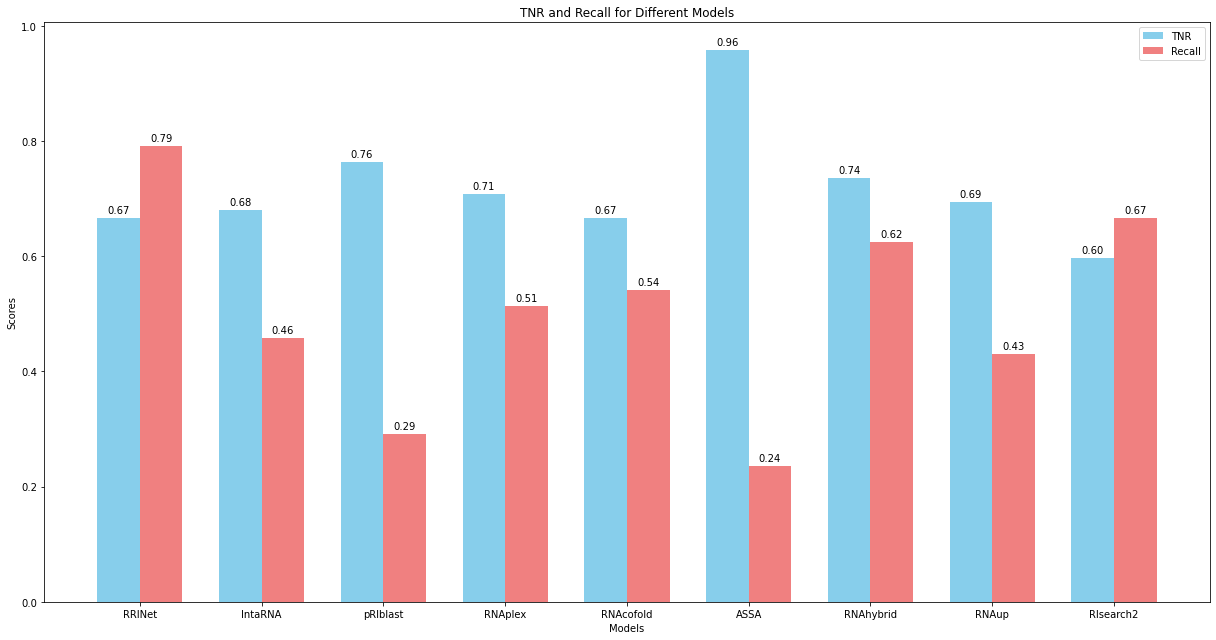

dataset: psoralen


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


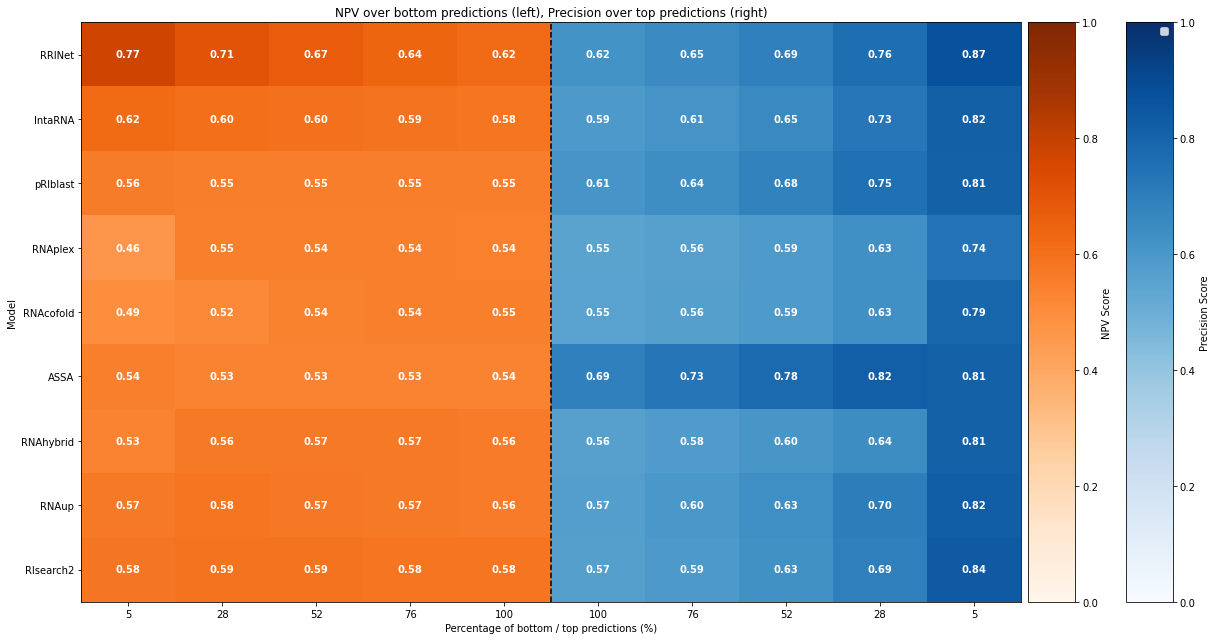

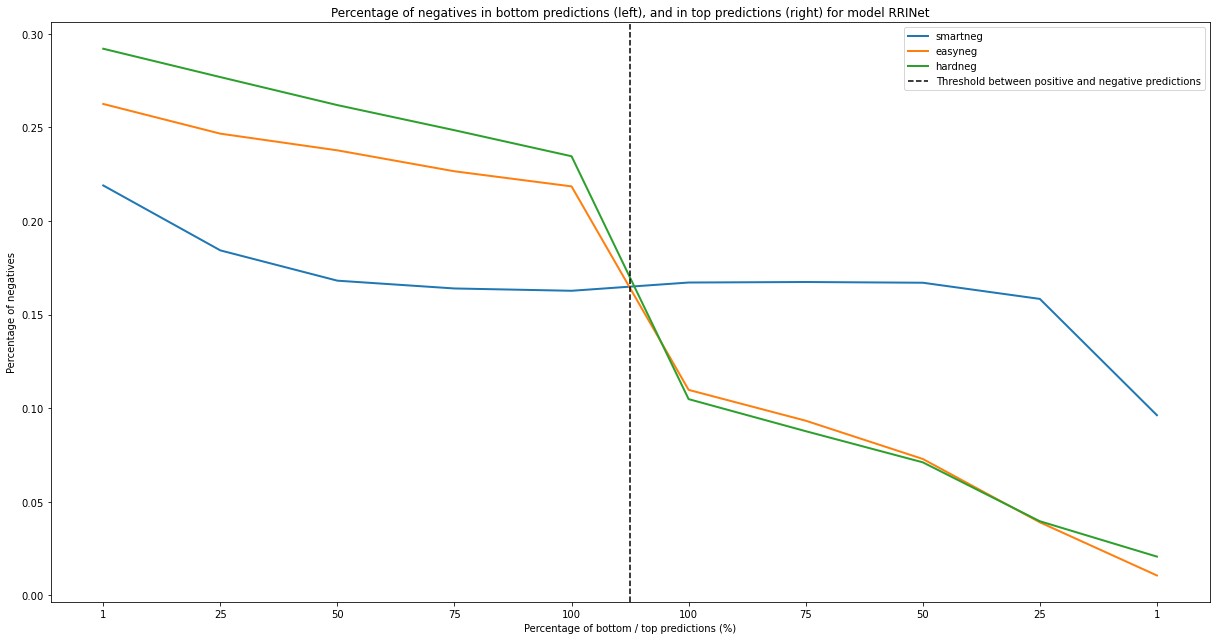

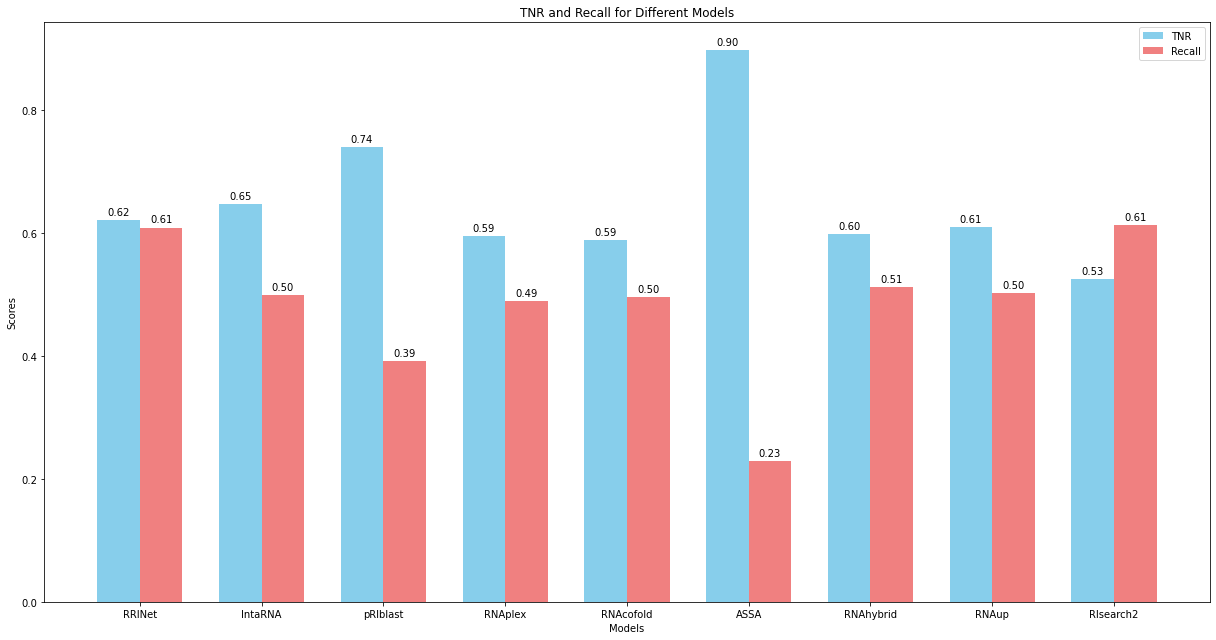

dataset: paris


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


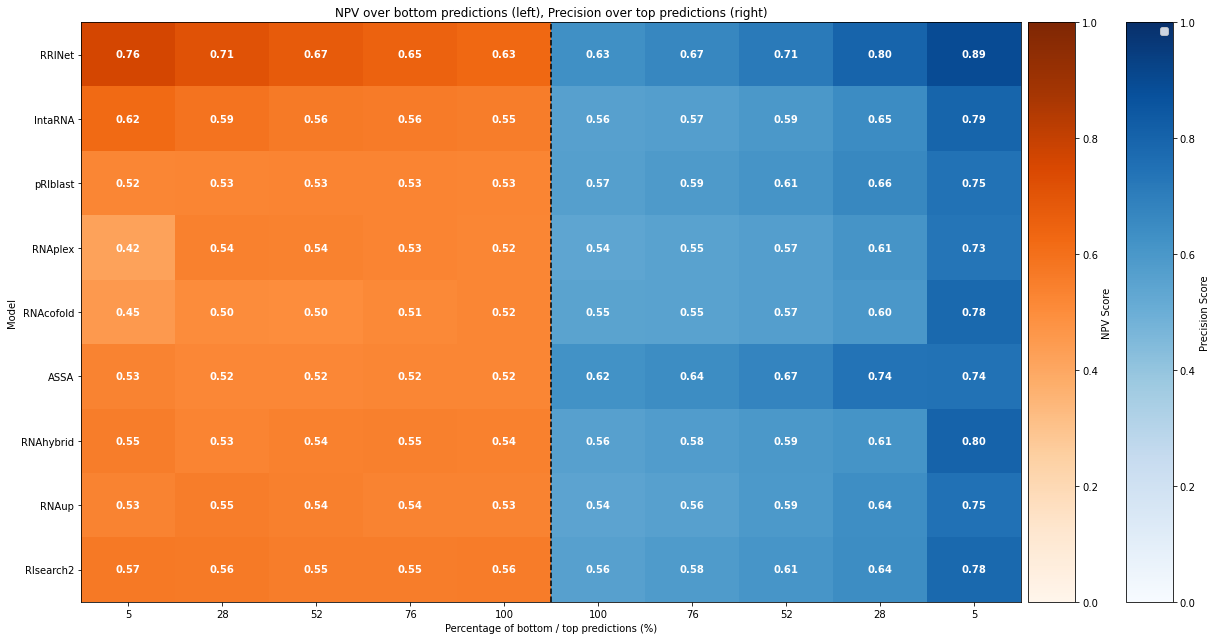

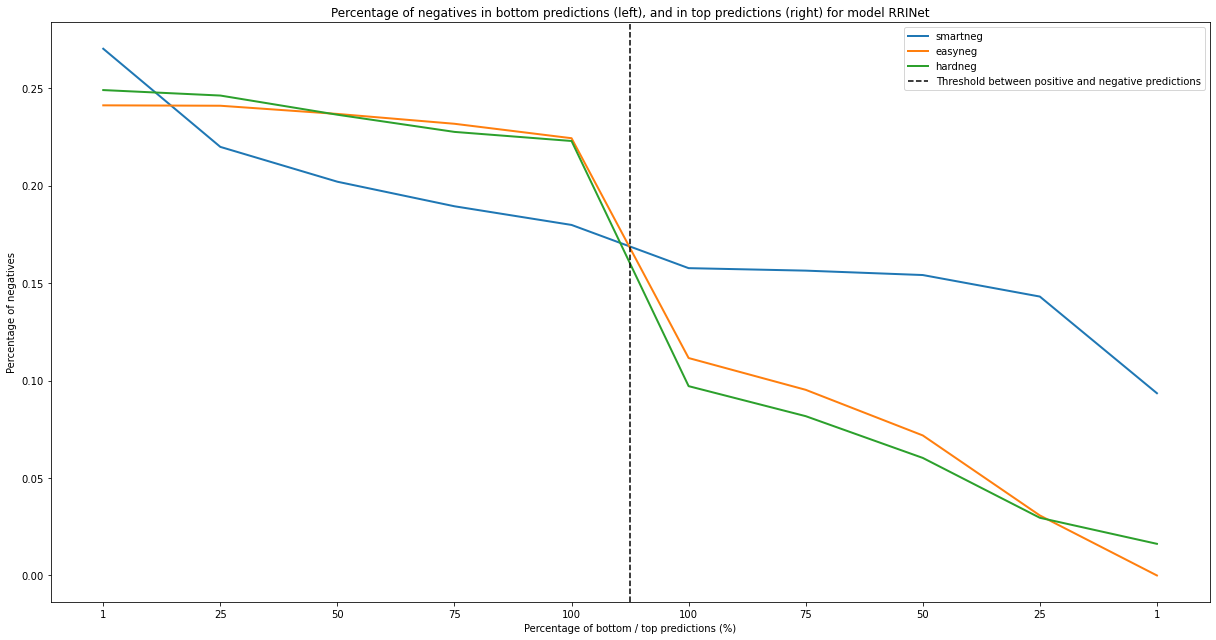

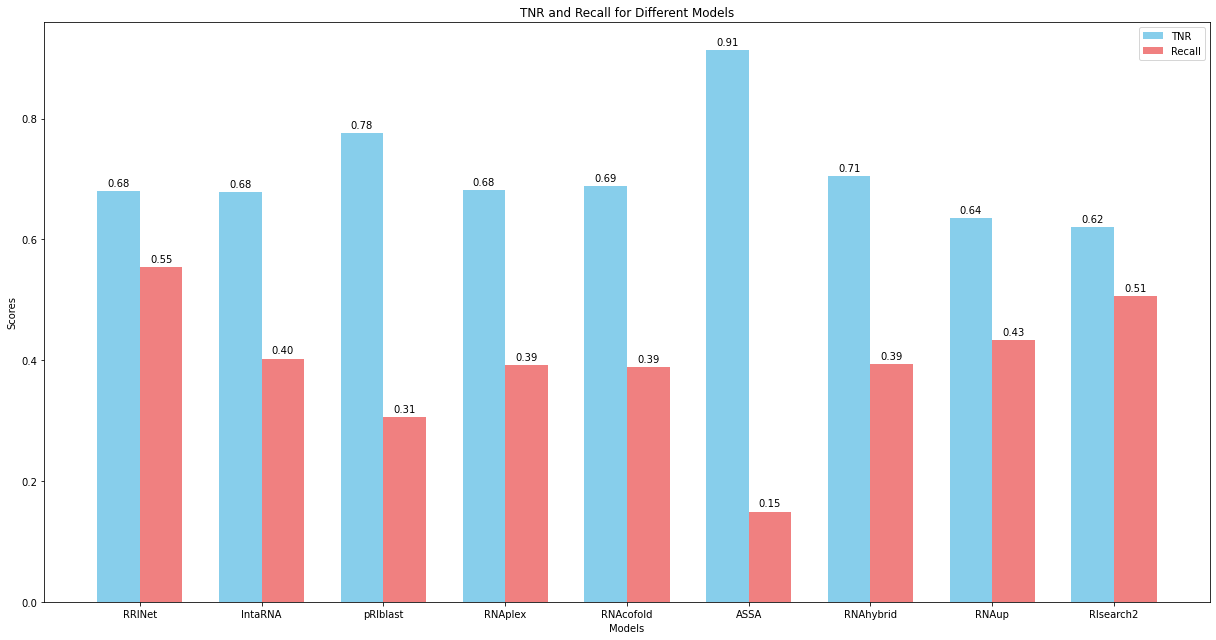

dataset: paris_mouse


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


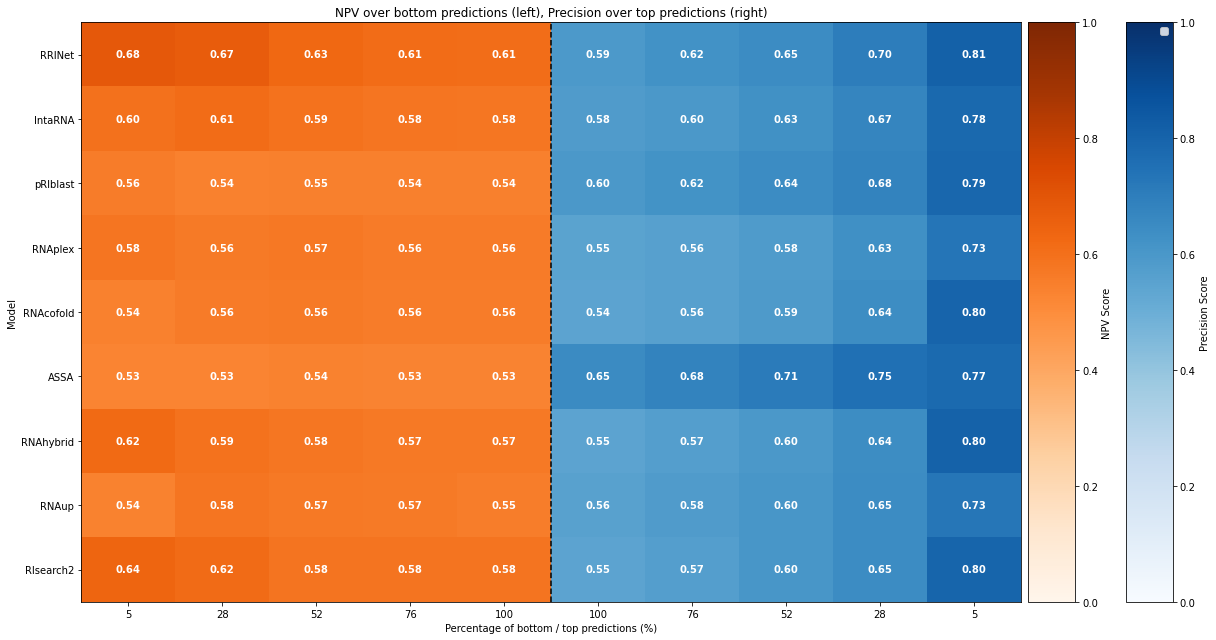

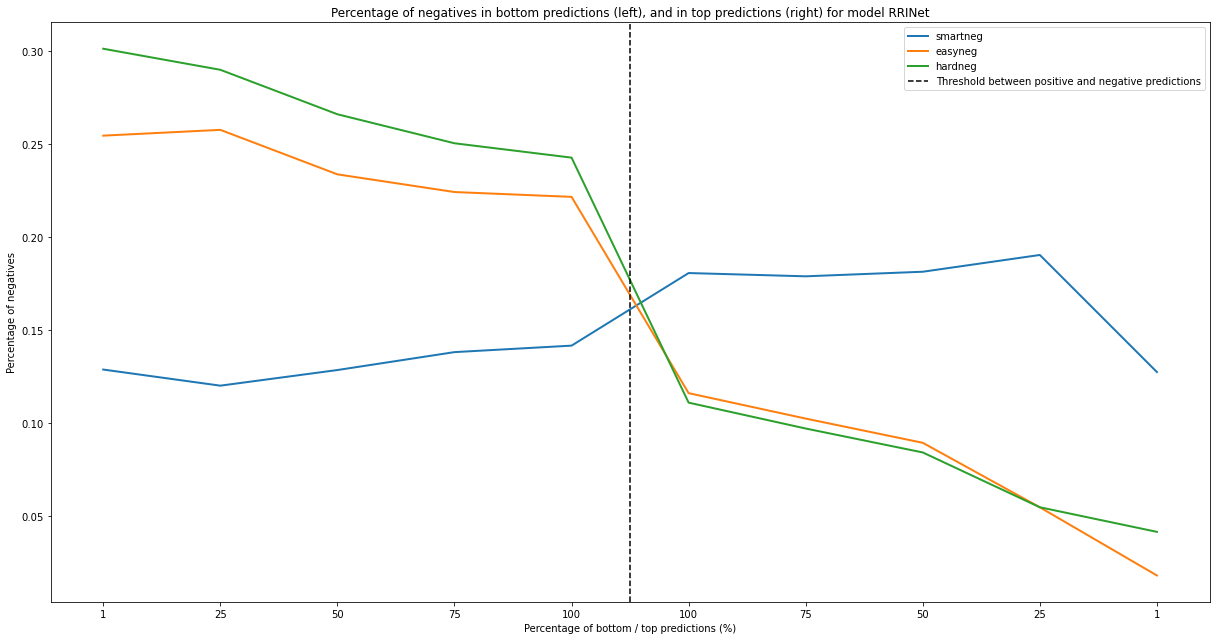

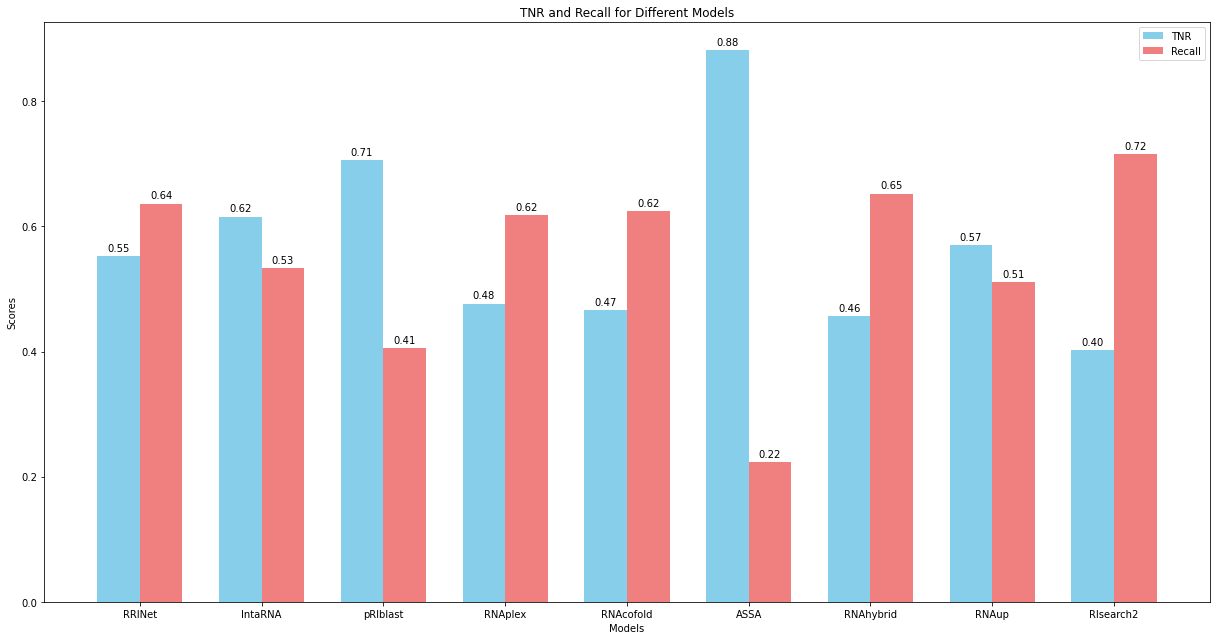

dataset: ricseq


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


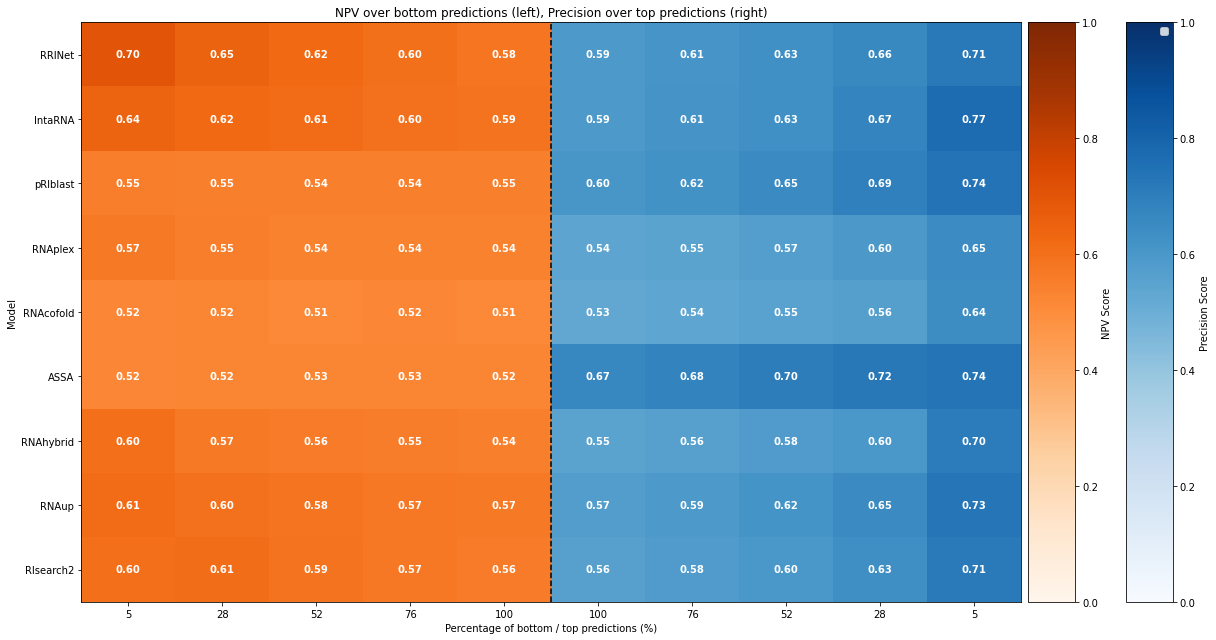

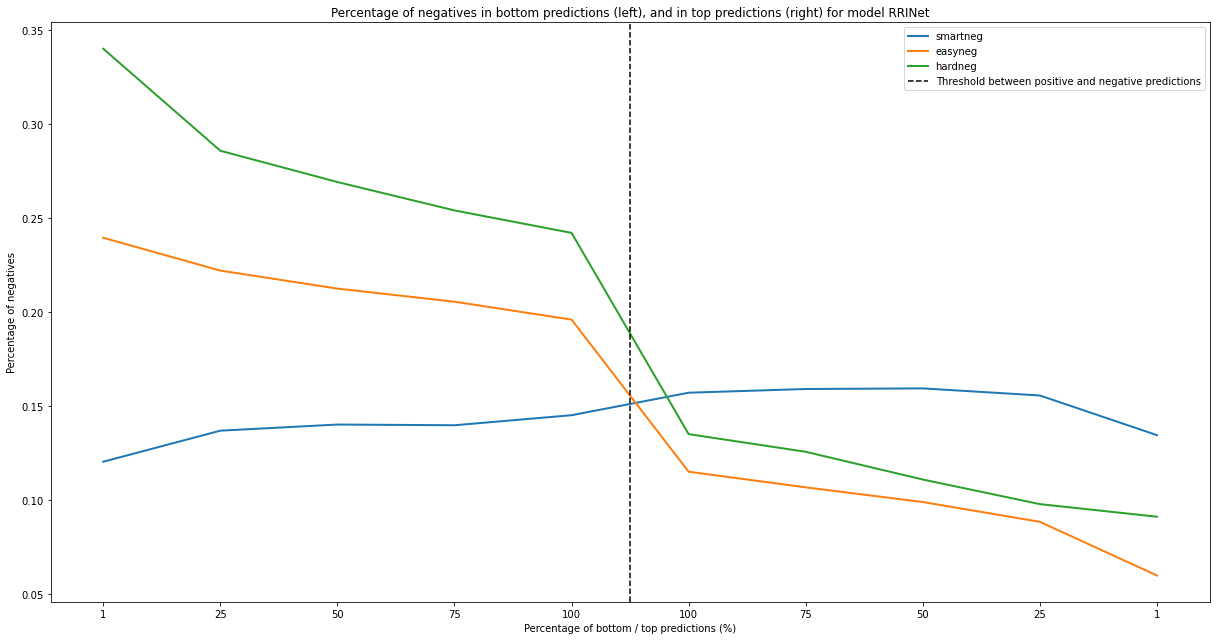

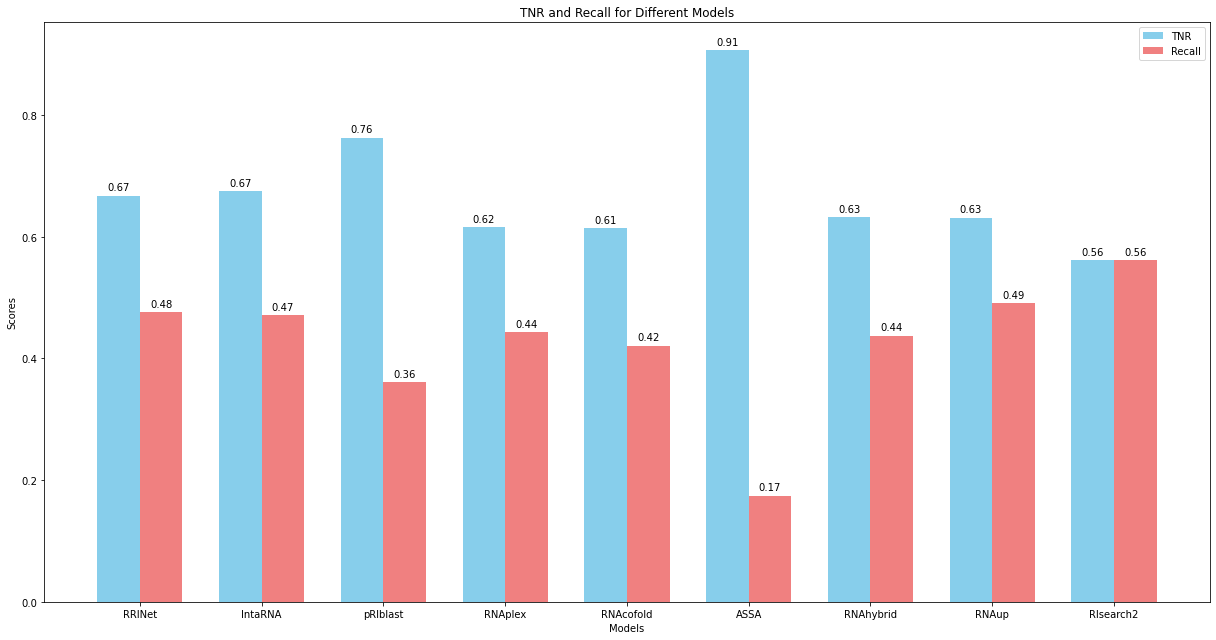

dataset: mario


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


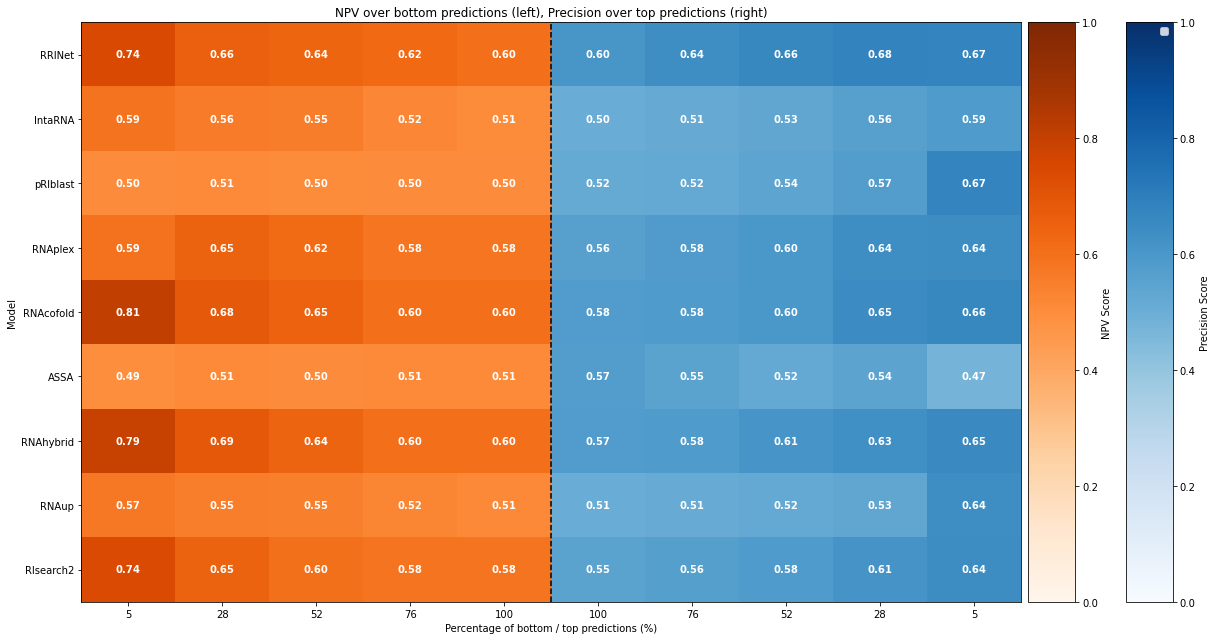

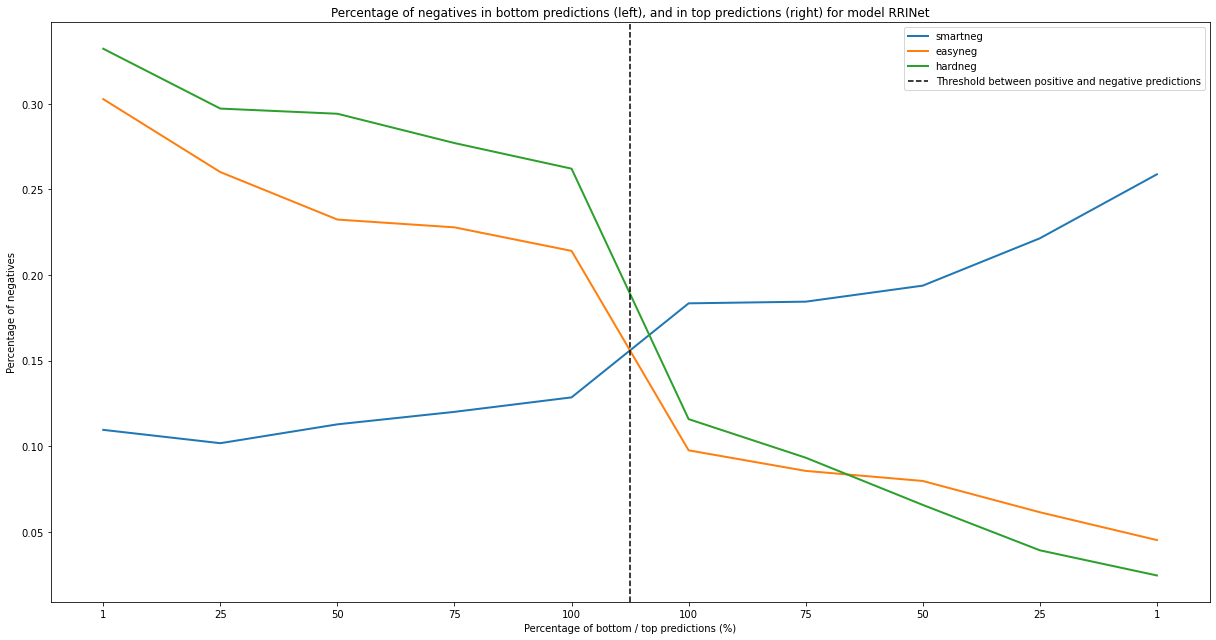

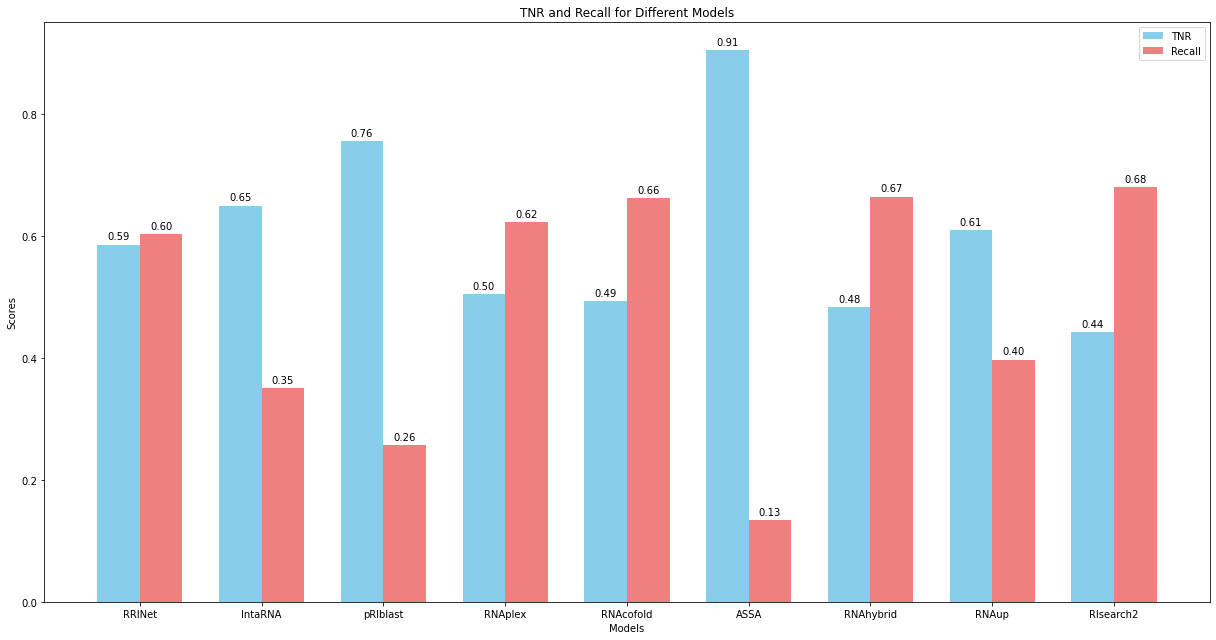

dataset: splash


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


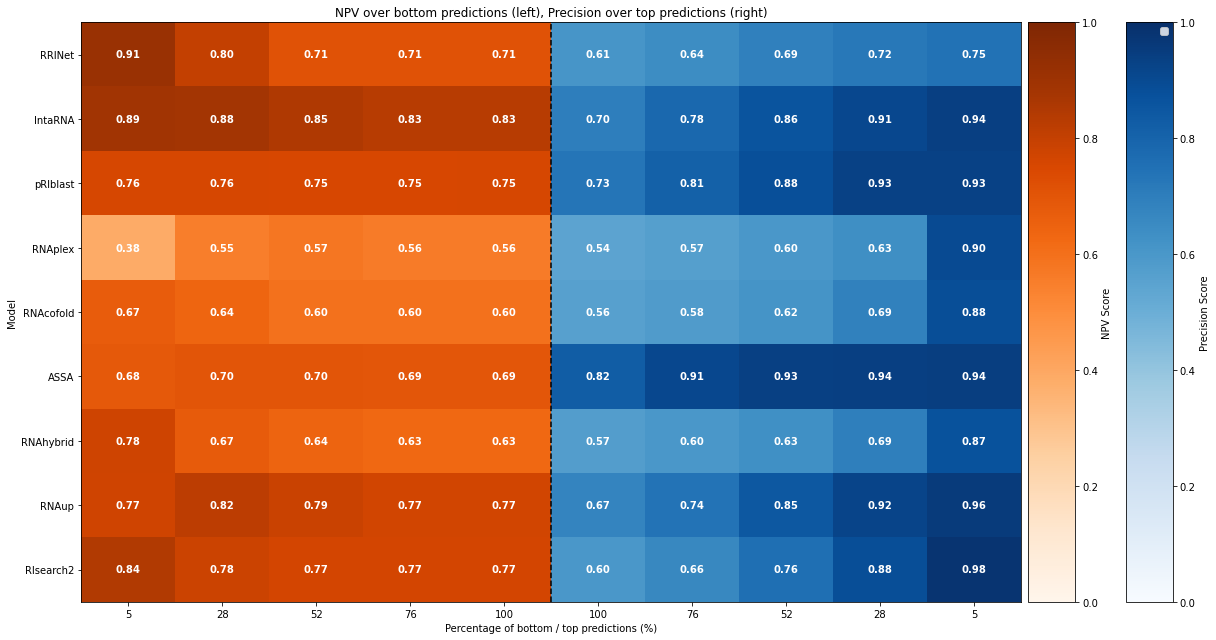

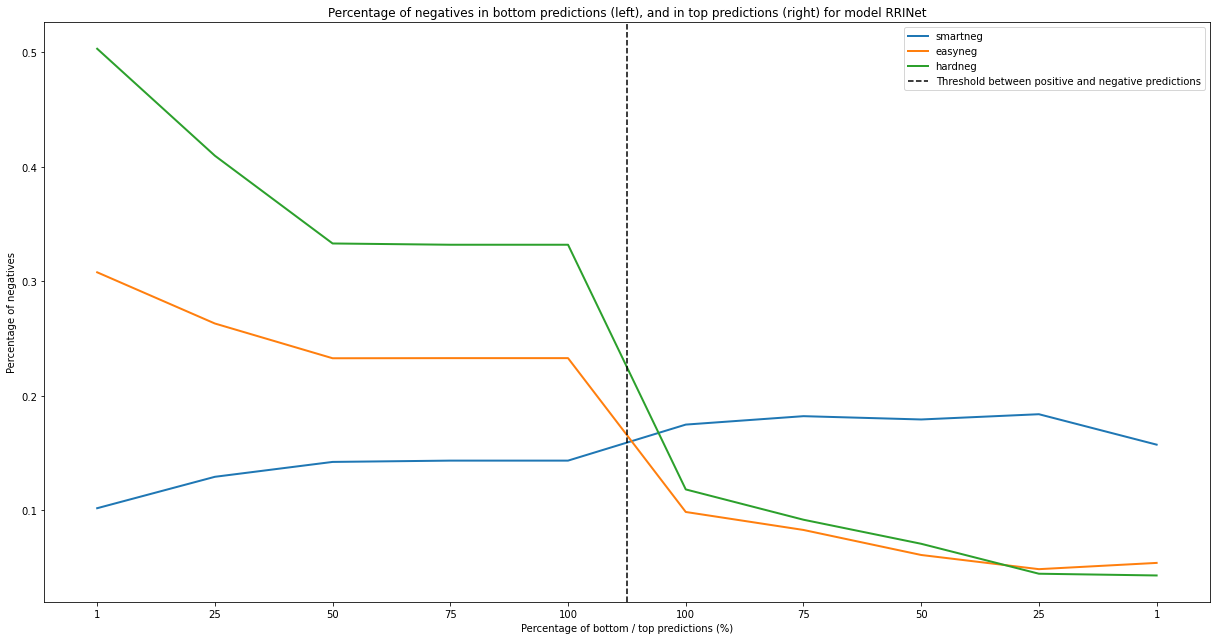

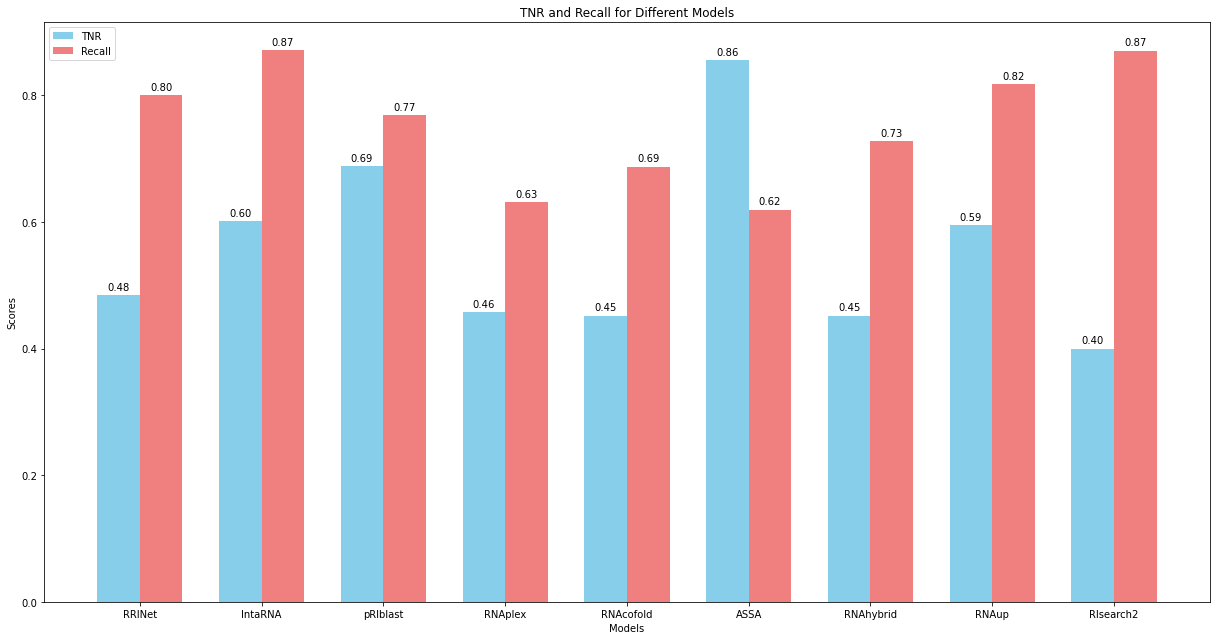

In [17]:
for dataset in list_of_datasets:
    
    experiment, specie_paris, paris_hq_threshold, n_reads_ricseq = map_dataset_to_hp(dataset)
    
    if dataset in ['parisHQ', 'paris_mouse_HQ', 'ricseqHQ', 'mario', 'splash']:
        n_run_undersampling = 50 
    else:
        n_run_undersampling = 10
    
    res = modelRM.get_experiment_data(
        experiment = experiment, 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = specie_paris,
        paris_hq = paris_hq_threshold,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = logistic_regression_models,
    )
    
    print(f'dataset: {dataset}')
    
    precision_data, _, model_names, perc_sn_prec, perc_hn_prec, perc_en_prec = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'precision')
    npv_models, _, model_names, perc_sn_npv, perc_hn_npv, perc_en_npv = collect_results_based_on_topbottom_for_all_models_perc_neg(res, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, 'npv')
    
    npv_data = np.array([npv [::-1] for npv in npv_models])
    perc_sn_npv = np.array([npv [::-1] for npv in perc_sn_npv])
    perc_hn_npv = np.array([npv [::-1] for npv in perc_hn_npv])
    perc_en_npv = np.array([npv [::-1] for npv in perc_en_npv])
    
    npv_precision(precision_data, npv_data, model_names, figsize, MIN_PERC)     
    perc_neg_npv_precision(perc_sn_prec, perc_hn_prec, perc_en_prec, perc_sn_npv, perc_hn_npv, perc_en_npv, model_names, 'nt', figsize, min_perc = 1)
    plot_tnr_recall_for_all_models(list_of_models_to_test, balancing_only_for_one_task(res, task = 'all'), figsize, bar_width=0.35)

### Ricseq AUC increase with higher n_reads

In [18]:
dfs = []

n_positives_run = []

list_of_n_reads_ricseq = [2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_ricseq in list_of_n_reads_ricseq:
    
    res = modelRM.get_experiment_data(
        experiment = 'ricseq', 
        paris_test = np.nan, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = np.nan,
        paris_hq = np.nan,
        paris_hq_threshold = np.nan,
        n_reads_paris = np.nan,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = n_reads_ricseq,
        logistic_regression_models = {},
    )
    
    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    enhn = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_ricseq_nread{n_reads_ricseq}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

TASK:  interactors


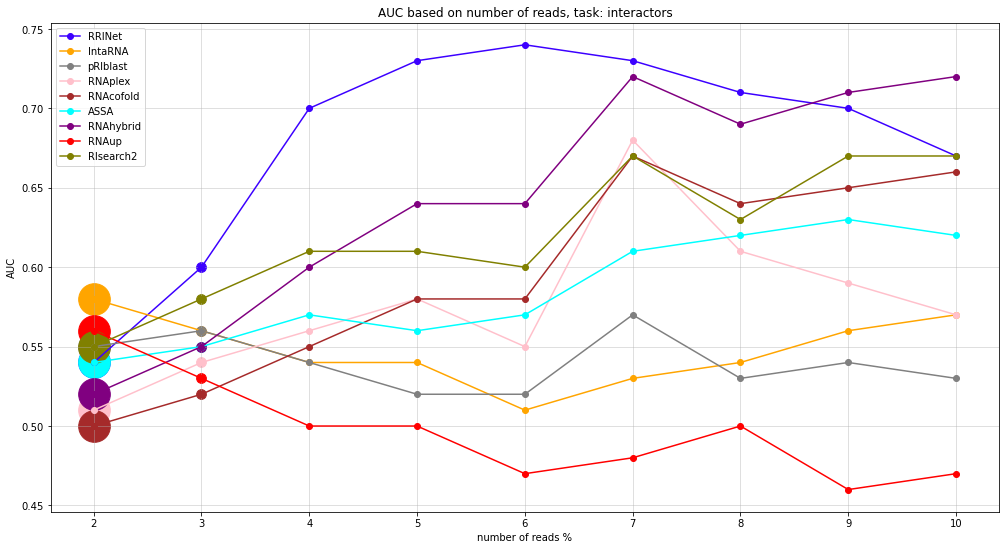




TASK:  patches


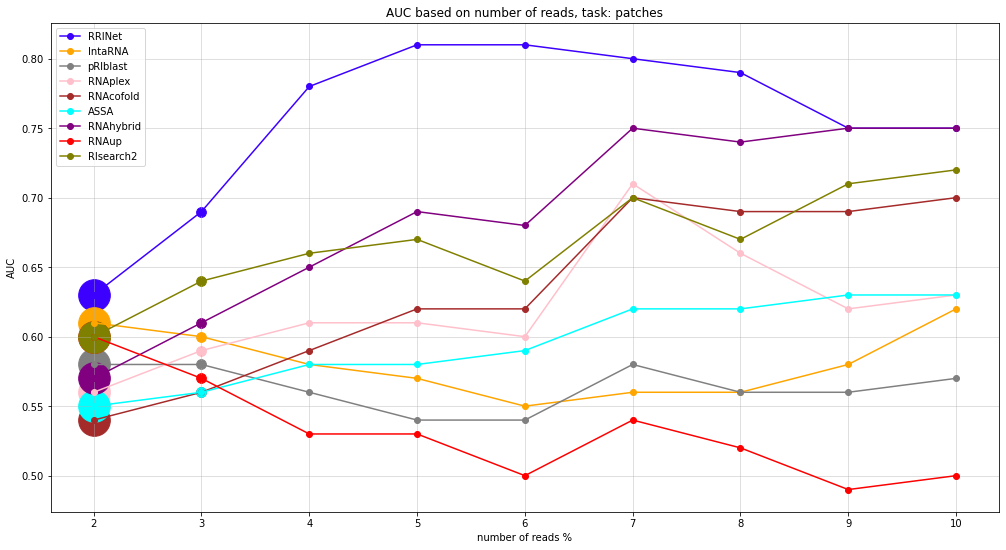

In [19]:
model_names = list(df_auc['model_name'])

size_multiplier = 10
metric = 'AUC'
string_label = 'number of reads'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for n_reads_ricseq in list_of_n_reads_ricseq:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_ricseq_nread{n_reads_ricseq}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_n_reads_ricseq, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

# PARIS HQ

Correlation between log(interaction size) and n_reads: 0.10
Correlation between log(interaction size) and probability: 0.12
Correlation between n_reads and probability: 0.07


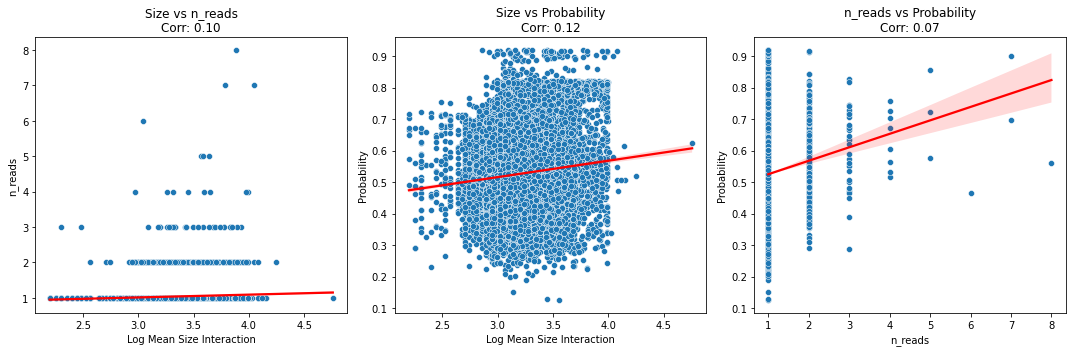

In [20]:
plot_correlation_nreads_prob_intsize(modelRM, PARIS_FINETUNED_MODEL)

### Paris AUC increase with higher n_reads

In [21]:
SPECIE = 'all'

dfs = []

n_positives_run = []

list_of_n_reads_paris = [1,2,3,4,5,6,7] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20] #[2,3,4,5,6,7,8, 9, 10] #[2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19,20]

for n_reads_paris in list_of_n_reads_paris:
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = n_reads_paris,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
    )
    
    print(f'# total positive samples: {res[(res.ground_truth == 1)].shape[0]} for N_reads >= {n_reads_paris}')
    
    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    enhn = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])
    
    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_paris_nread{n_reads_paris}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_paris_nread{n_reads_paris}'}, axis = 1))
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

# total positive samples: 14731 for N_reads >= 1
# total positive samples: 300 for N_reads >= 2
# total positive samples: 45 for N_reads >= 3
# total positive samples: 15 for N_reads >= 4
# total positive samples: 7 for N_reads >= 5
# total positive samples: 4 for N_reads >= 6
# total positive samples: 3 for N_reads >= 7


TASK:  interactors


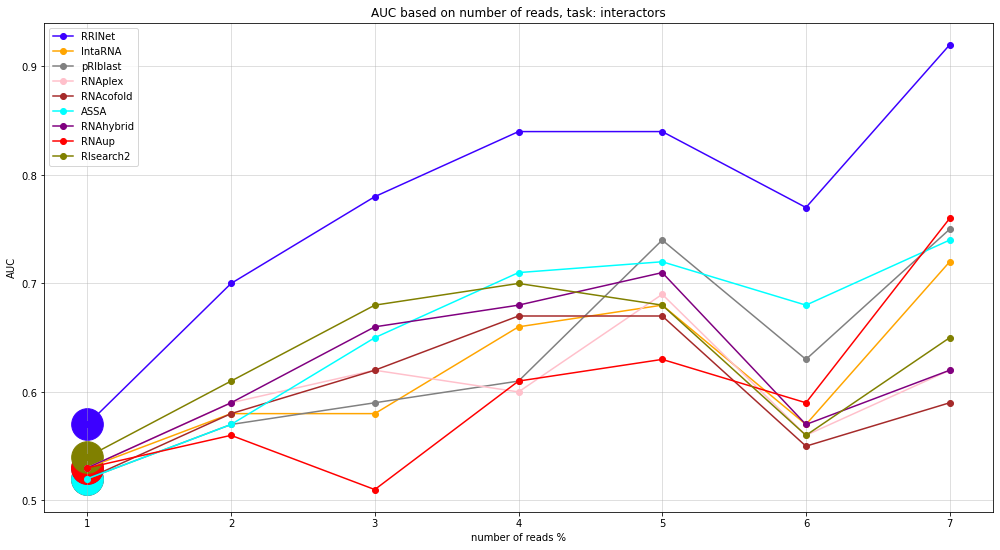




TASK:  patches


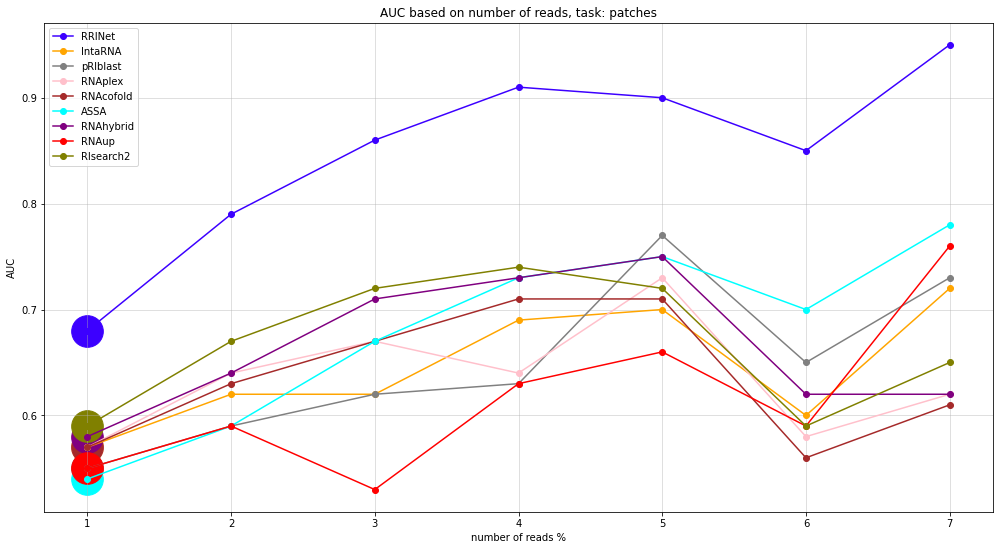

In [22]:
model_names = list(df_auc['model_name'])

size_multiplier = 10
metric = 'AUC'
string_label = 'number of reads'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for n_reads_paris in list_of_n_reads_paris:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_paris_nread{n_reads_paris}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)
        
    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_n_reads_paris, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

### Paris AUC increase with higher interaction length size

###### Il modo in cui carico i dataset tiene conto del fatto che la regione di interazione ha senso filtrarla per lunghezza solo per i positivi e gli smartneg. Quindi per hardneg, easyneg io caricherò tutti i dati non devo filtrare per lunghezza della regione di interazione.

In [23]:
SPECIE = 'human'

dfs = []

n_positives_run = []

list_of_paris_hq_tresholds = [15, 20, 25, 30, 35, 40, 45]

for HQ_THRESHOLD in tqdm(list_of_paris_hq_tresholds):
    
    res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = PARIS_FINETUNED_MODEL, 
        specie_paris = SPECIE,
        paris_hq = False,
        paris_hq_threshold = HQ_THRESHOLD,
        n_reads_paris = 1,
        splash_trained_model = False,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
    )

    easypos_smartneg = res[res.policy.isin(['easypos', 'smartneg'])].reset_index(drop = True)
    enhn = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])].reset_index(drop = True)
    
    pos = easypos_smartneg[easypos_smartneg.policy == 'easypos'].reset_index(drop = True)
    n_positives_run.append(pos.shape[0])


    dfs.append(obtain_all_model_auc(easypos_smartneg, energy_columns).rename({'auc': f'auc_interactors_paris_len{HQ_THRESHOLD}'}, axis = 1))
    dfs.append(obtain_all_model_auc(enhn, energy_columns).rename({'auc': f'auc_patches_paris_len{HQ_THRESHOLD}'}, axis = 1))

df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()
df_auc['model_name'] = df_auc['model_name'].apply(map_model_names)
df_auc = df_auc.drop_duplicates().reset_index(drop=True)

  0%|          | 0/7 [00:00<?, ?it/s]

### Human

TASK:  interactors


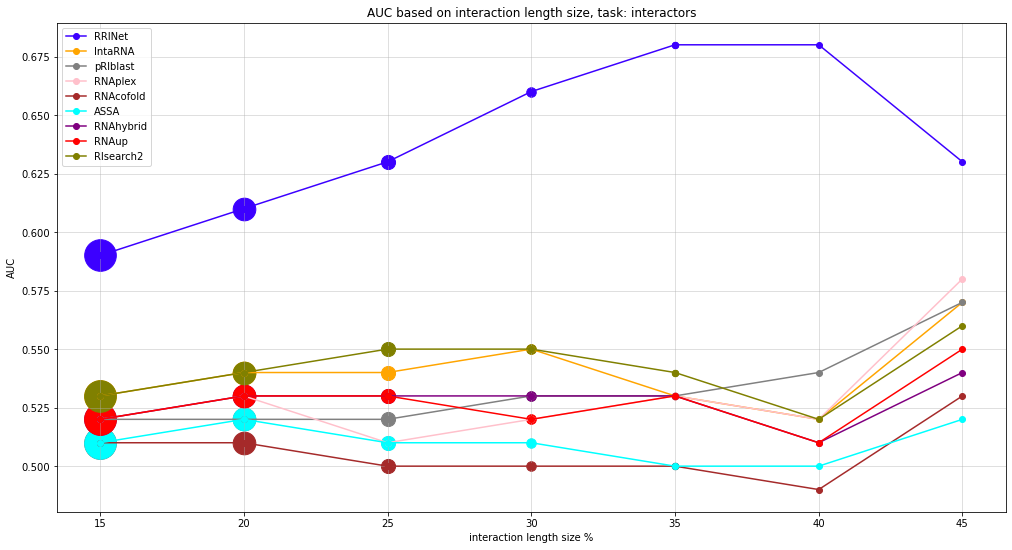




TASK:  patches


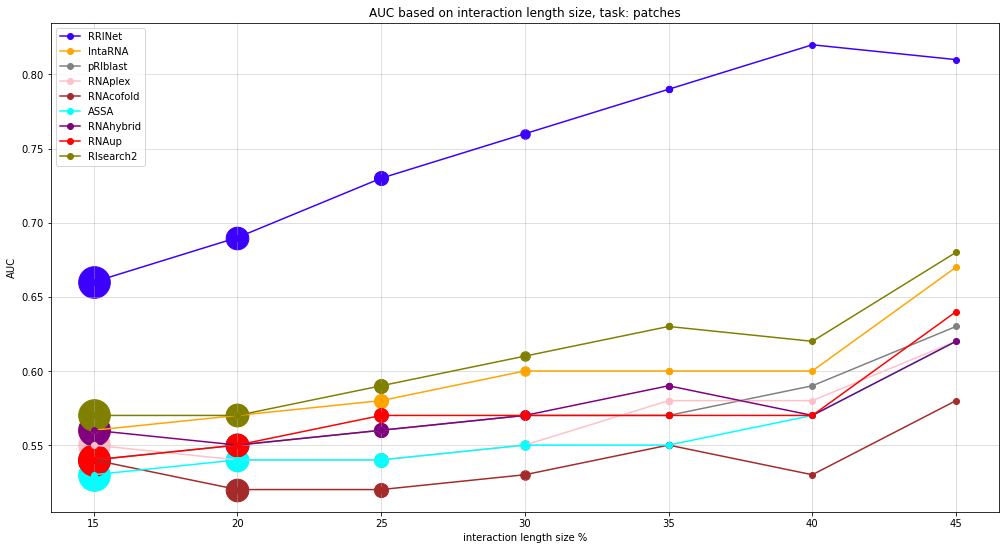

In [24]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'interaction length size'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for HQ_THRESHOLD in list_of_paris_hq_tresholds:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_paris_len{HQ_THRESHOLD}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)

    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_paris_hq_tresholds, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')

### Mouse

In [ ]:
model_names = list(df_auc['model_name'])
size_multiplier = 10
metric = 'AUC'
string_label = 'interaction length size'
figsize = (17,9)

for task_name in ['interactors', 'patches']:
    auc_models = []
    perc_models = []
    for model_name in model_names:
        auc_current_model = []
        for HQ_THRESHOLD in list_of_paris_hq_tresholds:
            auc_current_model.append(df_auc[df_auc['model_name'] == model_name][f'auc_{task_name}_paris_len{HQ_THRESHOLD}'].iloc[0])
        auc_models.append(auc_current_model)
        perc_models.append(np.array(n_positives_run)/np.max(n_positives_run) * 100)

    print('TASK: ', task_name)
    plt.figure(figsize=figsize)
    plot_metric_confidence_for_all_models(list_of_paris_hq_tresholds, auc_models, perc_models, model_names, task_name, size_multiplier, metric, string_label)
    plt.show()
    print('\n\n')